In [1]:
# Intorduction:
#   This repository contains a Python-based simulation framework for evaluating the effects of coefficient and output quantization on IIR filters. 
#   It compares floating-point and fixed-point implementations, providing insights into quantization-induced errors through both theoretical analysis and empirical simulation.
# Author:
#   Siqi Hui
# Version history:
#   1.0.0: initial version with basic functionality, including: 
#     - IIR filter design and implementation
#     - quantization of filter coefficients and outputs
#     - simulation of quantization errors
#   1.0.1: added support for highpass filters
#   1.0.2: added noise level parameter to simulate real-world conditions    
#   1.0.3: added simulation for mean quantization errors in different frequency bands
#   1.0.4: modify iir's ouput to be quantized by np.floor(y)+1, which is more suitable for fixed-point implementation
#   1.0.5: add software-base optimized method
#   1.0.6: use c-fixed lpf model to replace the previous iir filter design

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter
import scipy.signal as signal
import cffi
import os


In [3]:
# 在python环境下包裹cmodel 
class CModelCFFI:
    def __init__(self, source_code_or_path='./lpf.c'):
        """初始化C模型
        Args:
            source_code_or_path: C源代码字符串或C文件路径
        """
        self.ffi = cffi.FFI()
        
        # 定义C接口
        self.ffi.cdef("""
            void lpf(
                bool rst_n,
                int coeffs_0,
                int coeffs_1, 
                int coeffs_2,
                int coeffs_3,
                int coeffs_4,
                int din_data,
                int* dout_data,
                int* dout_frac
            );
        """)
        
        # 编译C代码
        if os.path.exists(source_code_or_path):
            # 从文件读取
            with open(source_code_or_path, 'r') as f:
                source_code = f.read()
        else:
            # 直接使用源代码字符串
            print("C source code file not found.")
            import sys
            sys.exit()
            source_code = source_code_or_path
        
        # 编译并加载库
        self.lib = self.ffi.verify(source_code)
        
        # 存储系数
        self.coeffs = None

        # 准备输出指针
        self.dout_data = self.ffi.new("int*")
        self.dout_frac = self.ffi.new("int*")
    
    def set_coefficients(self, coeffs):
        """设置滤波器系数
        Args:
            coeffs: 包含5个系数的列表或数组
        """
        if len(coeffs) != 5:
            raise ValueError("滤波器需要5个系数")
        self.coeffs = [int(c) for c in coeffs]
    
    def reset(self, ):
        """重置滤波器状态"""
        if self.coeffs is None:
            raise ValueError("请先设置滤波器系数")
        
        # 调用C函数进行重置
        self.lib.lpf(
            False, self.coeffs[0], self.coeffs[1], self.coeffs[2], 
            self.coeffs[3], self.coeffs[4],
            0,
            self.dout_data,
            self.dout_frac
        )
    
    def process(self, input_sample):
        """处理单个样本
        
        Args:
            input_sample: 输入样本值
            
        Returns:
            int: 输出样本值
        """
        if self.coeffs is None:
            raise ValueError("请先设置滤波器系数")

        # 调用C函数
        self.lib.lpf(
            True, self.coeffs[0], self.coeffs[1], self.coeffs[2], 
            self.coeffs[3], self.coeffs[4],
            int(input_sample),
            self.dout_data,
            self.dout_frac
        )
        
        return self.dout_data[0] #, dout_frac[0]

    def cleanup(self):
        if hasattr(self, 'output_ptr'):
            self.ffi.release(self.output_ptr)  # 显式释放


In [4]:
# float iir
class FloatIIRFilter:
    def __init__(self, b0, b1, b2, a1, a2):
        self.b0 = b0
        self.b1 = b1
        self.b2 = b2
        self.a1 = a1
        self.a2 = a2
        # 初始化存储过去的值, y1 y2为高bit的值
        self.x1 = 0
        self.x2 = 0
        self.y1 = 0
        self.y2 = 0
    
    def process(self, x):
        # 计算当前输出
        y = (self.b0 * x + self.b1 * self.x1 + self.b2 * self.x2 - 
             self.a1 * self.y1 - self.a2 * self.y2)

        # 更新历史值
        self.x2 = self.x1
        self.x1 = x
        self.y2 = self.y1
        self.y1 = y
        return y

In [5]:
def signal_generator(fs, time, signal_range, noise_range, signal_offset, start_freq, end_freq):
    """
    生成一个持续仿真时间的每秒频率递增的正弦波信号。
    参数：
    fs - 每秒采样点数
    time - 仿真时间（秒）
    signal_range - 信号幅度范围
    start_freq - 起始频率(Hz)
    end_freq - 终止频率(Hz)
    
    返回：
    generated_signal - 生成的信号
    """
    num_samples = fs * time  # 总样本数
    t = np.linspace(0, time, num_samples, endpoint=False)  # 时间序列
    generated_signal = np.zeros_like(t)  # 初始化信号数组

    # 逐秒递增频率，生成正弦波信号
    for i in range(time):
        freq = start_freq + i * (end_freq - start_freq) / time
        samples_per_cycle = fs / freq  # 每个周期的样本数
        num_cycles = int(fs // samples_per_cycle)  # 每秒能容纳的完整周期数

        if num_cycles >= 1:
            cycle_samples = int(num_cycles * samples_per_cycle)  # 完整周期的样本数
            t_segment = np.linspace(0, cycle_samples / fs, cycle_samples, endpoint=False)  # 当前段的时间序列
            sine_segment = np.sin(2 * np.pi * freq * t_segment)  # 生成当前频率的正弦波
            generated_signal[i * fs : i * fs + cycle_samples] = np.round(sine_segment * signal_range)  # 插入信号

    # 添加直流偏置
    generated_signal += signal_offset

    # 添加白噪声
    if noise_range > 0:
        noise = np.random.uniform(-noise_range, noise_range, len(generated_signal))
        generated_signal += np.round(noise)
    return generated_signal

In [6]:
def analyze_quantization_error(x, fc_fs_ratio, fcfs_bq_aq_dict, fs=10000, start_freq = 1, end_freq = 2500,
                               signal_range=10000, btype='low', feedback_half_lsb=False, float_iir_use_quant_coeff=True):
    """
    输入：
        x: 输入信号(1D numpy 数组)
        fc_fs_ratio: 截止频率与采样频率之比(0~0.5)
        fcfs_ba_aq_dict: fc/fs -> 量化后的b a系数 系数字典
        fs: 采样率(默认10000)
        signal_range: 信号幅度缩放因子(默认10000)
        btype: 滤波器类型('low'表示低通滤波器, 'high'表示高通滤波器)
        feedback_half_lsb: 是否在反馈路径添加0.5 LSB的偏移量以避免负反馈(默认False)
    """

    # cmodel quant_iir
    # -------------------------------------------
    try:
        quant_iir = CModelCFFI("./lpf.c")
        print("C模型加载成功!")
    except FileNotFoundError:
        print("C file not found...")
        # 方法2: 让类自动查找
        import sys
        sys.exit()

    fixed_coefficients = fcfs_bq_aq_dict[fc_fs_ratio][0]
    fixed_coefficients = [int(np.int32(coef)) for coef in fixed_coefficients]
    quant_iir.set_coefficients(fixed_coefficients)
    quant_iir.reset()
    # -------------------------------------------

    # fast python model quant_iir
    # quant_iir = QuantizedIIRFilter(b[0], b[1], b[2], a[1], a[2], iir_coeff_bit, output_dec_bits, feedback_half_lsb)

    actual_fc_fs_ratio = fcfs_bq_aq_dict[fc_fs_ratio][1]
    fc = actual_fc_fs_ratio * fs
    b, a = butter(2, fc / (fs / 2), btype=btype) # float


    if float_iir_use_quant_coeff:
        quant_factor = 1 / (2**iir_coeff_bit)
        b[0] = fixed_coefficients[0] * quant_factor
        b[1] = fixed_coefficients[1] * quant_factor
        b[2] = fixed_coefficients[2] * quant_factor
        a[1] = -fixed_coefficients[3] * quant_factor
        a[2] = fixed_coefficients[4] * quant_factor

    float_iir = FloatIIRFilter(b[0], b[1], b[2], a[1], a[2])
    y_float = np.array([float_iir.process(sample) for sample in x])
    
    y_quantized = np.array([quant_iir.process(sample) for sample in x])

    # 计算量化误差
    quant_error = y_quantized - y_float

    # 频率标尺
    total_time = len(x) // fs
    t = np.linspace(0, total_time, len(x), endpoint=False)

    # the same with signal_generator
    freq_ticks = [start_freq + (end_freq - start_freq) * (i / total_time) for i in range(0, total_time + 1, 10)]
    time_ticks = [i for i in range(0, total_time + 1, 10)]

    # === 计算每 fs 点内的平均绝对误差 ===
    quant_error_abs = np.abs(quant_error)
    window_size = fs
    mean_abs_error_per_window = [
        np.mean(quant_error_abs[i:i + window_size])
        for i in range(0, len(quant_error_abs), window_size)
    ]
    window_time = np.arange(len(mean_abs_error_per_window))

    # === 绘图 ===
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))

    ax1 = axes[0]
    ax1.plot(t, y_quantized, label="y_quantized", color='b')
    ax1.set_xticks(time_ticks)
    ax1.set_xticklabels([f'{f:.0f} Hz' for f in freq_ticks], rotation=90)
    ax1.set_xlabel('Frequency')
    ax1.set_ylabel('y_quantized', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.legend()
    ax1.set_title("Quantized Output Signal")
    ax1.grid(True)

    ax2 = axes[1]
    ax2.plot(t, quant_error, label="quant_error", color='r')
    ax2.set_xticks(time_ticks)
    ax2.set_xticklabels([f'{f:.0f} Hz' for f in freq_ticks], rotation=90)
    ax2.set_xlabel('Frequency')
    ax2.set_ylabel('Quantization Error', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.legend()
    ax2.set_title("Quantization Error")
    ax2.grid(True)

    ax3 = axes[2]
    ax3.plot(window_time, mean_abs_error_per_window, label="mean_abs_error/fs", color='g')
    ax3.set_xticks(time_ticks)
    ax3.set_xticklabels([f'{f:.0f} Hz' for f in freq_ticks], rotation=90)
    ax3.set_xlabel('Frequency')
    ax3.set_ylabel('Mean Absolute Error', color='g')
    ax3.tick_params(axis='y', labelcolor='g')
    ax3.legend()
    ax3.set_title("Mean Absolute Quantization Error per fs window")
    ax3.grid(True)

    plt.suptitle(
        f"Effect of Quantization, fc/fs: {fc_fs_ratio}, feedback bitwidth: {output_dec_bits}, "
        f"Coeffs bitwidth: {iir_coeff_bit}, filter bandtype: {btype}, "
        f"feedback_half_lsb: {feedback_half_lsb}, float_iir_use_quant_coeff: {float_iir_use_quant_coeff}",
        fontsize=14
    )
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [7]:
# # 当前建议的fc/fs -> bq aq 字典
fcfs_bq_aq_dict = {
    0.002: [[1, 3, 1, 64961, 32198], 0.001975],
    0.00225: [[2, 3, 2, 64855, 32094], 0.0023375],
    0.0025: [[2, 4, 2, 64808, 32048], 0.002501],
    0.00275: [[2, 5, 2, 64763, 32004], 0.0026535],
    0.003: [[3, 6, 3, 64643, 31887], 0.003066],
    0.00325: [[3, 7, 3, 64606, 31851], 0.0031935],
    0.0035: [[4, 7, 4, 64537, 31784], 0.003431],
    0.00375: [[4, 9, 4, 64472, 31721], 0.0036545],
    0.004: [[5, 10, 5, 64381, 31633], 0.003966],
    0.00425: [[6, 12, 6, 64270, 31526], 0.0043485],
    0.0045: [[6, 12, 6, 64270, 31526], 0.004349],
    0.00475: [[8, 15, 8, 64095, 31358], 0.0049485],
    0.005: [[7, 15, 7, 64143, 31404], 0.004785],
    0.00525: [[9, 18, 9, 63982, 31250], 0.0053375],
    0.0055: [[10, 20, 10, 63897, 31169], 0.00563],
    0.00575: [[11, 22, 11, 63816, 31092], 0.0059085],
    0.006: [[11, 21, 11, 63836, 31111], 0.00584],
    0.00625: [[13, 26, 13, 63664, 30948], 0.0064305],
    0.0065: [[13, 27, 13, 63646, 30931], 0.006493],
    0.00675: [[13, 26, 13, 63664, 30948], 0.0064305],
    0.007: [[16, 33, 16, 63440, 30737], 0.007202],
    0.00725: [[18, 36, 18, 63328, 30632], 0.0075855],
    0.0075: [[18, 36, 18, 63328, 30632], 0.007586],
    0.00775: [[18, 36, 18, 63328, 30632], 0.0075855],
    0.008: [[22, 43, 22, 63105, 30424], 0.008352],
    0.00825: [[23, 46, 23, 63035, 30359], 0.0085935],
    0.0085: [[22, 44, 22, 63091, 30411], 0.008401],
    0.00875: [[23, 46, 23, 63035, 30359], 0.0085935],
    0.009: [[26, 52, 26, 62874, 30210], 0.009148],
    0.00925: [[27, 53, 27, 62835, 30174], 0.0092815],
    0.0095: [[26, 52, 26, 62874, 30210], 0.009148],
    0.00975: [[31, 63, 31, 62612, 29969], 0.0100485],
    0.01: [[31, 62, 31, 62624, 29980], 0.010007],
    0.011: [[36, 71, 36, 62404, 29779], 0.010764],
    0.012: [[44, 88, 44, 62053, 29461], 0.011973],
    0.013: [[49, 97, 49, 61865, 29292], 0.01262],
    0.014: [[59, 118, 59, 61487, 28955], 0.013922],
    0.015: [[66, 131, 66, 61255, 28750], 0.014722],
    0.016: [[72, 144, 72, 61050, 28570], 0.015429],
    0.017: [[90, 180, 90, 60502, 28094], 0.017319],
    0.018: [[104, 209, 104, 60104, 27753], 0.018694],
    0.019: [[104, 209, 104, 60104, 27753], 0.018694],
    0.02: [[130, 260, 130, 59444, 27196], 0.020975],
    0.021: [[143, 286, 143, 59134, 26938], 0.022048],
    0.022: [[143, 286, 143, 59134, 26938], 0.022048],
    0.023: [[143, 286, 143, 59134, 26938], 0.022048],
    0.024: [[153, 305, 153, 58910, 26753], 0.022824],
    0.025: [[181, 363, 181, 58290, 26247], 0.024973],
    0.026: [[206, 412, 206, 57787, 25843], 0.026719],
    0.027: [[206, 412, 206, 57787, 25843], 0.026719],
    0.028: [[206, 412, 206, 57787, 25843], 0.026719],
    0.029: [[255, 510, 255, 56866, 25118], 0.029922],
    0.03: [[255, 510, 255, 56866, 25118], 0.029922],
    0.031: [[255, 510, 255, 56866, 25118], 0.029922],
    0.032: [[307, 614, 307, 55972, 24432], 0.033038],
    0.033: [[307, 614, 307, 55972, 24432], 0.033038],
    0.034: [[336, 672, 336, 55503, 24079], 0.034677],
    0.035: [[358, 716, 358, 55159, 23823], 0.03588],
    0.036: [[358, 716, 358, 55159, 23823], 0.03588],
    0.037: [[358, 716, 358, 55159, 23823], 0.03588],
    0.038: [[402, 804, 402, 54498, 23338], 0.038196],
    0.039: [[402, 804, 402, 54498, 23338], 0.038196],
    0.04: [[470, 940, 470, 53536, 22648], 0.041575],
    0.041: [[470, 940, 470, 53536, 22648], 0.041575],
    0.042: [[470, 940, 470, 53536, 22648], 0.041575],
    0.043: [[537, 1074, 537, 52646, 22026], 0.044711],
    0.044: [[537, 1074, 537, 52646, 22026], 0.044711],
    0.045: [[537, 1074, 537, 52646, 22026], 0.044711],
    0.046: [[537, 1074, 537, 52646, 22026], 0.044711],
    0.047: [[537, 1074, 537, 52646, 22026], 0.044711],
    0.048: [[618, 1236, 618, 51632, 21336], 0.048296],
    0.049: [[618, 1236, 618, 51632, 21336], 0.048296],
    0.05: [[618, 1236, 618, 51632, 21336], 0.048296],
    0.06: [[949, 1898, 949, 47980, 19008], 0.061323],
    0.07: [[1228, 2456, 1228, 45307, 17451], 0.07098],
    0.08: [[1636, 3272, 1636, 41815, 15591], 0.083761],
    0.09: [[1817, 3634, 1817, 40382, 14882], 0.089062],
    0.1: [[2331, 4662, 2331, 36598, 13154], 0.10322],
    0.11: [[2764, 5528, 2764, 33664, 11952], 0.114358],
    0.12: [[2764, 5528, 2764, 33664, 11952], 0.114358],
    0.13: [[3367, 6734, 3367, 29866, 10566], 0.12898],
    0.14: [[4105, 8210, 4105, 25566, 9218], 0.145802],
    0.15: [[4306, 8612, 4306, 24449, 8905], 0.150216],
    0.16: [[4794, 9588, 4794, 21819, 8227], 0.160676],
    0.17: [[4891, 9782, 4891, 21309, 8105], 0.162715],
    0.18: [[6105, 12210, 6105, 15230, 6882], 0.187254],
    0.19: [[6105, 12210, 6105, 15230, 6882], 0.187254],
    0.2: [[6349, 12698, 6349, 14068, 6696], 0.191989],
    0.21: [[7779, 15558, 7779, 7585, 5933], 0.218604],
    0.22: [[7898, 15796, 7898, 7068, 5892], 0.220738],
    0.23: [[7898, 15796, 7898, 7068, 5892], 0.220738],
    0.24: [[8953, 17906, 8953, 2615, 5659], 0.239161],
    0.25: [[8953, 17906, 8953, 2615, 5659], 0.239161]
}

In [8]:
# # 直流偏置
# btype_lists = ['low'] # ['low', 'high'] # lowpass or highpass filter
# fc_fs_ratio_lists = [0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24] 
# iir_coeff_bit_lists = [15]
# output_dec_bits_list = [11]
# signal_range_list = [0]
# feedback_half_lsb_list = [False] # [False, True]  # 是否在反馈路径添加0.5 LSB的偏移量以避免负反馈, 实际测试下来影响不大
# float_iir_use_quant_coeff_list = [True, False] # [True, False]  # 是否使用量化系数来初始化浮点IIR
# noise_range = 0
# signal_offset = 10000
# # signal generator params
# # 生成一个从1Hz到2500Hz的正弦波信号，1s一个频率段
# start_freq = 1      # 起始频率
# end_freq = 1     # 终止频率
# fs = 3200  # 每秒采样点数
# time = 2  # 仿真时间

# for btype in btype_lists:
#     for signal_range in signal_range_list:
#         generated_signal = signal_generator(fs, time, signal_range, noise_range, signal_offset, start_freq, end_freq)
#         for fc_fs_ratio in fc_fs_ratio_lists:
#             for iir_coeff_bit in iir_coeff_bit_lists:
#                 for output_dec_bits in output_dec_bits_list:
#                     for feedback_half_lsb in feedback_half_lsb_list:
#                         for float_iir_use_quant_coeff in float_iir_use_quant_coeff_list:
#                             print("fc_fs_ratio: ", fc_fs_ratio)
#                             analyze_quantization_error(generated_signal, fc_fs_ratio, fcfs_bq_aq_dict, fs=fs, start_freq = start_freq, end_freq = end_freq, signal_range=signal_range, btype=btype, feedback_half_lsb=feedback_half_lsb, float_iir_use_quant_coeff=float_iir_use_quant_coeff)

                            

In [9]:
# # # 随机信号测试，直流偏置 + 白噪声
# btype_lists = ['low'] # ['low', 'high'] # lowpass or highpass filter
# fc_fs_ratio_lists = [0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24] 
# iir_coeff_bit_lists = [15]
# output_dec_bits_list = [11]
# signal_range_list = [0]
# feedback_half_lsb_list = [False] # [False, True]  # 是否在反馈路径添加0.5 LSB的偏移量以避免负反馈, 实际测试下来影响不大
# float_iir_use_quant_coeff_list = [True, False] # [True, False]  # 是否使用量化系数来初始化浮点IIR
# noise_range = 1000
# signal_offset = 10000
# # signal generator params
# # 生成一个从1Hz到2500Hz的正弦波信号，1s一个频率段
# start_freq = 1      # 起始频率
# end_freq = 1     # 终止频率
# fs = 3200  # 每秒采样点数
# time = 2  # 仿真时间

# for btype in btype_lists:
#     for signal_range in signal_range_list:
#         generated_signal = signal_generator(fs, time, signal_range, noise_range, signal_offset, start_freq, end_freq)
#         for fc_fs_ratio in fc_fs_ratio_lists:
#             for iir_coeff_bit in iir_coeff_bit_lists:
#                 for output_dec_bits in output_dec_bits_list:
#                     for feedback_half_lsb in feedback_half_lsb_list:
#                         for float_iir_use_quant_coeff in float_iir_use_quant_coeff_list:
#                             print("fc_fs_ratio: ", fc_fs_ratio)
#                             analyze_quantization_error(generated_signal, fc_fs_ratio, fcfs_bq_aq_dict, fs=fs, start_freq = start_freq, end_freq = end_freq, signal_range=signal_range, btype=btype, feedback_half_lsb=feedback_half_lsb, float_iir_use_quant_coeff=float_iir_use_quant_coeff)

                            

set fc_fs_ratio:  0.004
actually used fc_fs_ratio:  0.003966
C模型加载成功!


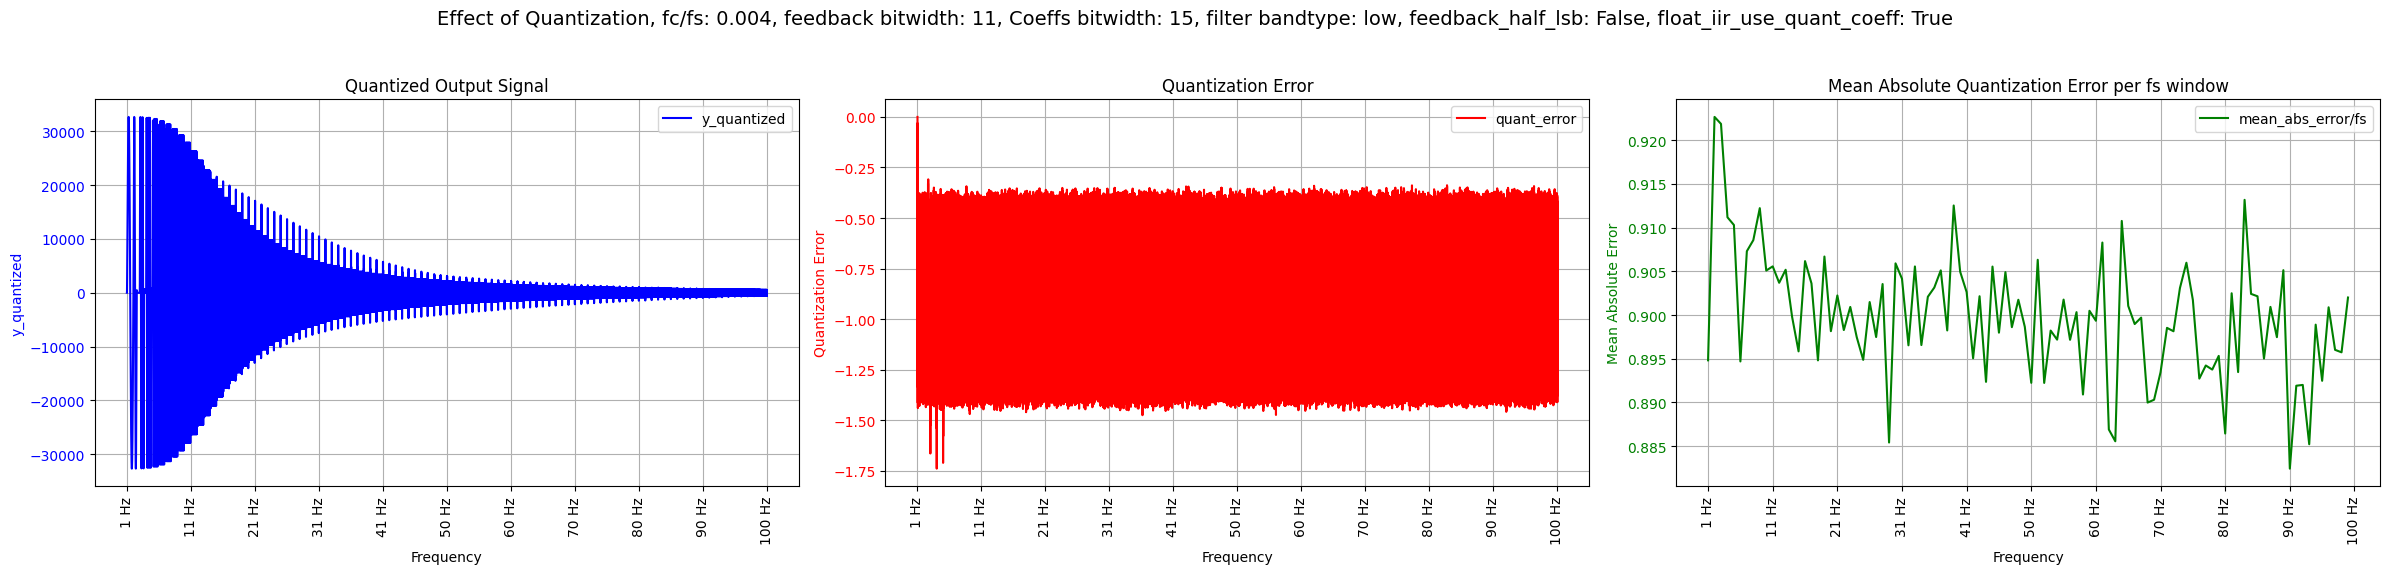

set fc_fs_ratio:  0.004
actually used fc_fs_ratio:  0.003966
C模型加载成功!


/usr/local/lib/python3.10/dist-packages/cffi/vengine_cpy.py:191: UserWarning: reimporting '_cffi__xadf2c5f3xa514687e' might overwrite older definitions
  warnings.warn("reimporting %r might overwrite older definitions"


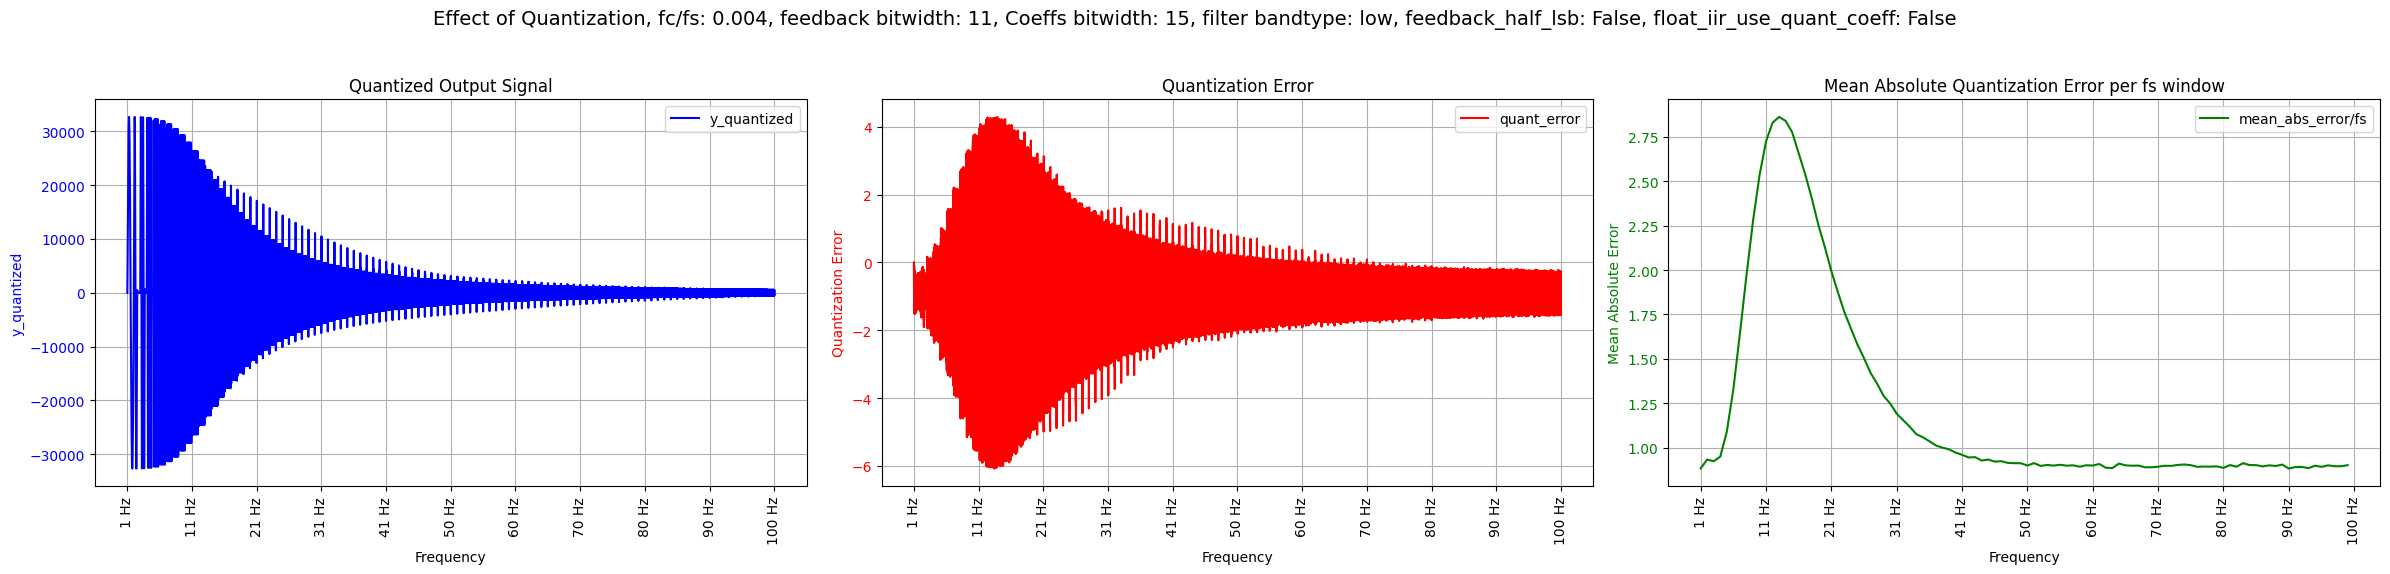

set fc_fs_ratio:  0.005
actually used fc_fs_ratio:  0.004785
C模型加载成功!


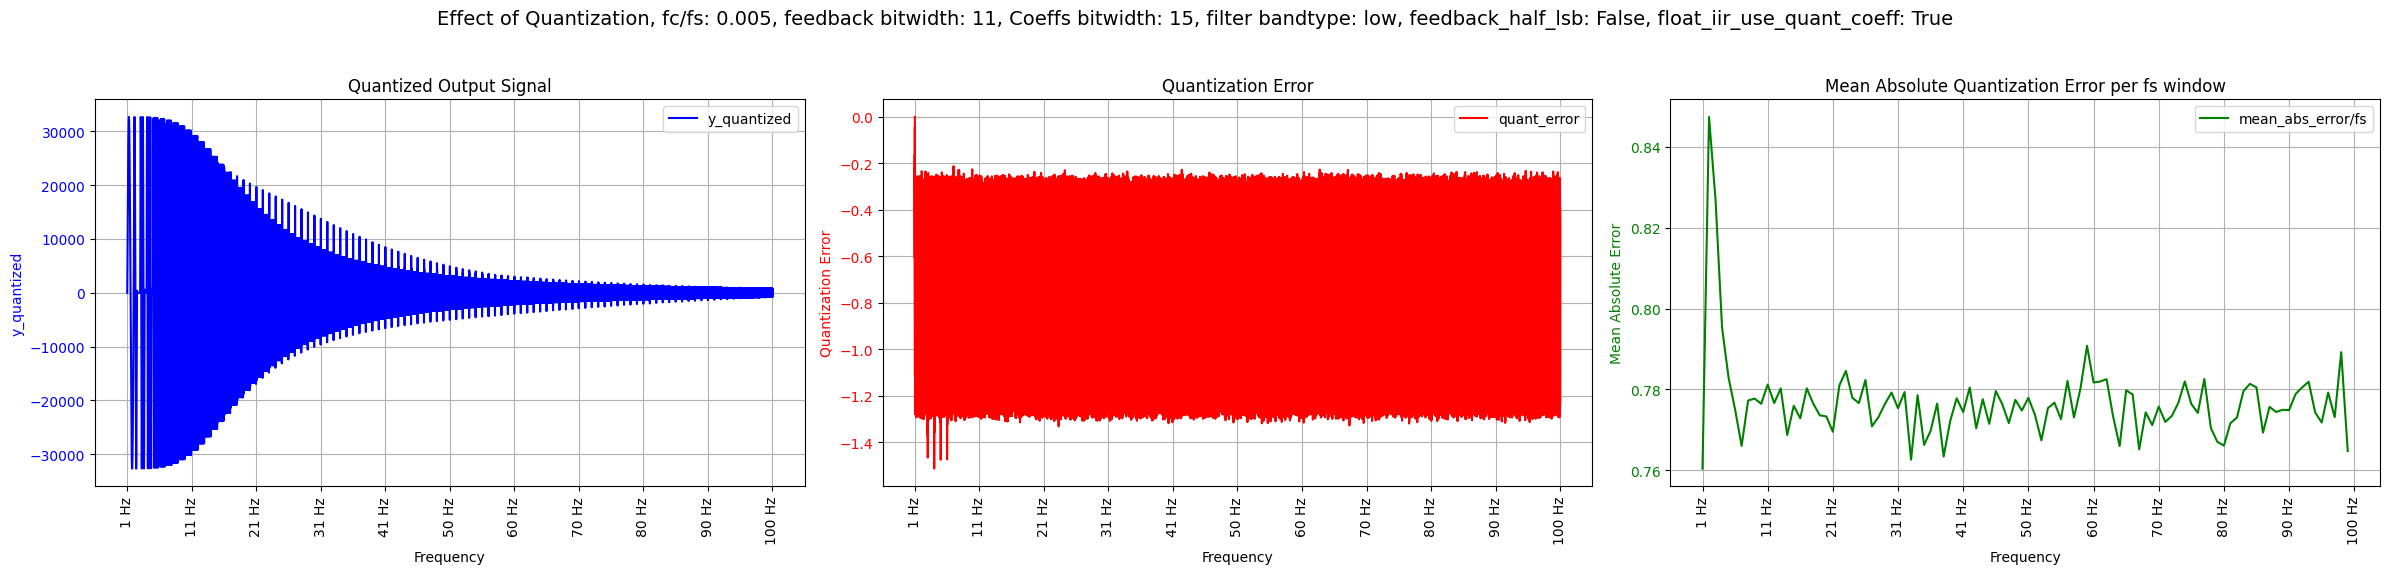

set fc_fs_ratio:  0.005
actually used fc_fs_ratio:  0.004785
C模型加载成功!


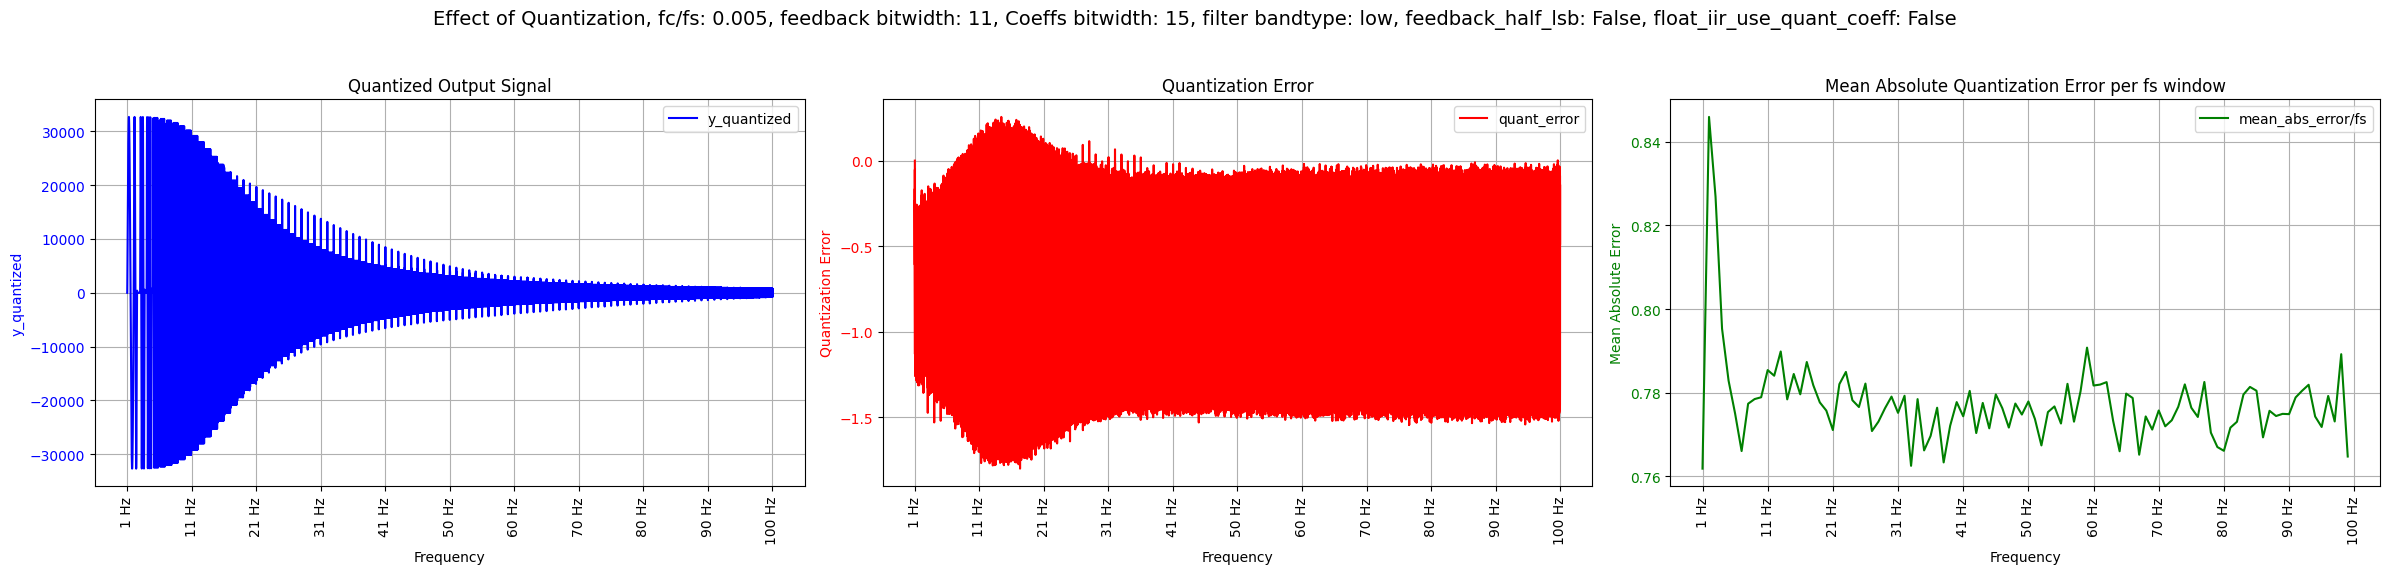

set fc_fs_ratio:  0.006
actually used fc_fs_ratio:  0.00584
C模型加载成功!


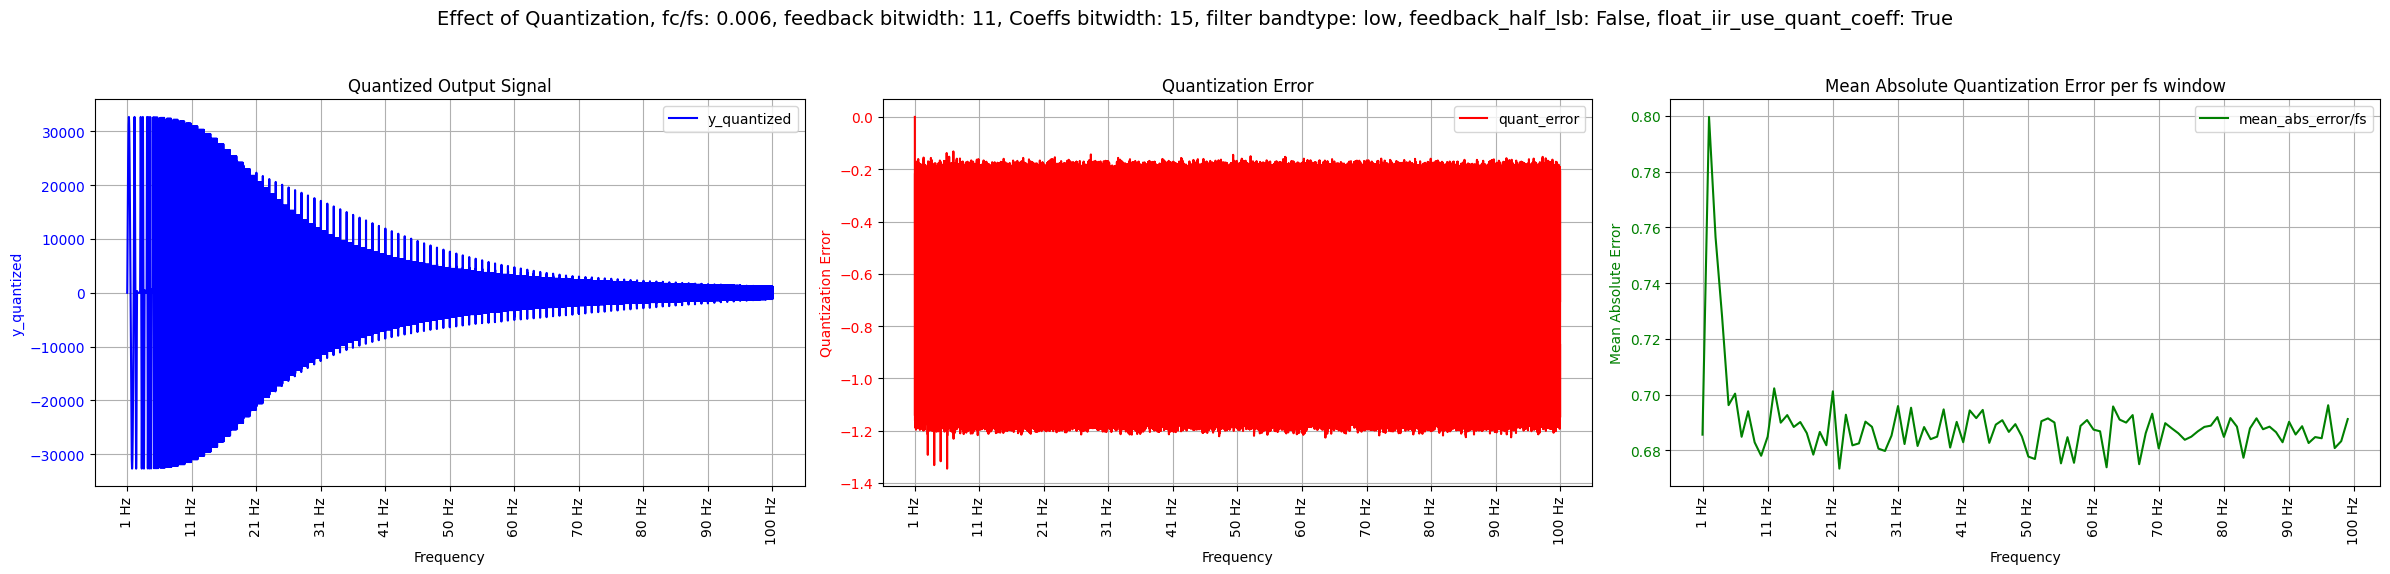

set fc_fs_ratio:  0.006
actually used fc_fs_ratio:  0.00584
C模型加载成功!


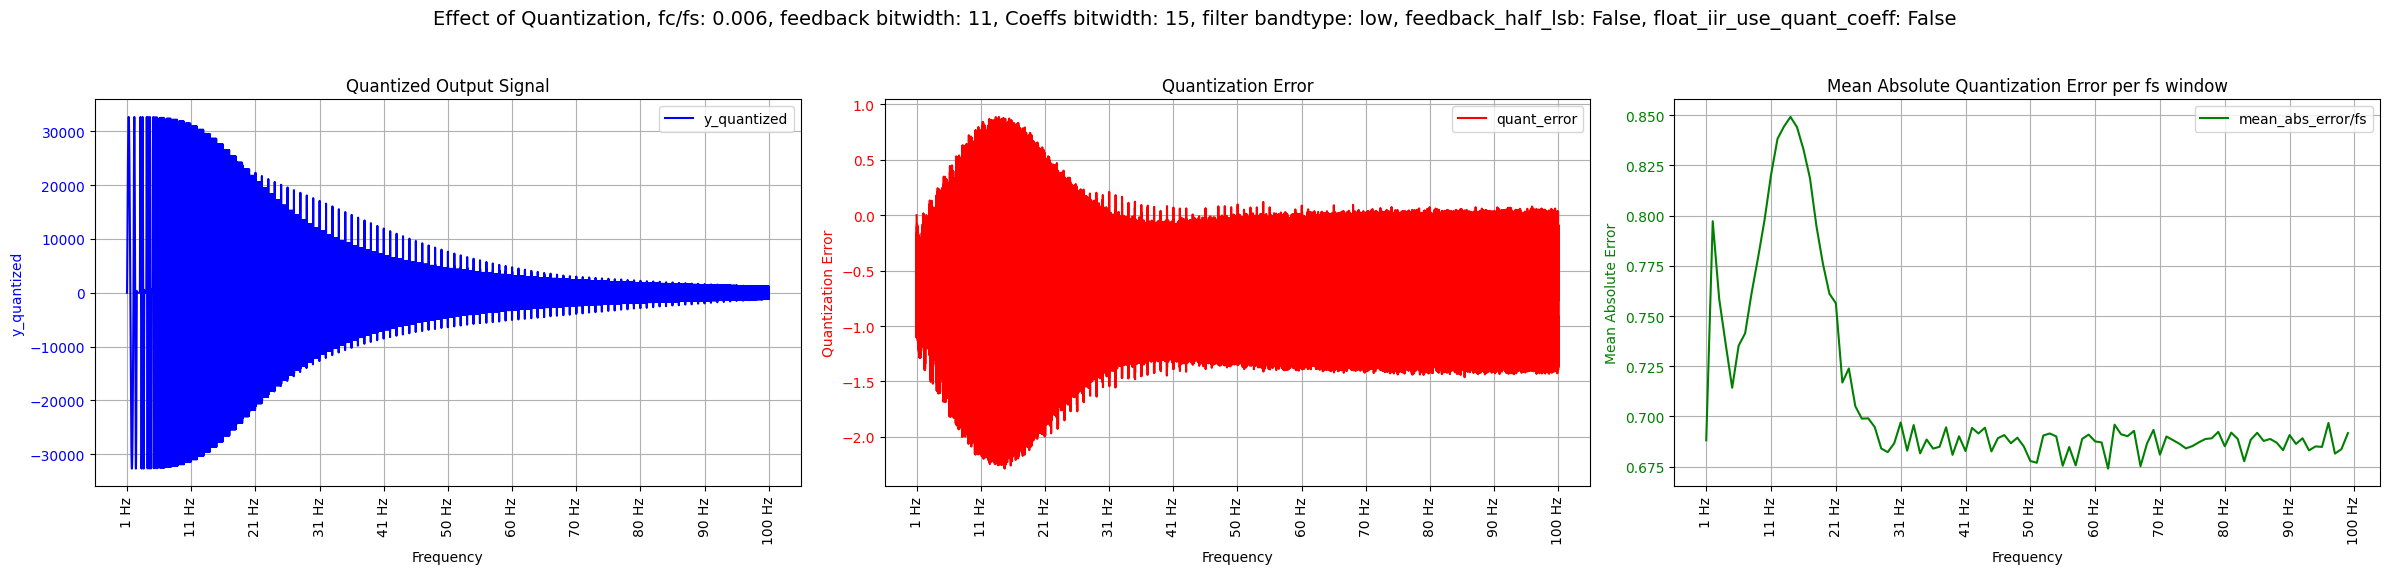

set fc_fs_ratio:  0.007
actually used fc_fs_ratio:  0.007202
C模型加载成功!


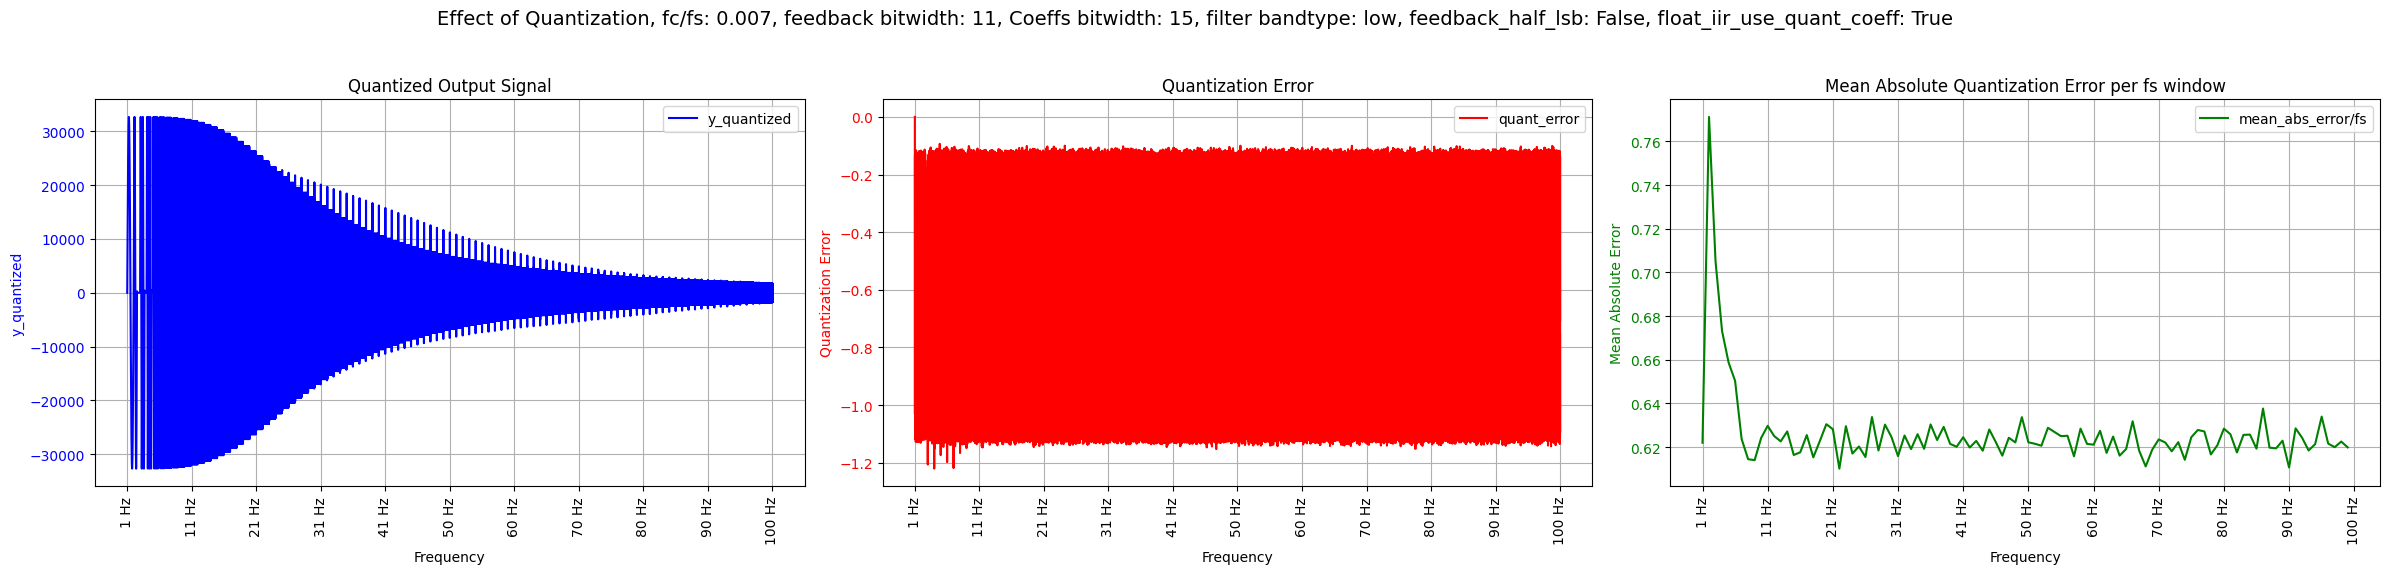

set fc_fs_ratio:  0.007
actually used fc_fs_ratio:  0.007202
C模型加载成功!


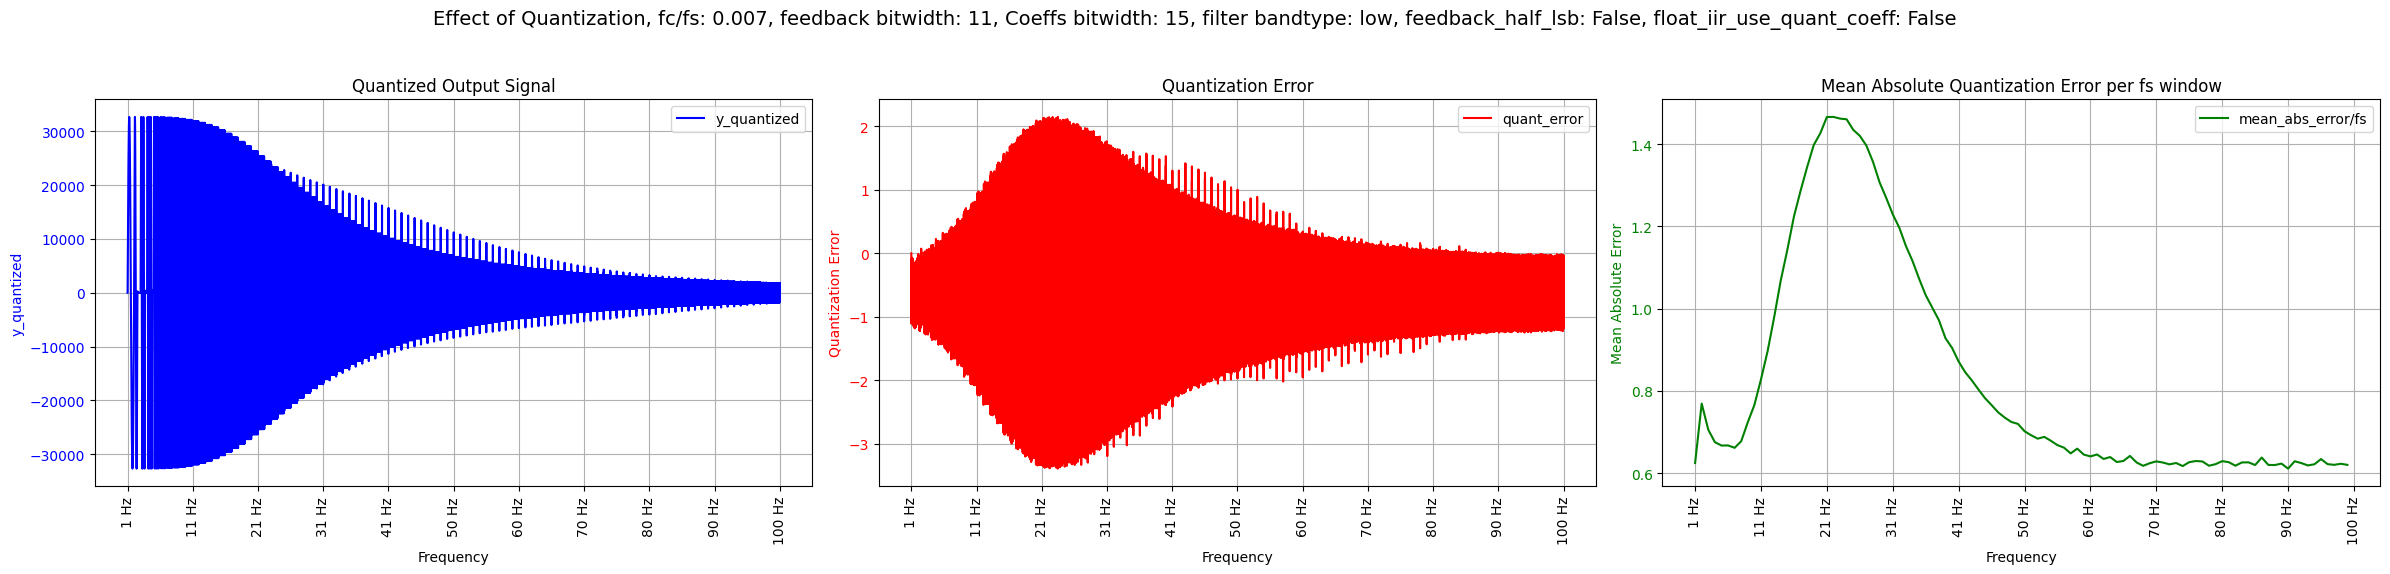

set fc_fs_ratio:  0.008
actually used fc_fs_ratio:  0.008352
C模型加载成功!


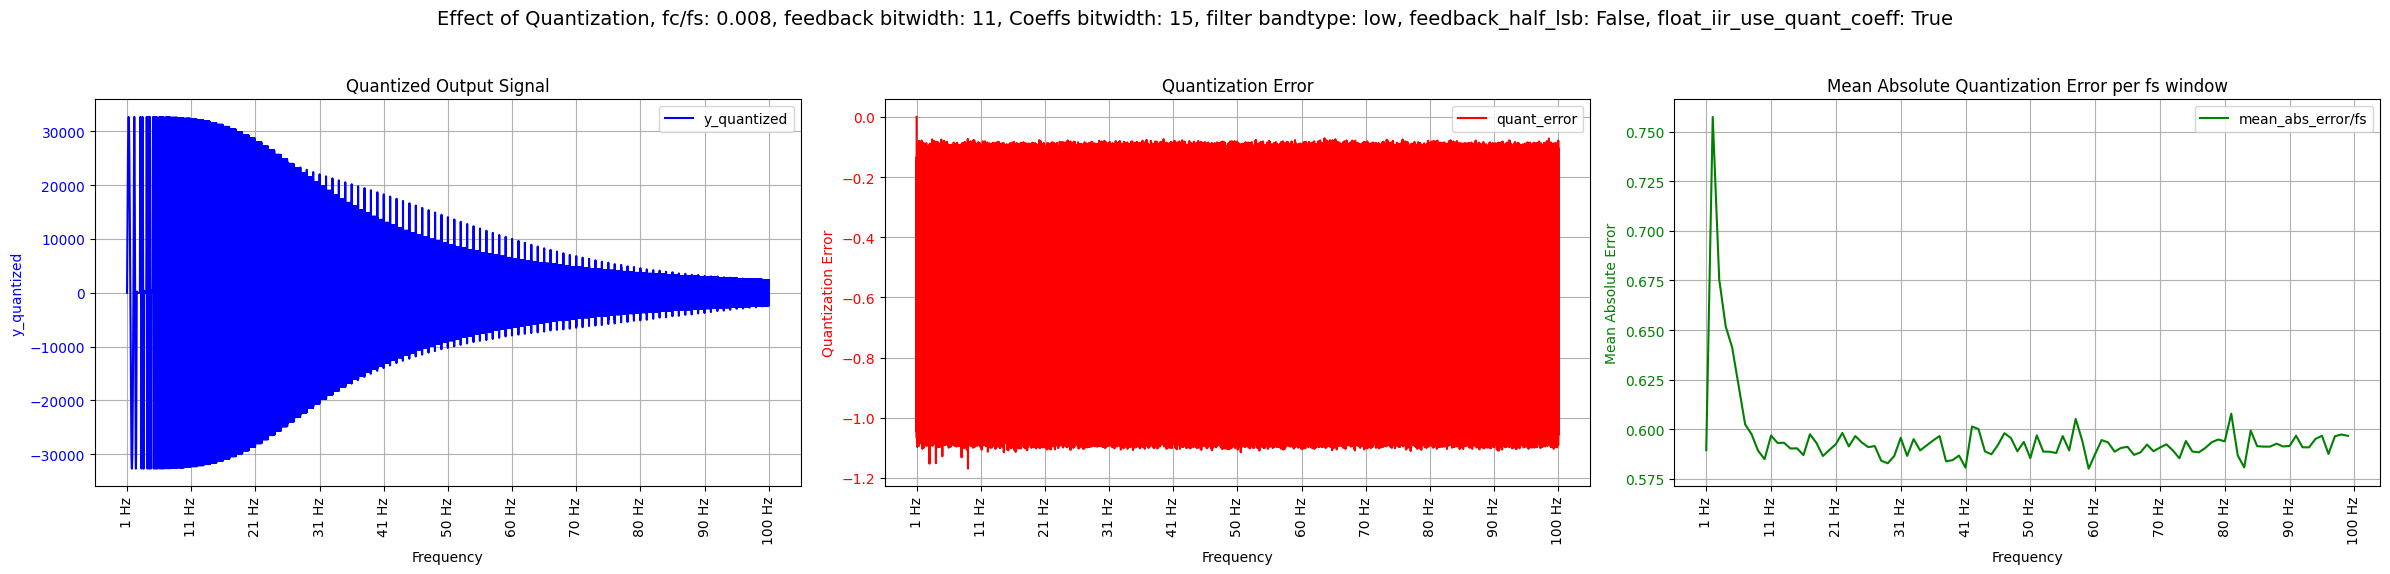

set fc_fs_ratio:  0.008
actually used fc_fs_ratio:  0.008352
C模型加载成功!


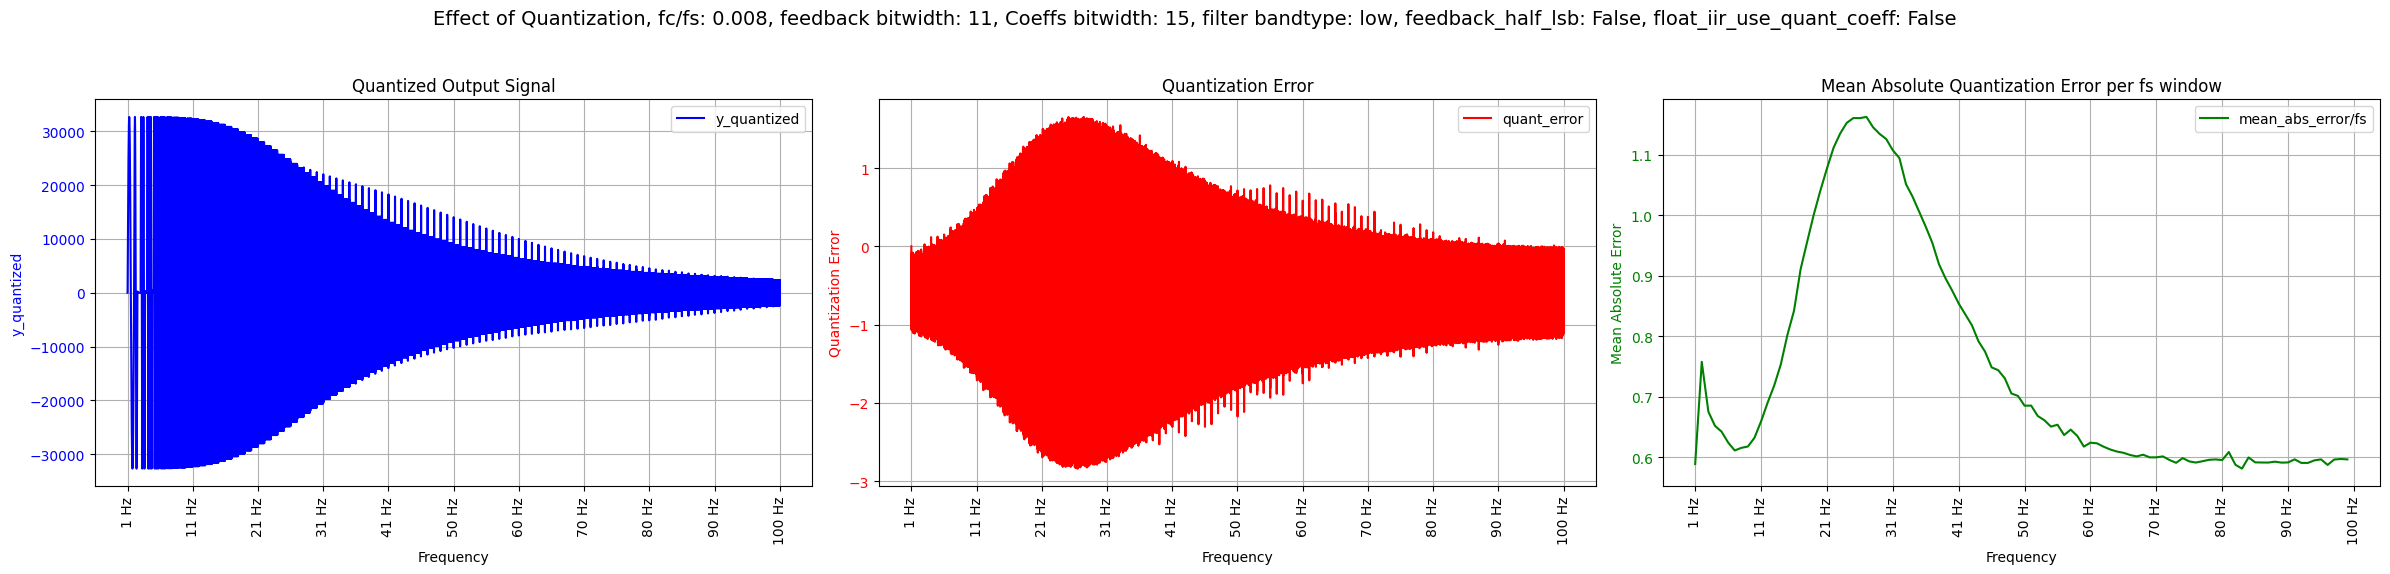

set fc_fs_ratio:  0.009
actually used fc_fs_ratio:  0.009148
C模型加载成功!


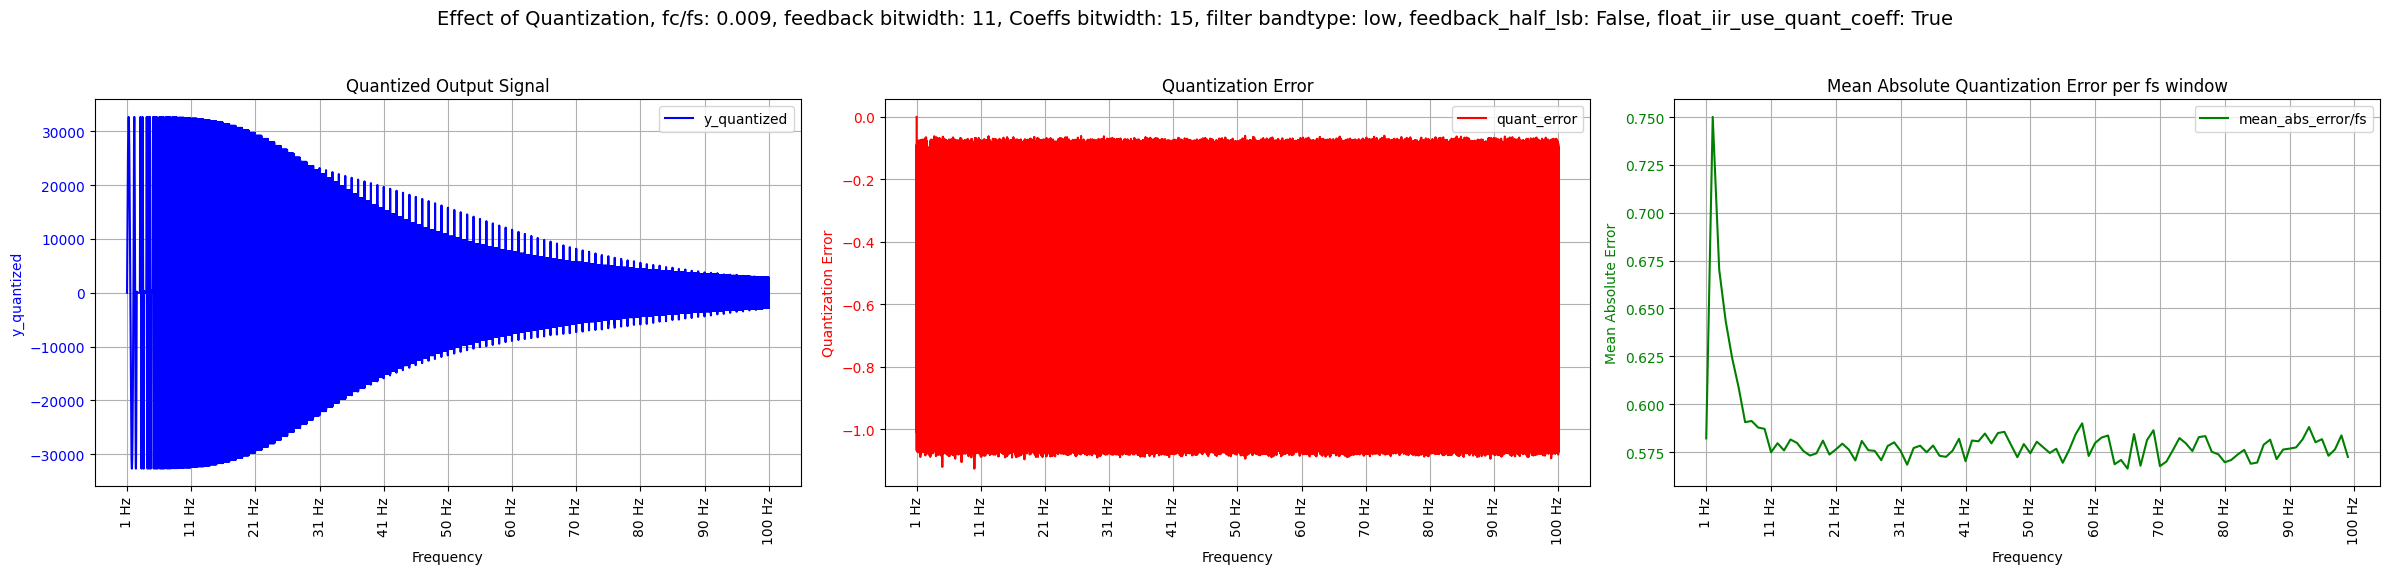

set fc_fs_ratio:  0.009
actually used fc_fs_ratio:  0.009148
C模型加载成功!


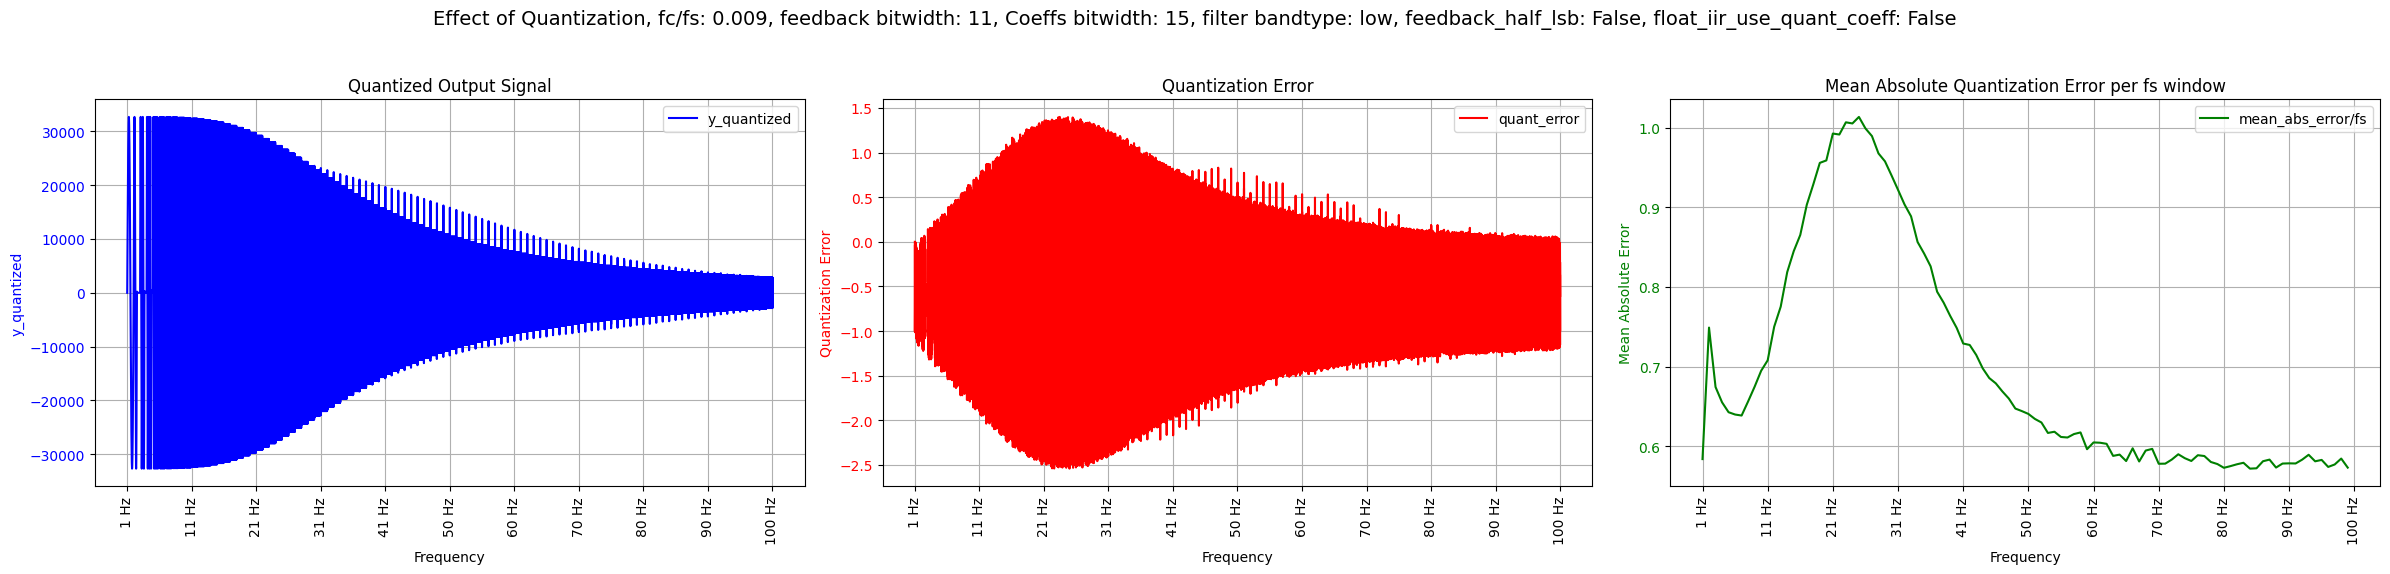

set fc_fs_ratio:  0.01
actually used fc_fs_ratio:  0.010007
C模型加载成功!


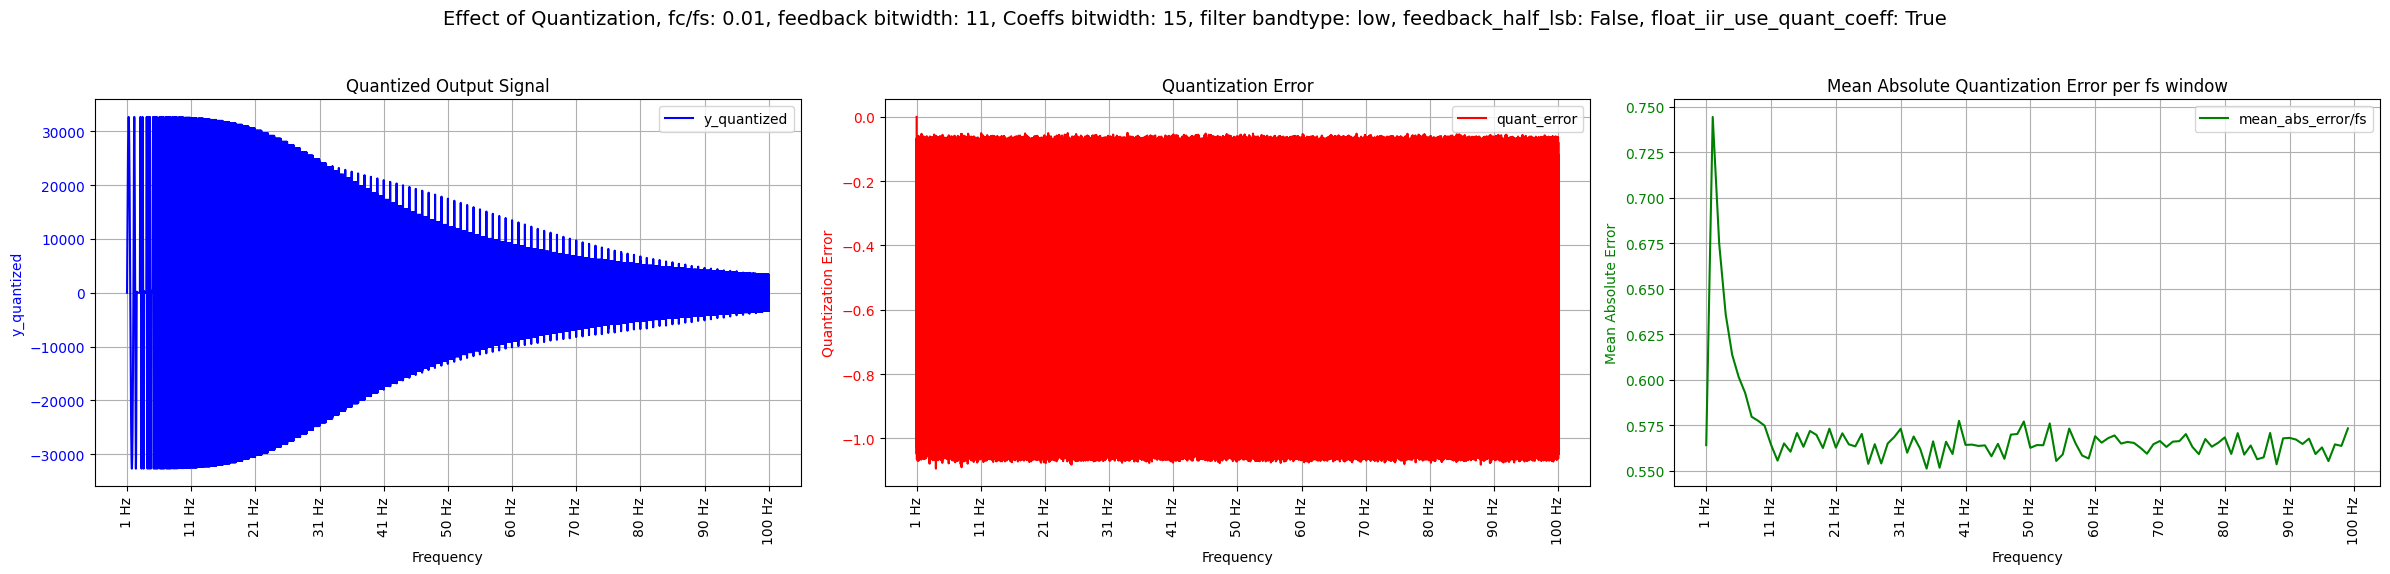

set fc_fs_ratio:  0.01
actually used fc_fs_ratio:  0.010007
C模型加载成功!


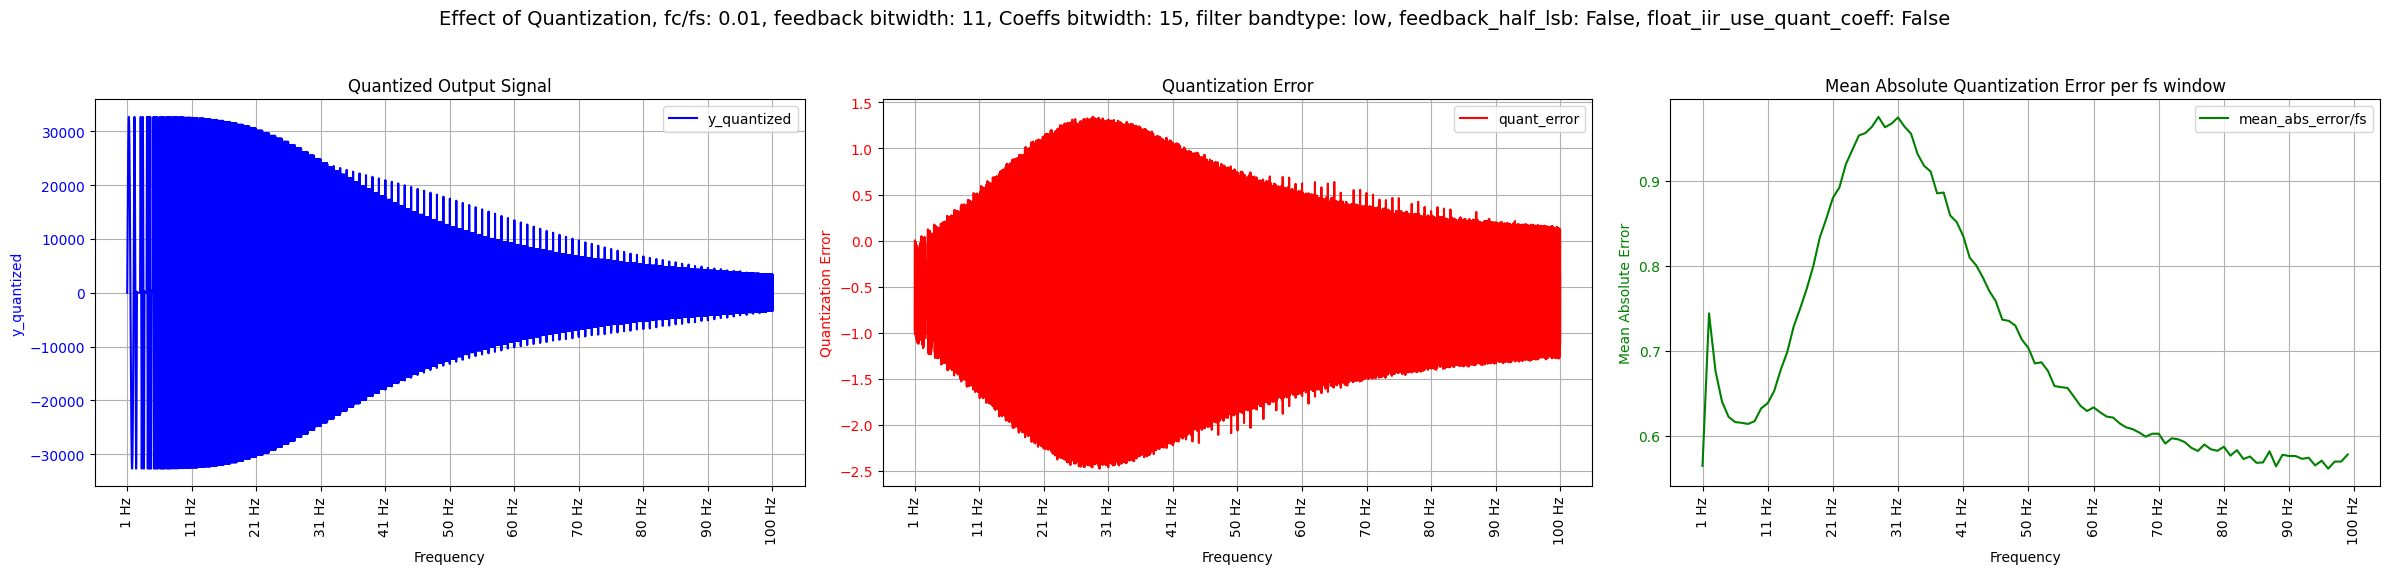

set fc_fs_ratio:  0.02
actually used fc_fs_ratio:  0.020975
C模型加载成功!


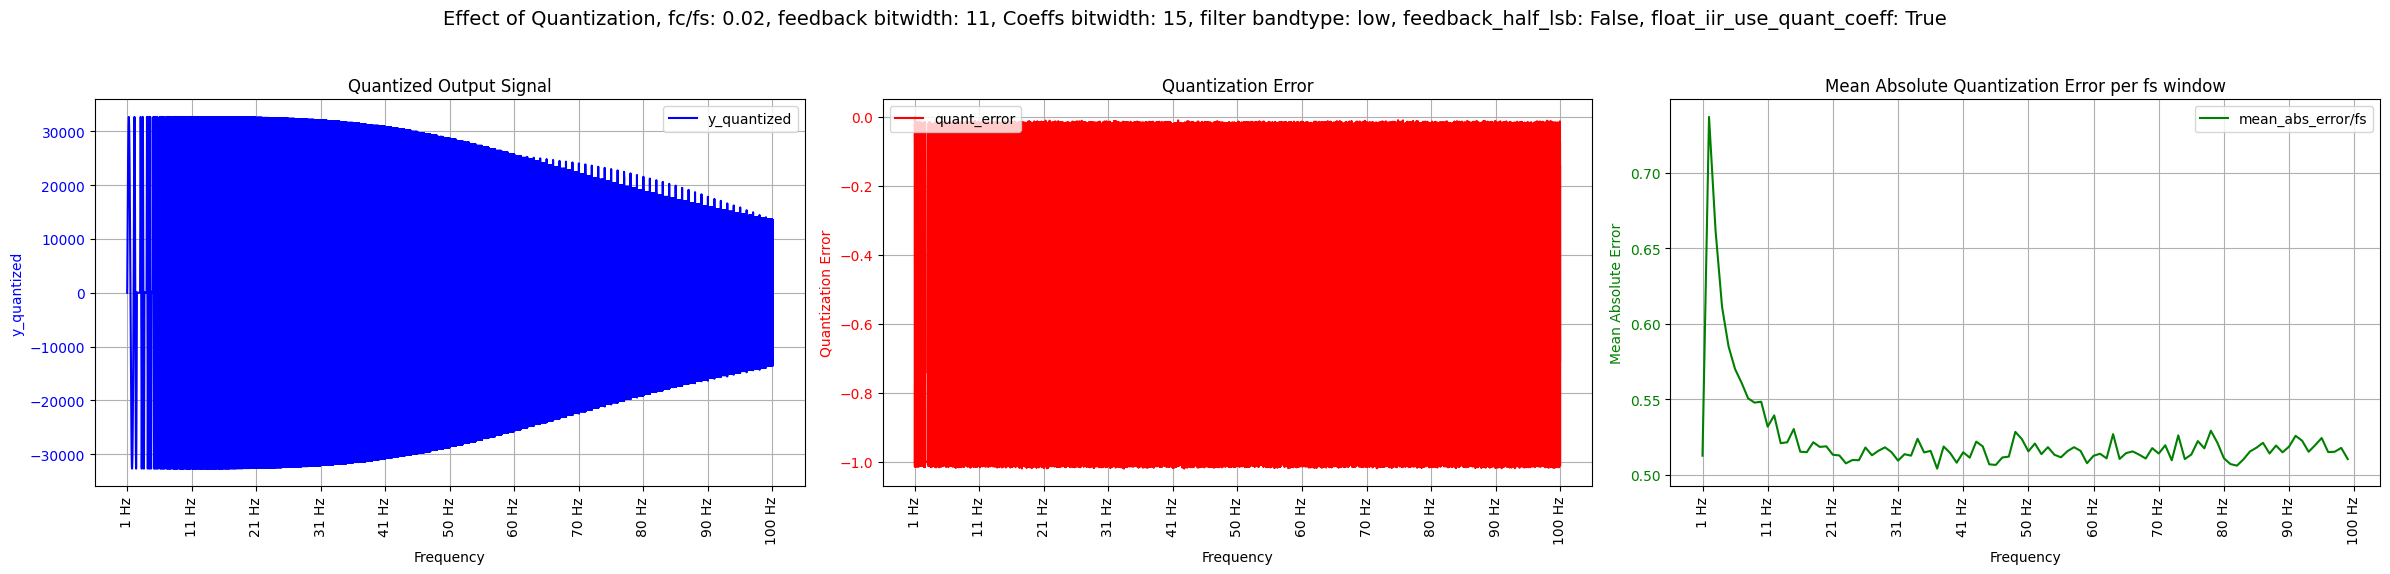

set fc_fs_ratio:  0.02
actually used fc_fs_ratio:  0.020975
C模型加载成功!


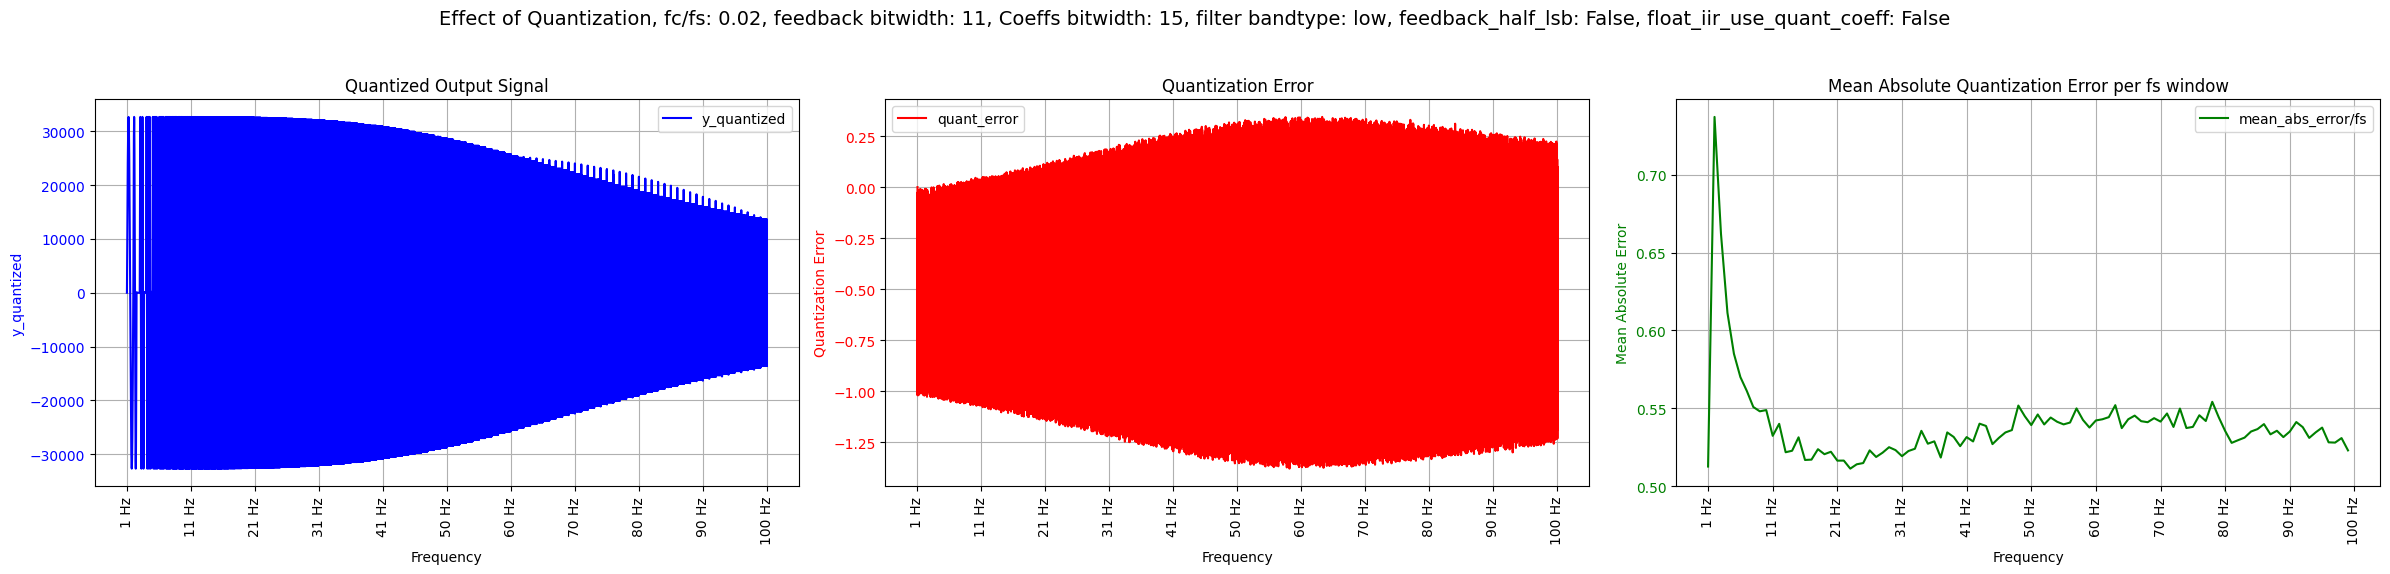

set fc_fs_ratio:  0.03
actually used fc_fs_ratio:  0.029922
C模型加载成功!


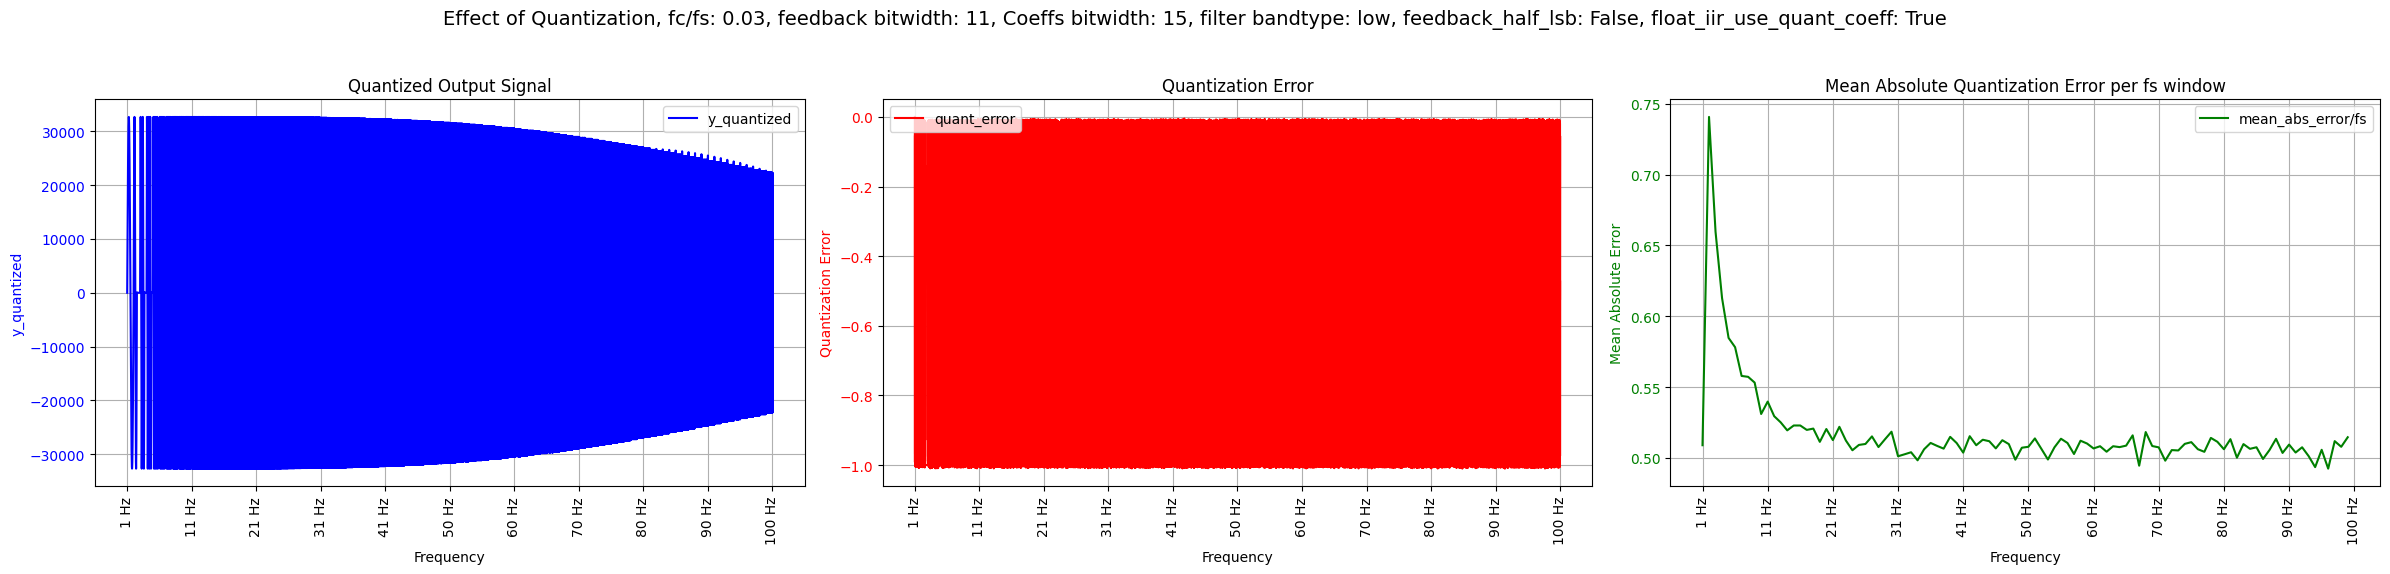

set fc_fs_ratio:  0.03
actually used fc_fs_ratio:  0.029922
C模型加载成功!


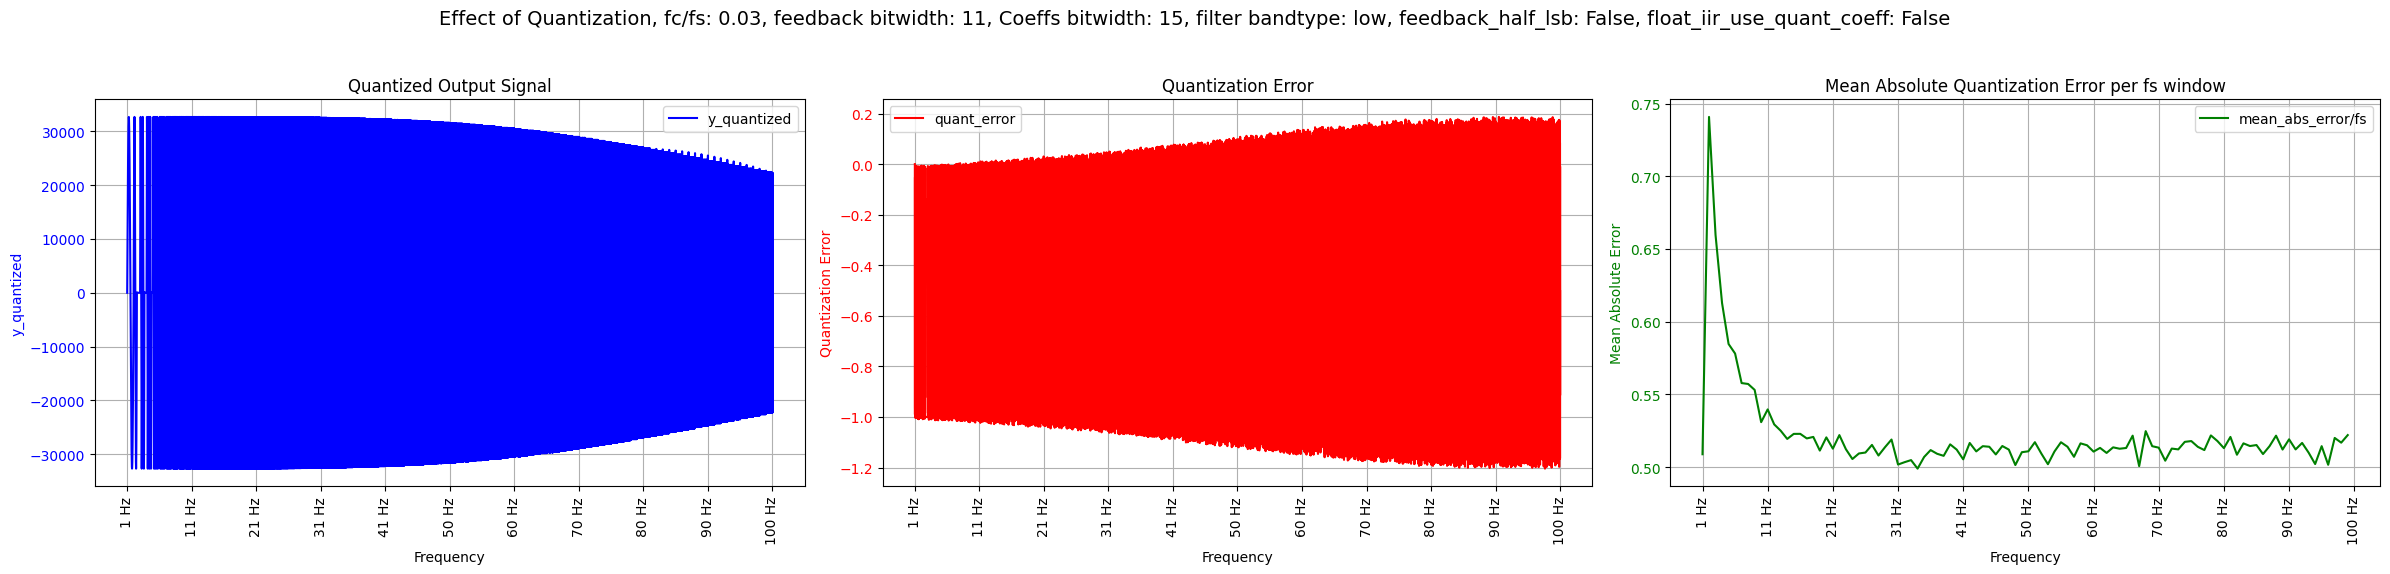

set fc_fs_ratio:  0.04
actually used fc_fs_ratio:  0.041575
C模型加载成功!


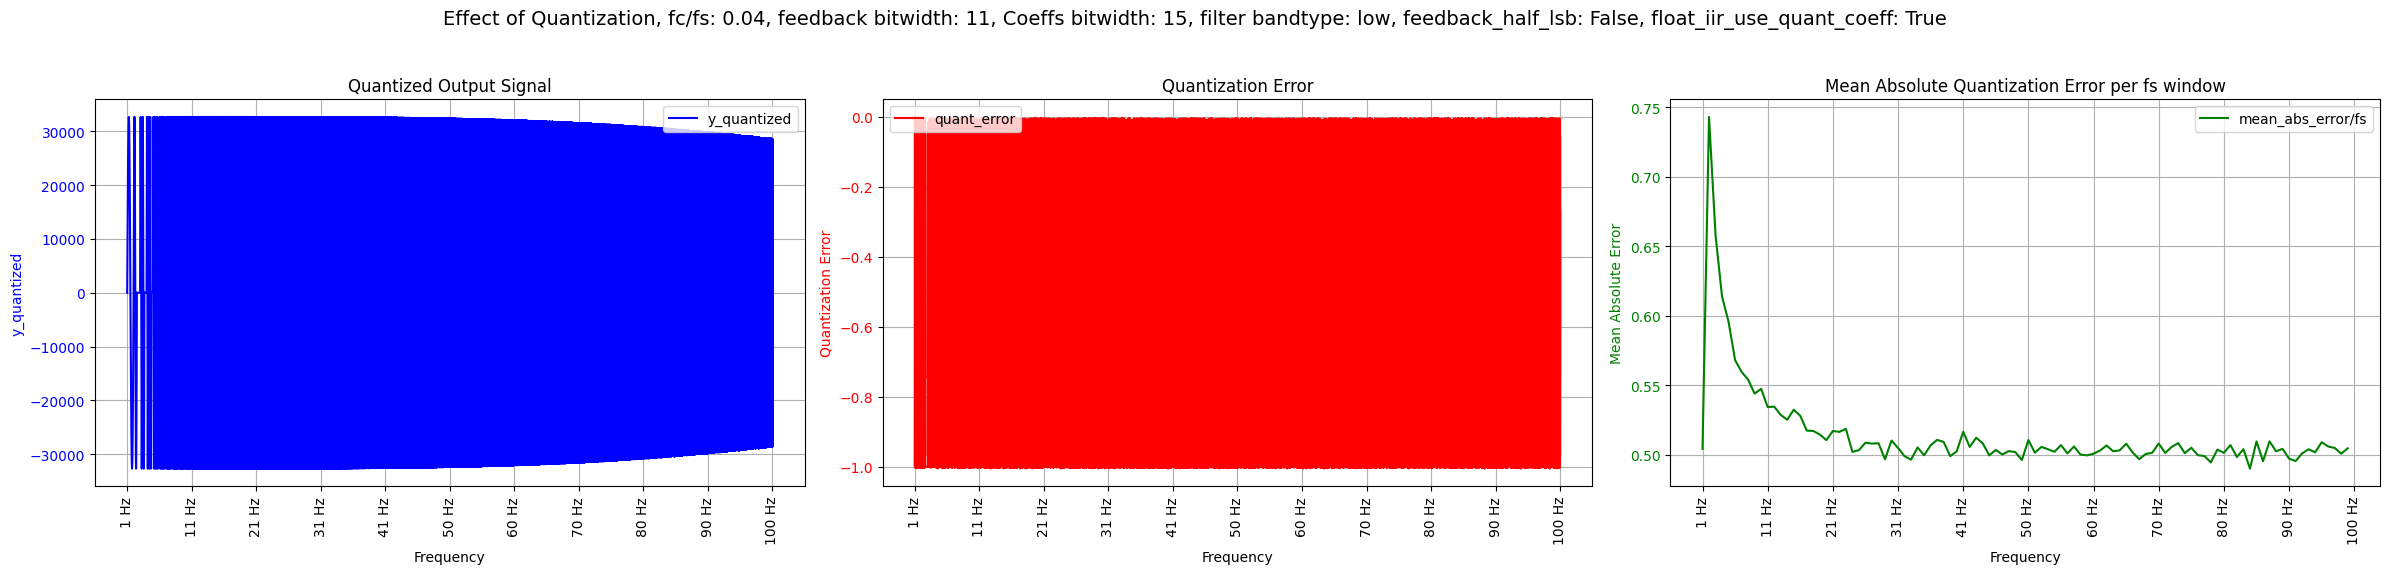

set fc_fs_ratio:  0.04
actually used fc_fs_ratio:  0.041575
C模型加载成功!


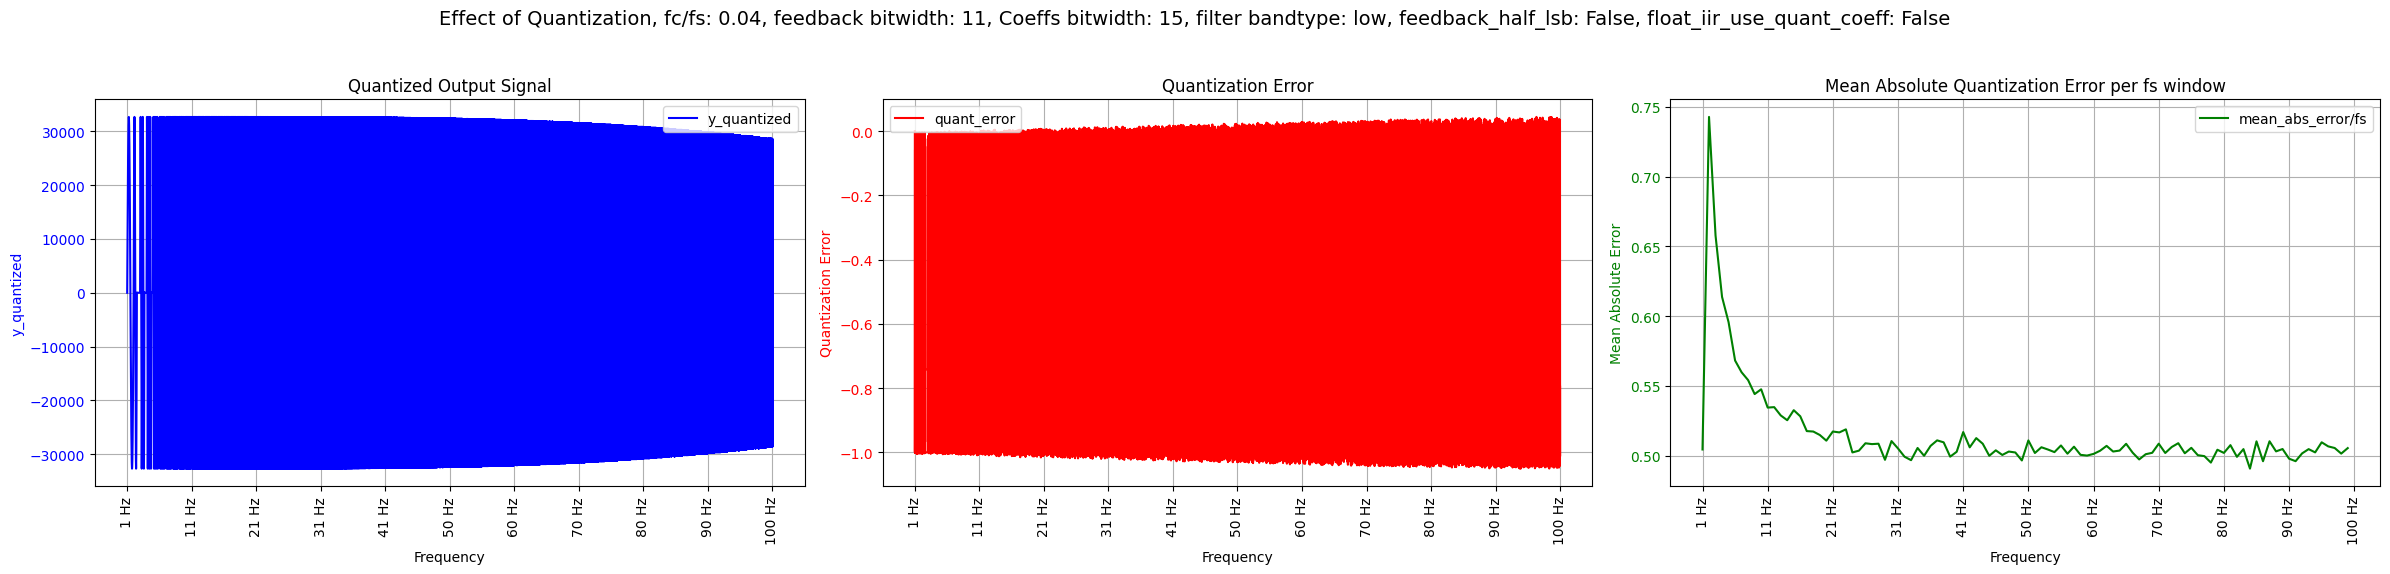

set fc_fs_ratio:  0.05
actually used fc_fs_ratio:  0.048296
C模型加载成功!


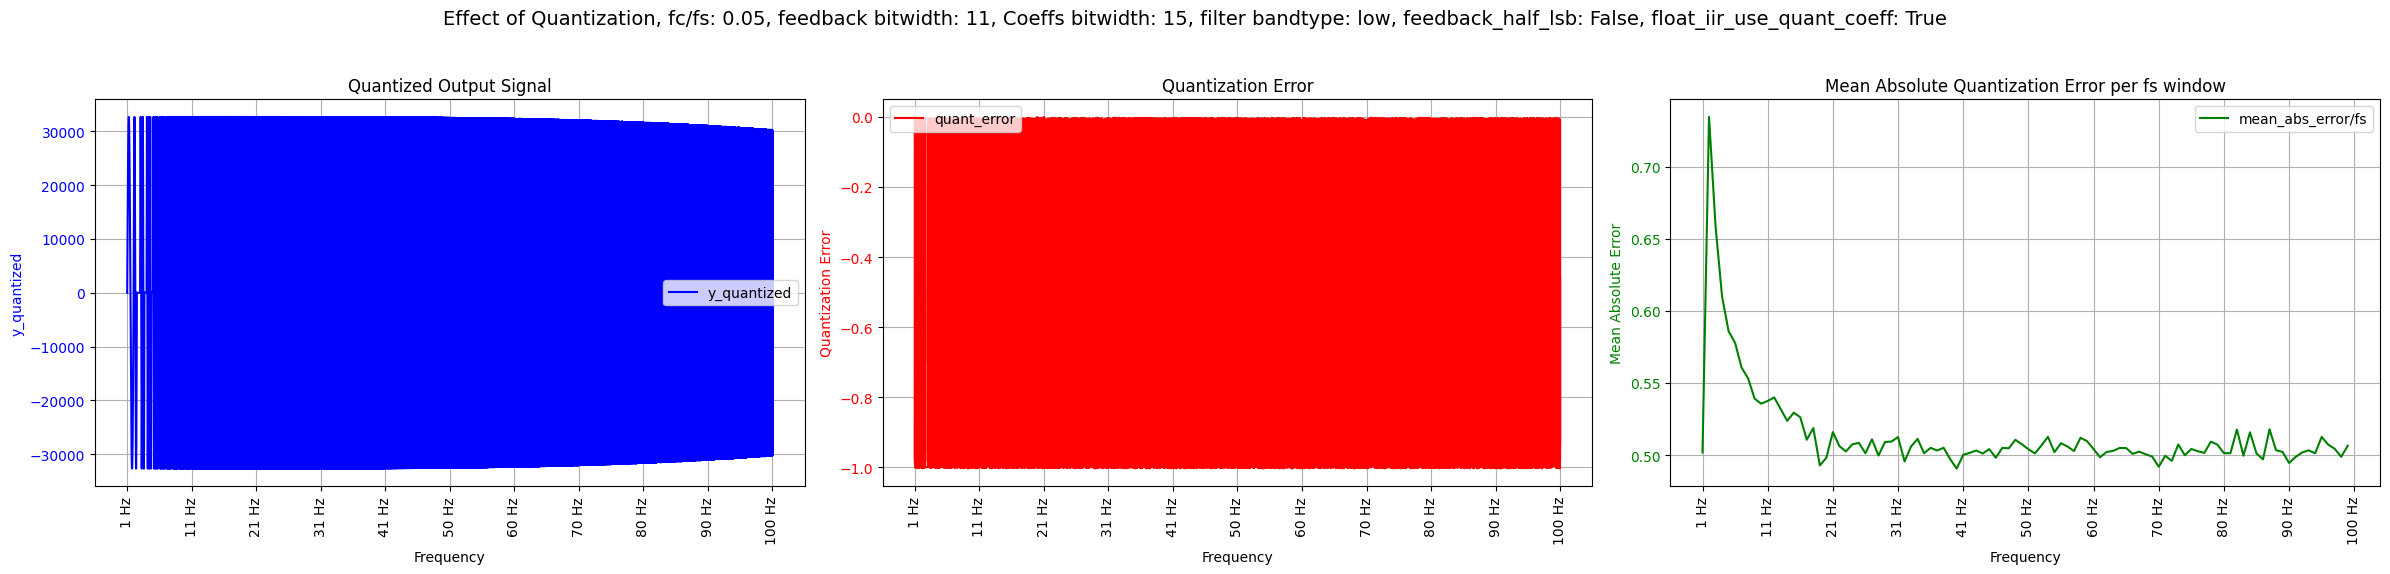

set fc_fs_ratio:  0.05
actually used fc_fs_ratio:  0.048296
C模型加载成功!


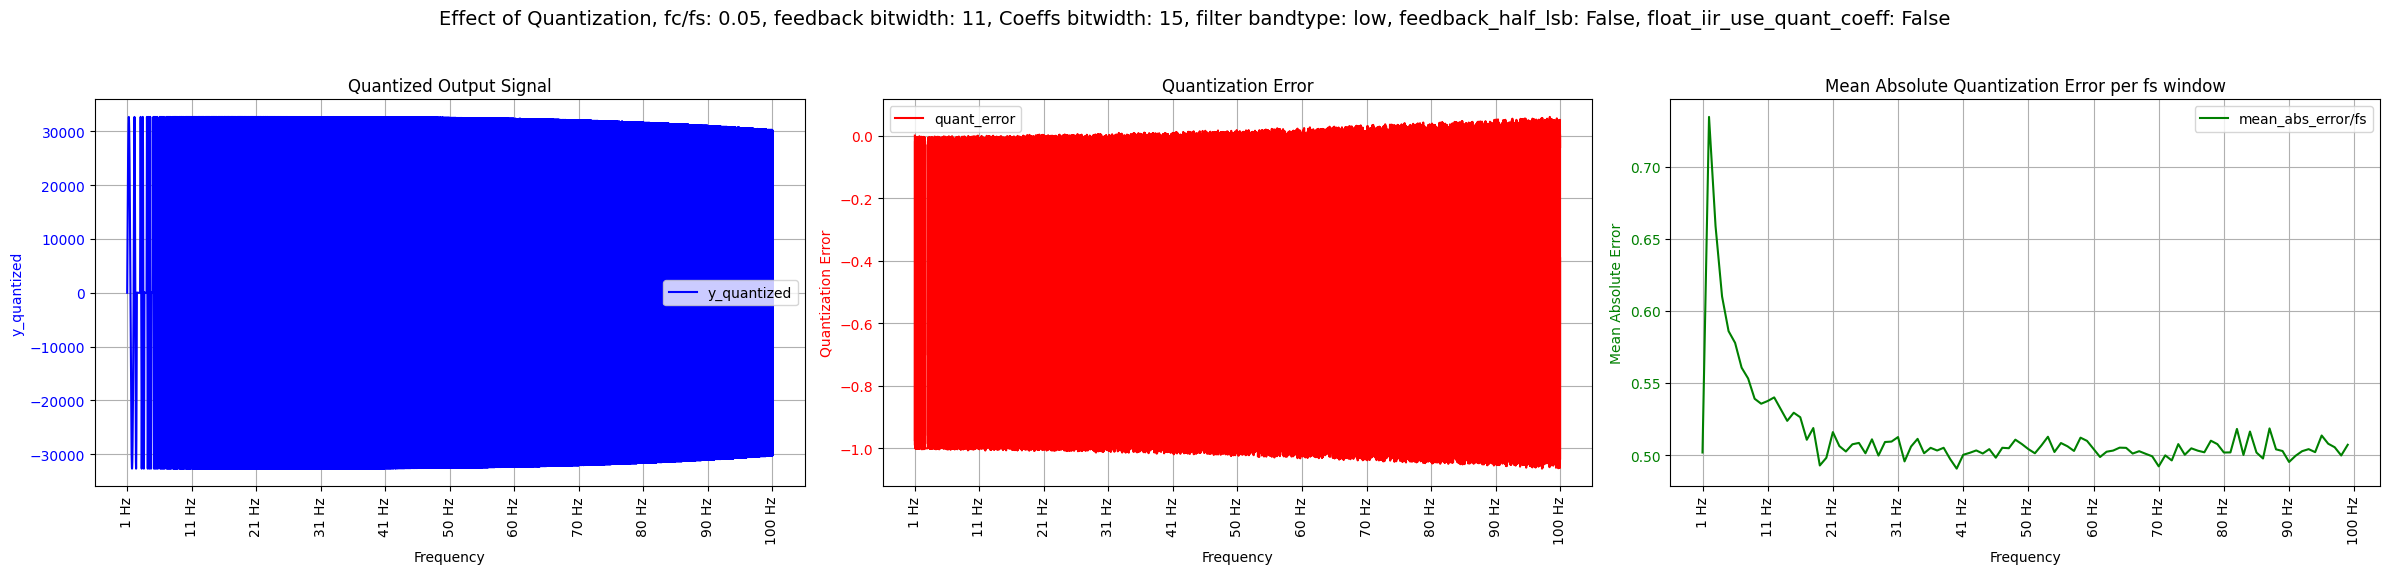

set fc_fs_ratio:  0.06
actually used fc_fs_ratio:  0.061323
C模型加载成功!


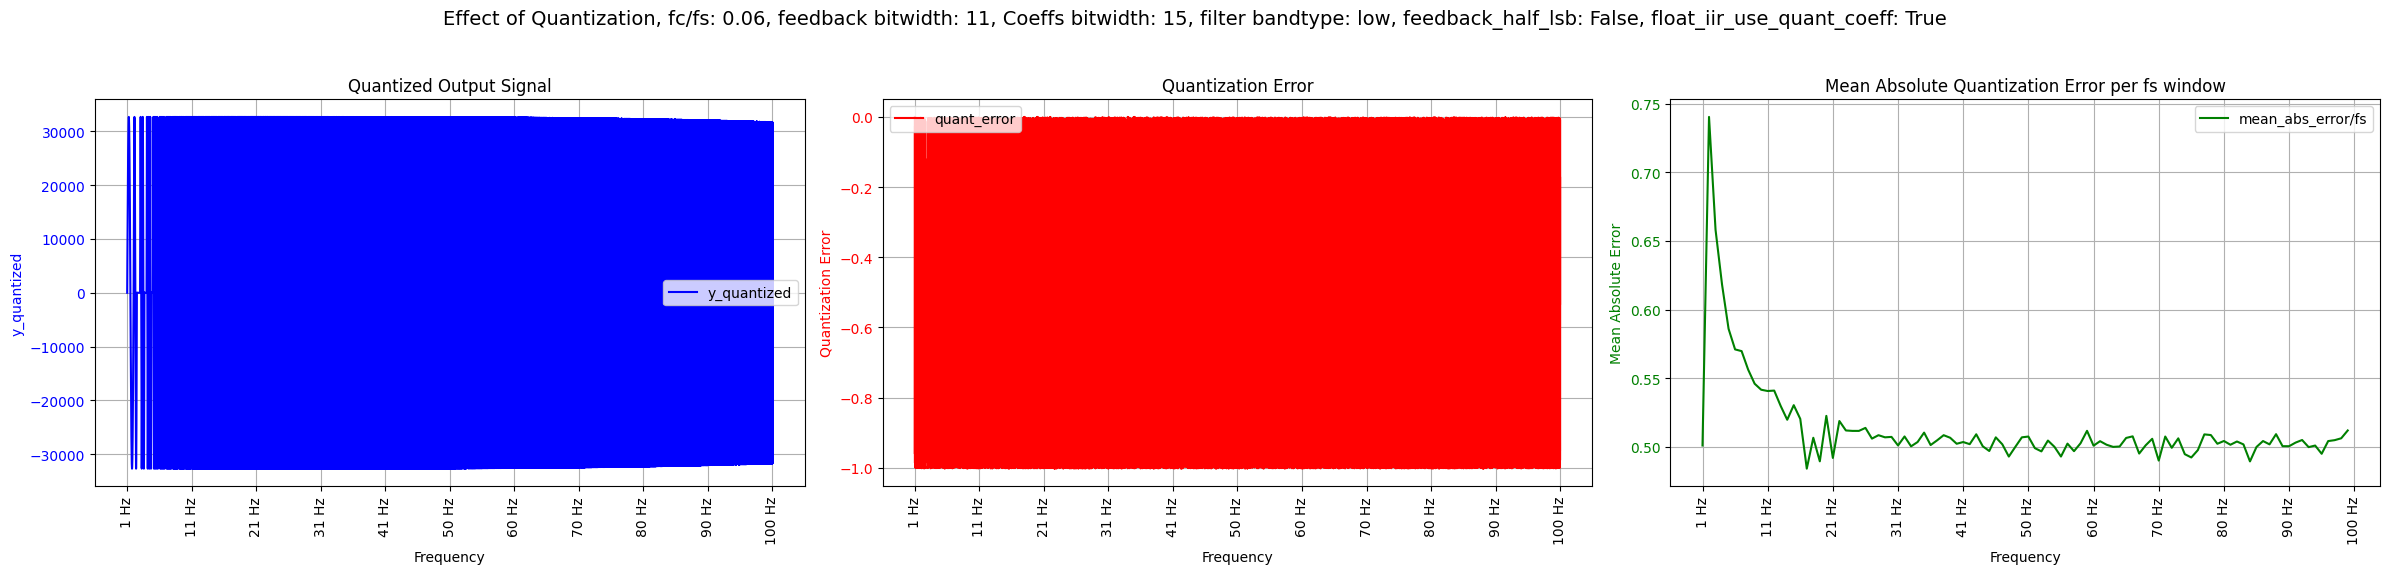

set fc_fs_ratio:  0.06
actually used fc_fs_ratio:  0.061323
C模型加载成功!


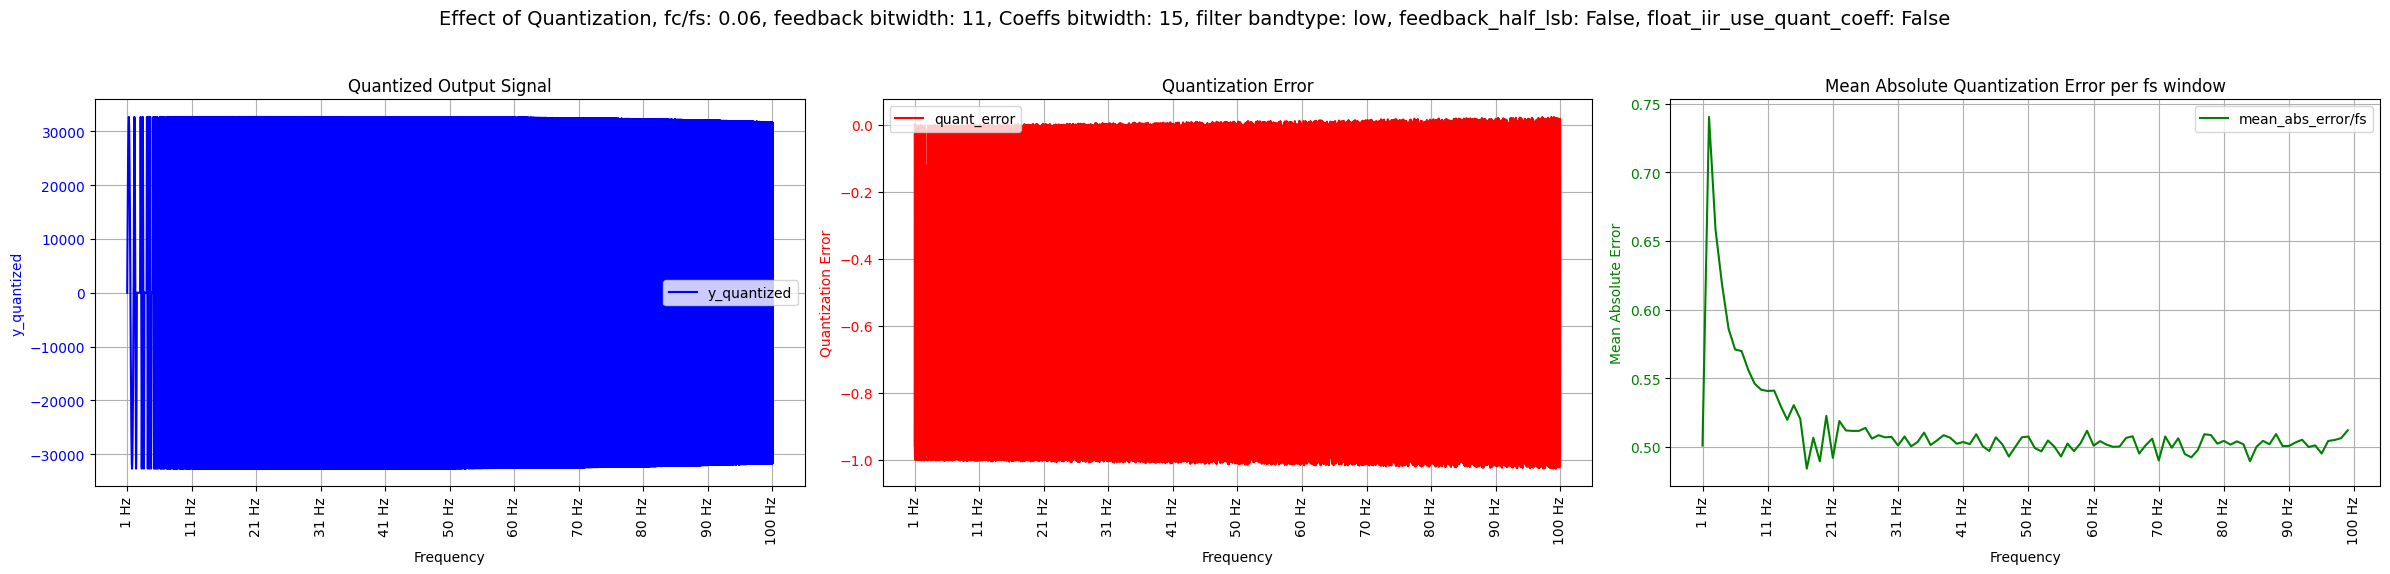

set fc_fs_ratio:  0.07
actually used fc_fs_ratio:  0.07098
C模型加载成功!


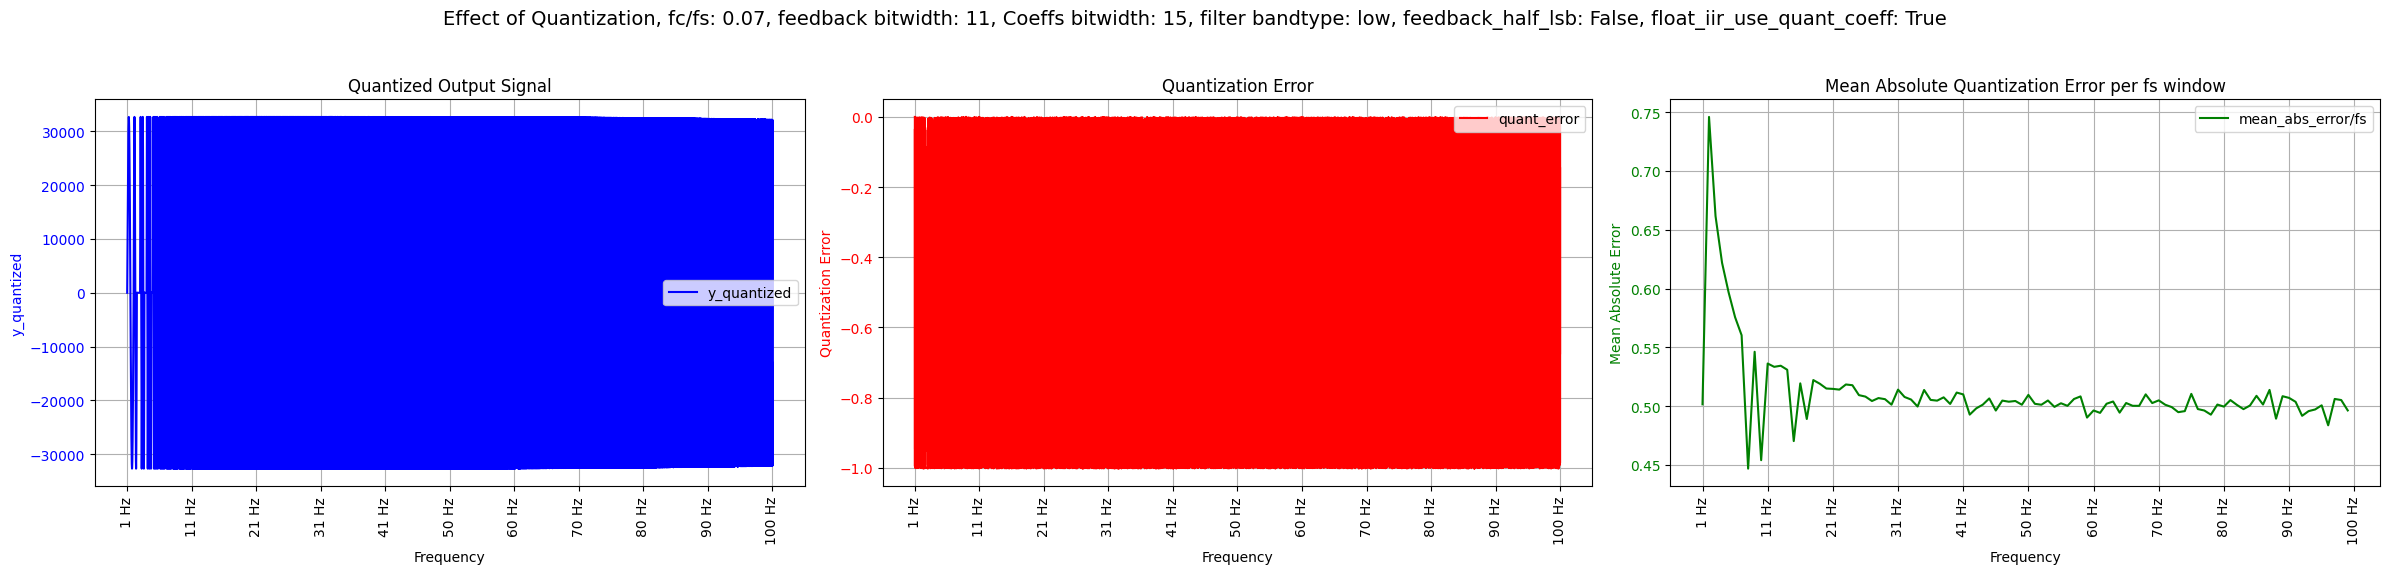

set fc_fs_ratio:  0.07
actually used fc_fs_ratio:  0.07098
C模型加载成功!


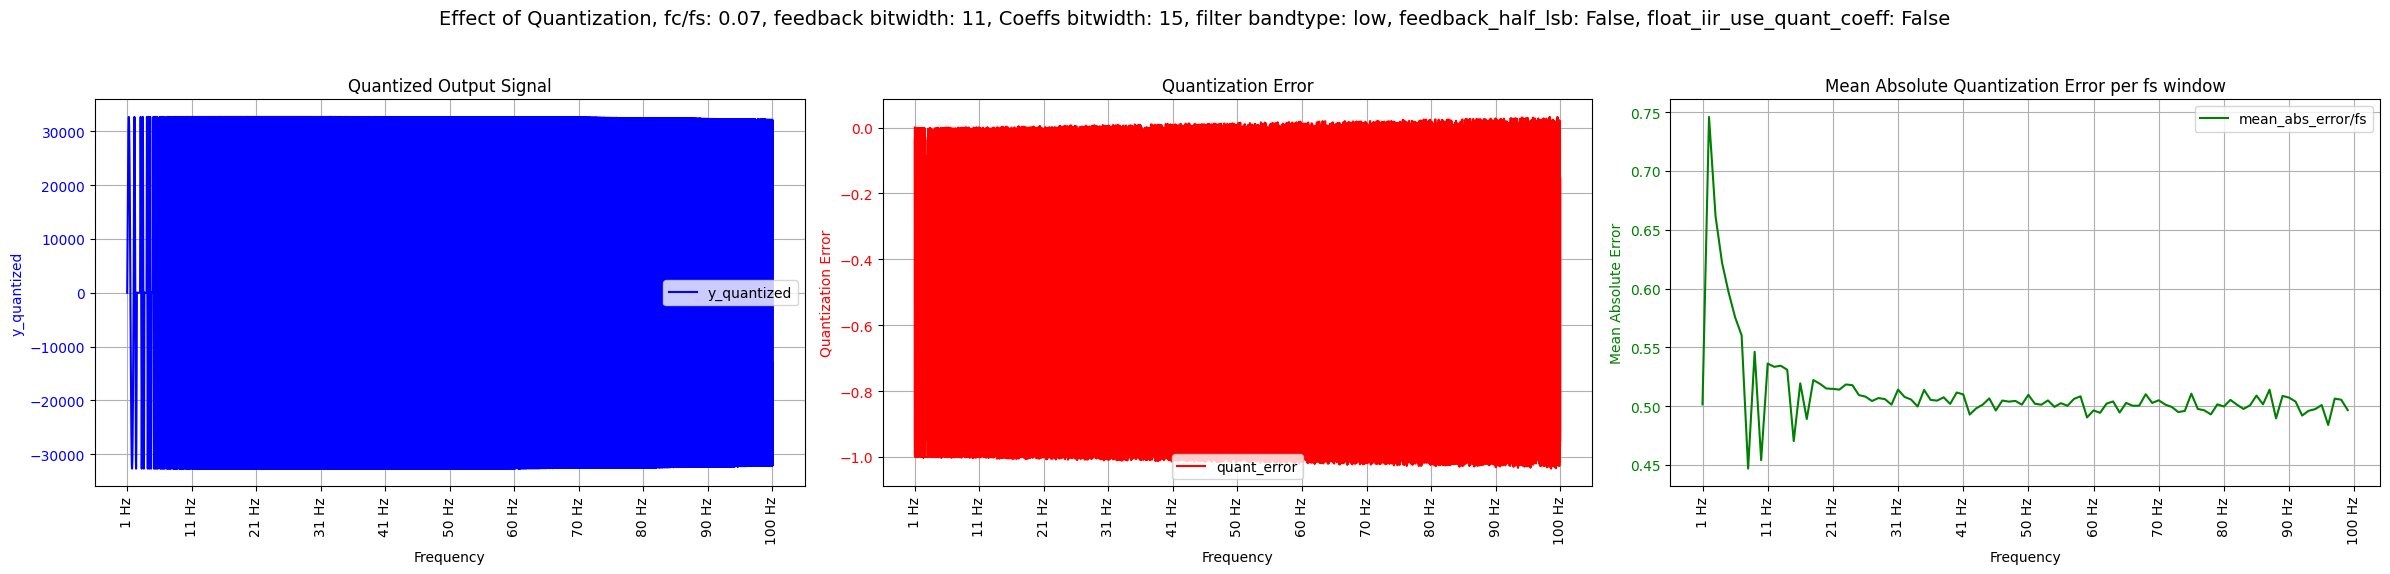

set fc_fs_ratio:  0.08
actually used fc_fs_ratio:  0.083761
C模型加载成功!


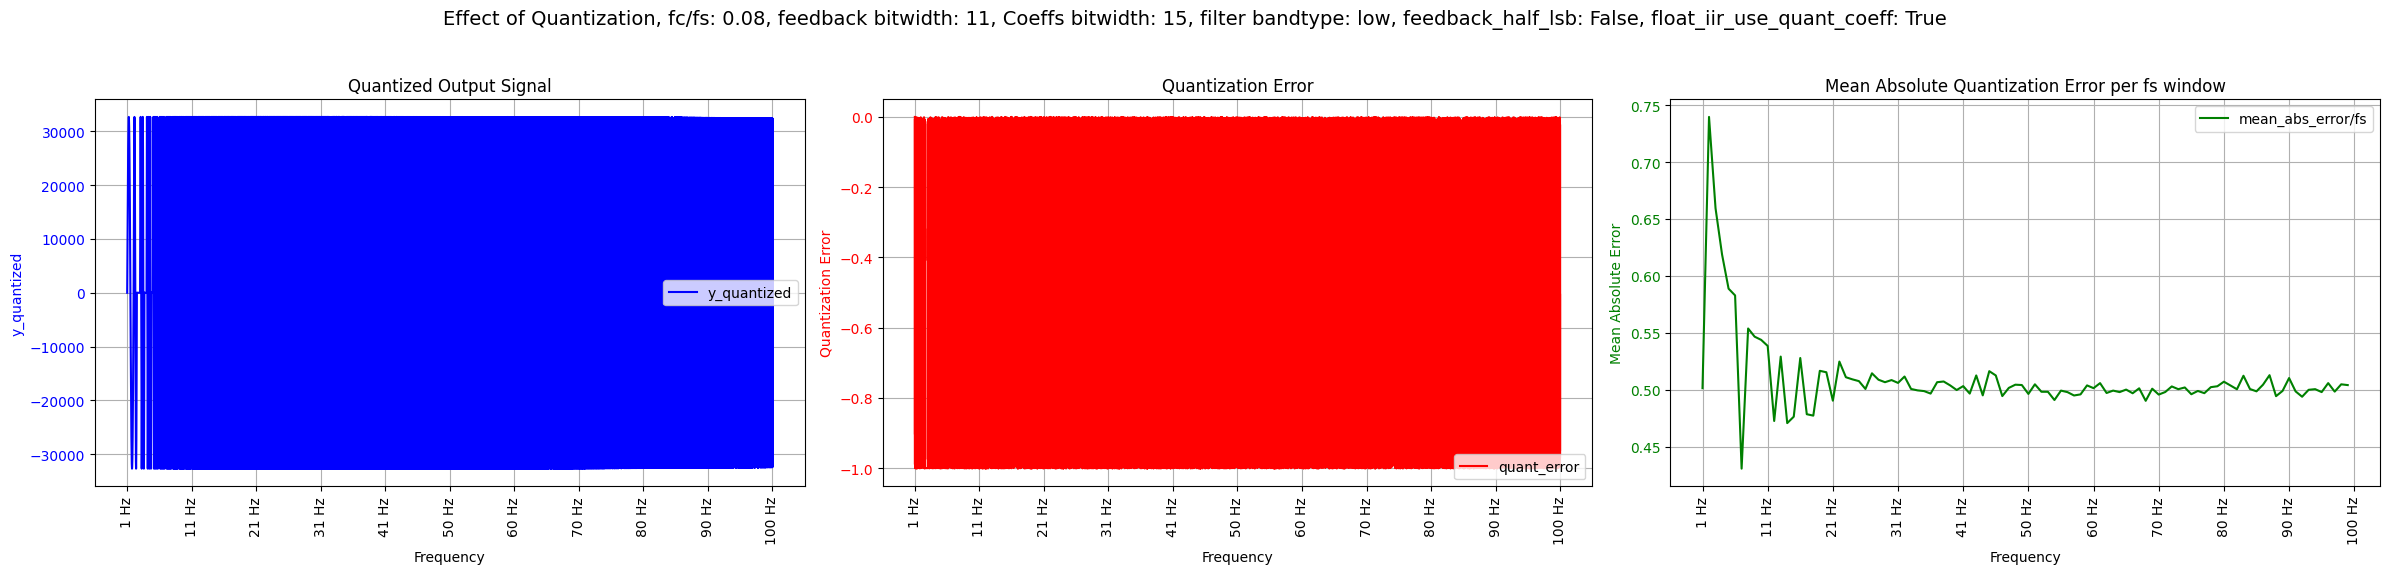

set fc_fs_ratio:  0.08
actually used fc_fs_ratio:  0.083761
C模型加载成功!


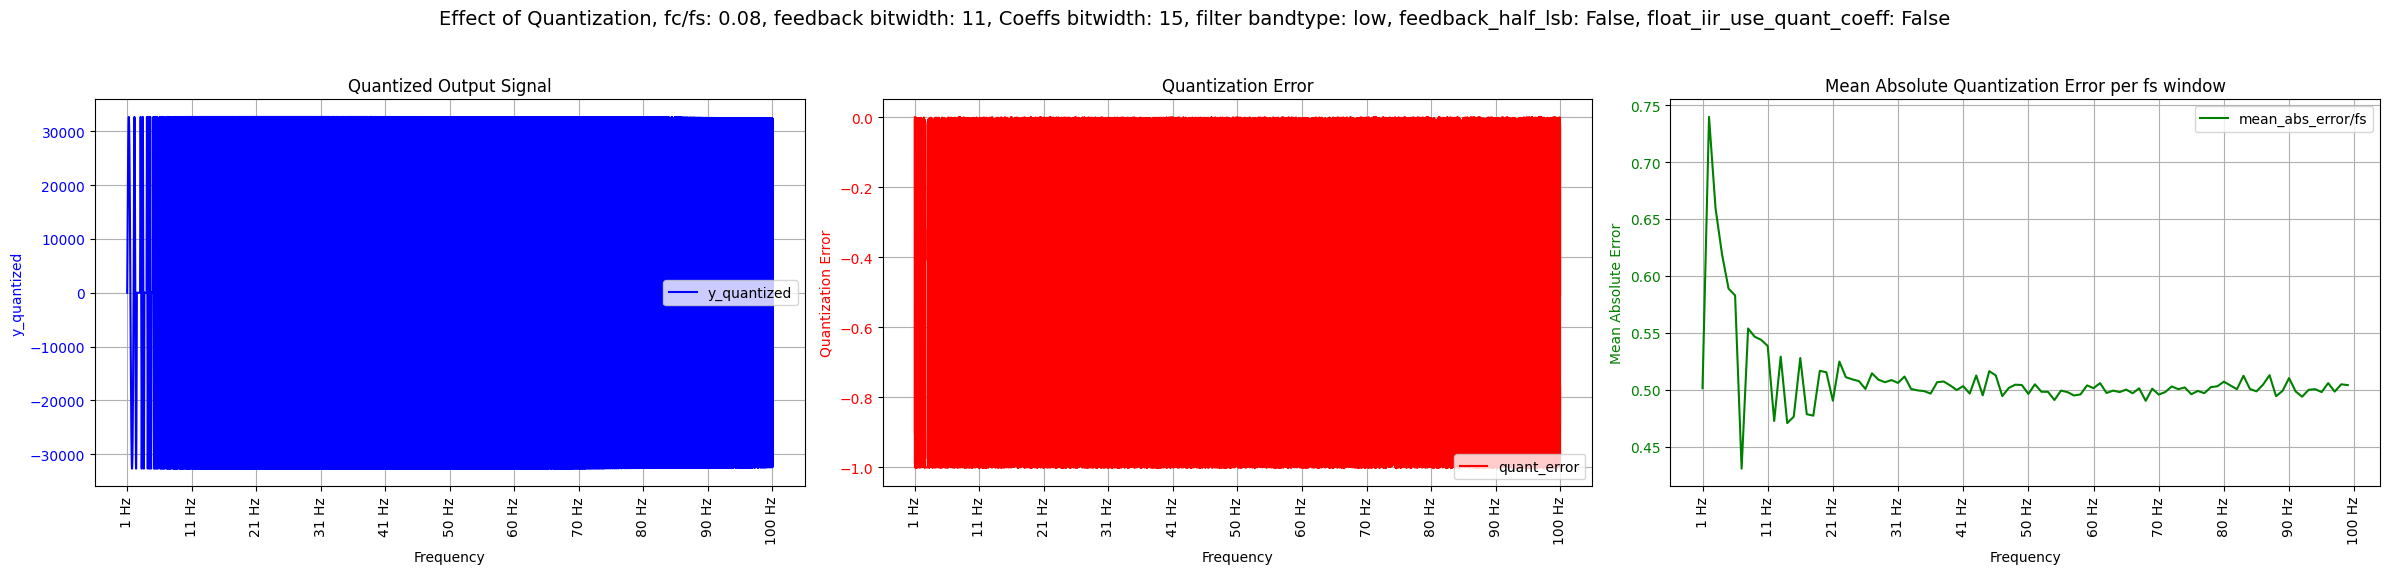

set fc_fs_ratio:  0.09
actually used fc_fs_ratio:  0.089062
C模型加载成功!


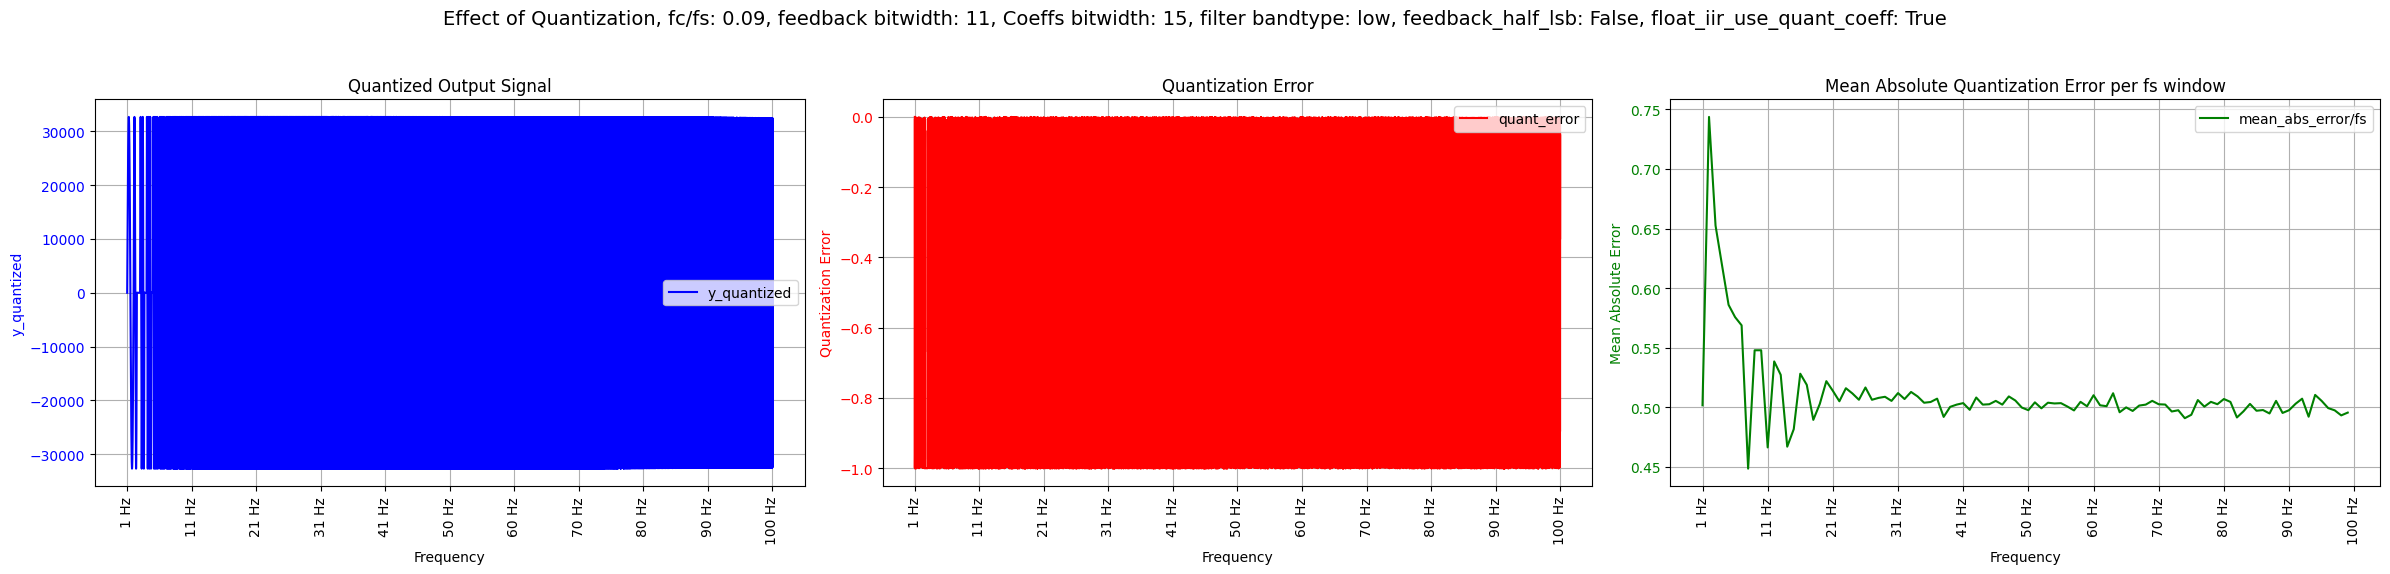

set fc_fs_ratio:  0.09
actually used fc_fs_ratio:  0.089062
C模型加载成功!


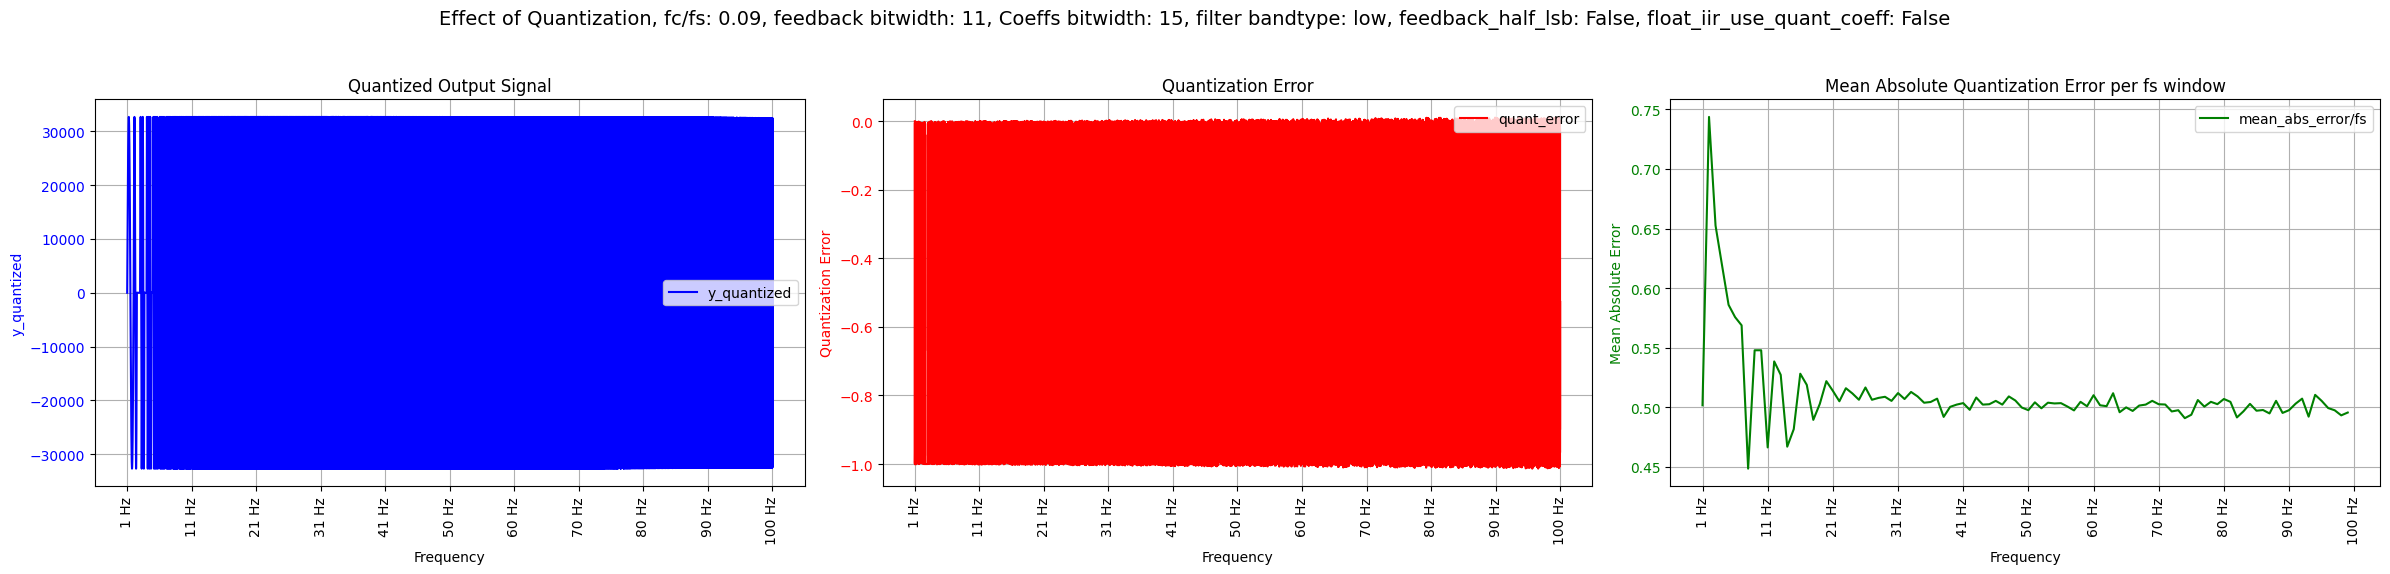

set fc_fs_ratio:  0.1
actually used fc_fs_ratio:  0.10322
C模型加载成功!


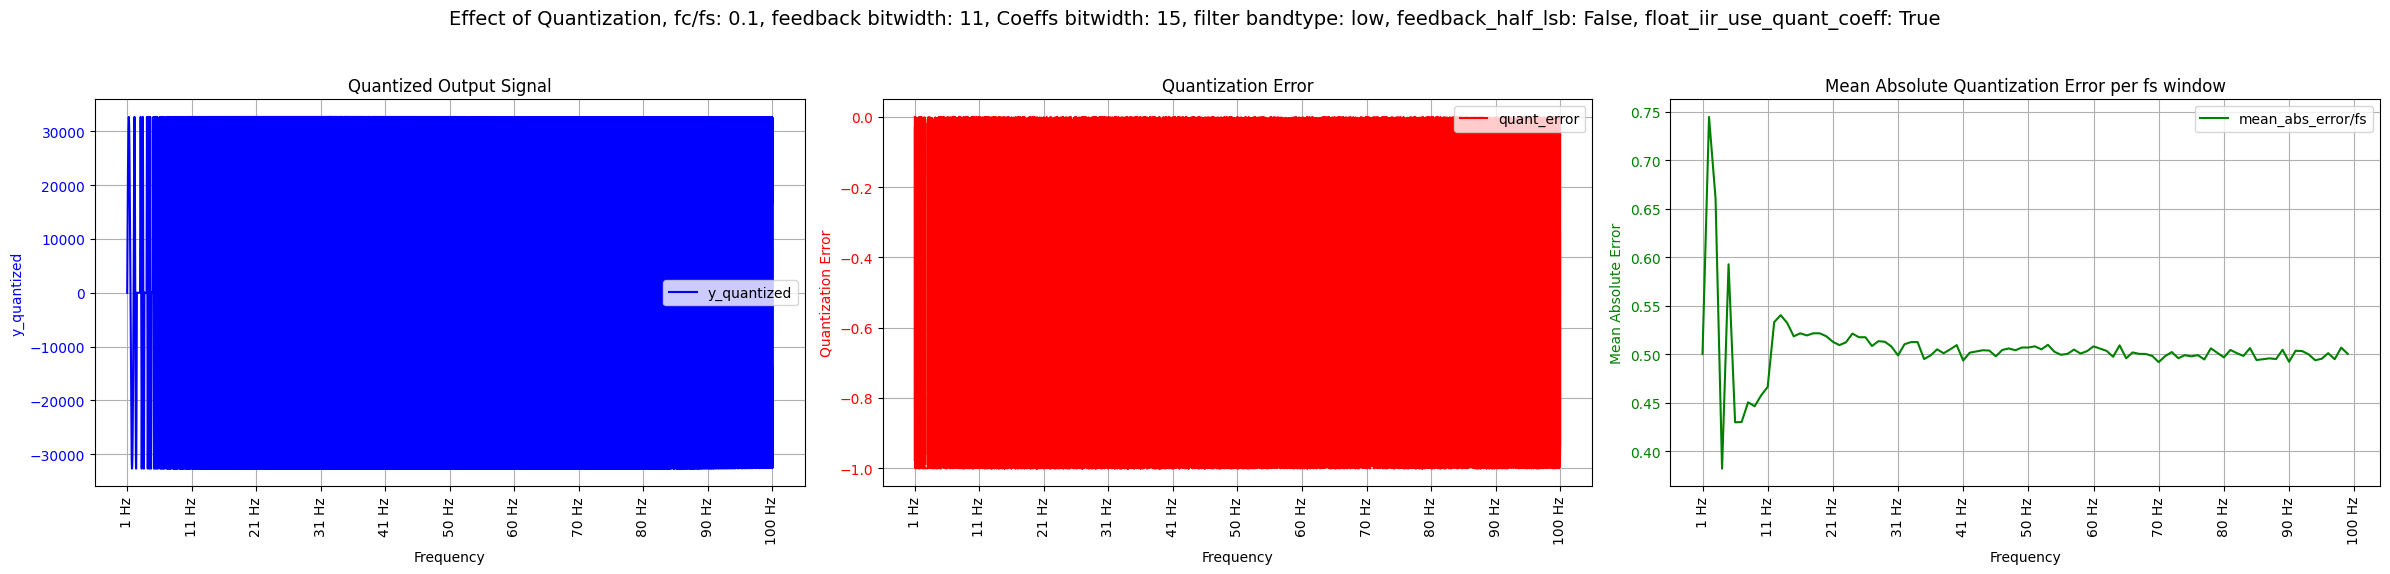

set fc_fs_ratio:  0.1
actually used fc_fs_ratio:  0.10322
C模型加载成功!


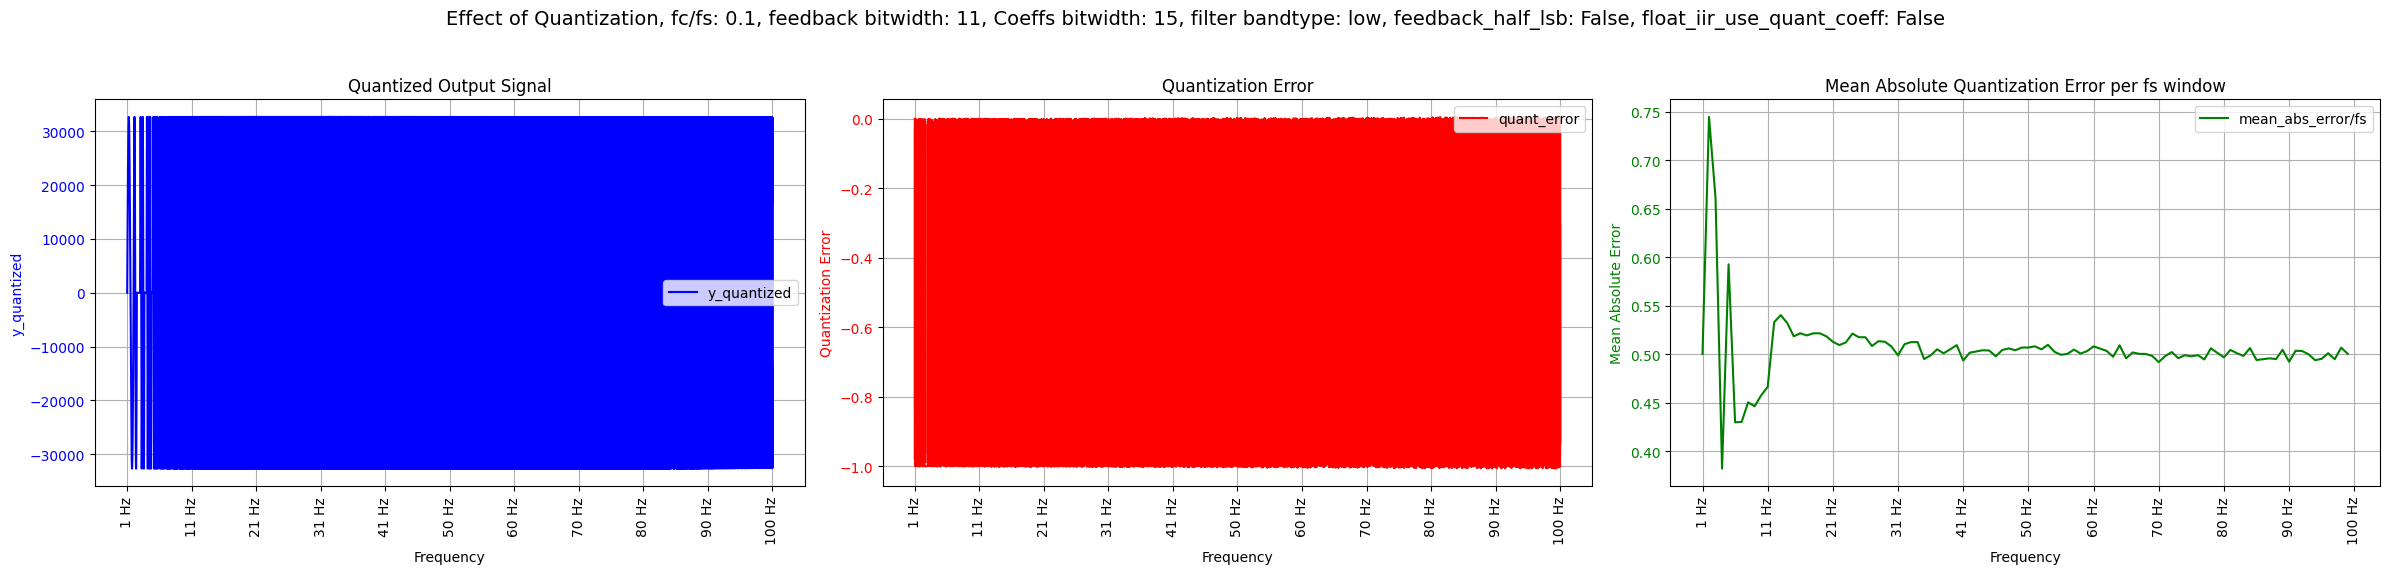

set fc_fs_ratio:  0.12
actually used fc_fs_ratio:  0.114358
C模型加载成功!


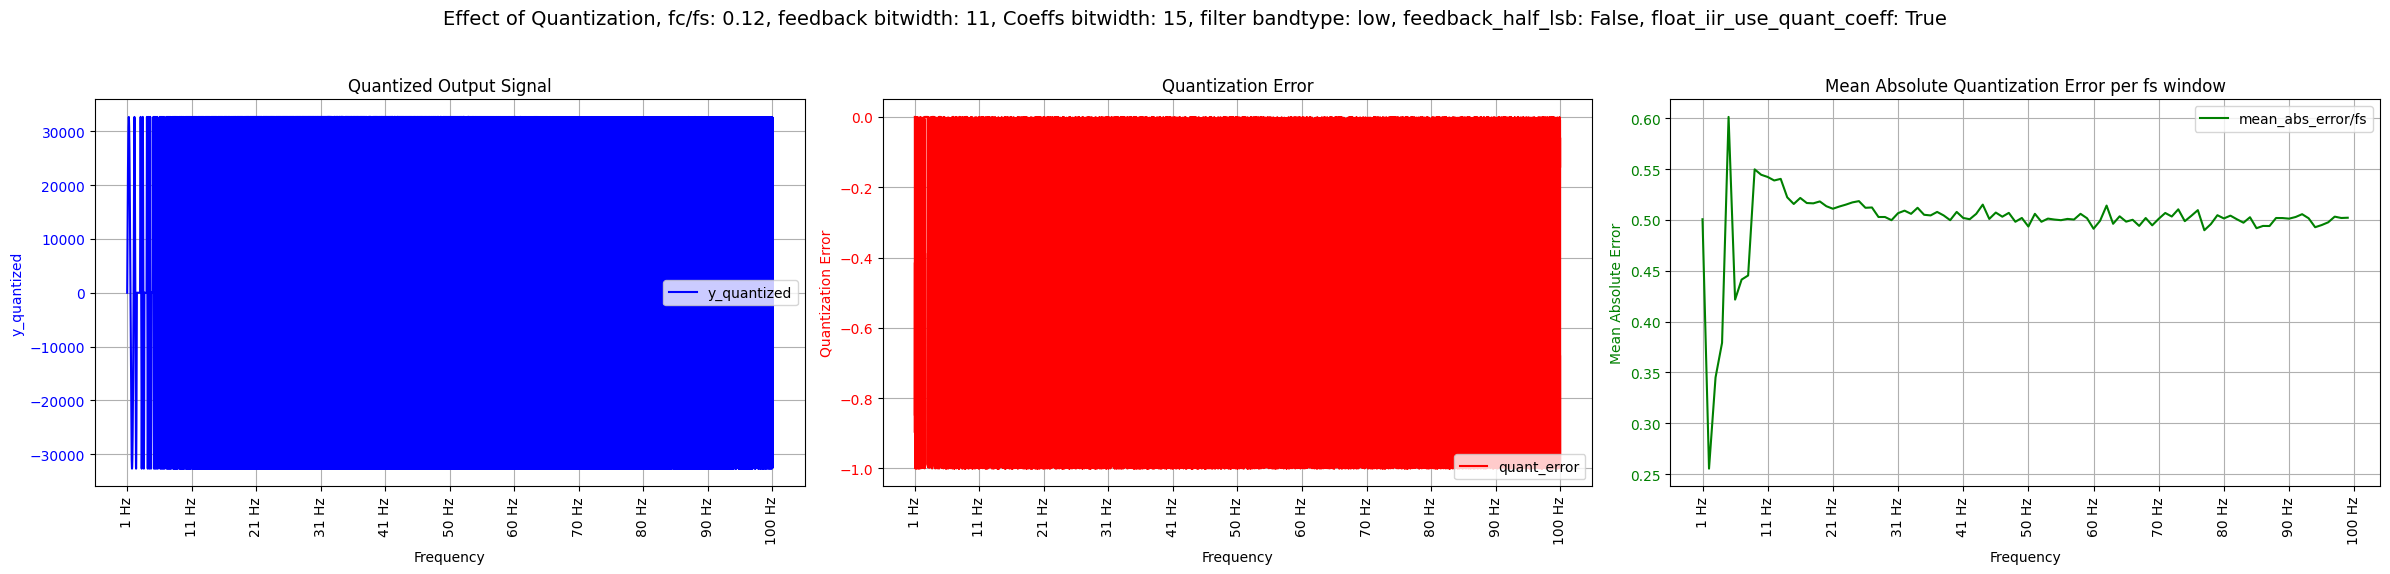

set fc_fs_ratio:  0.12
actually used fc_fs_ratio:  0.114358
C模型加载成功!


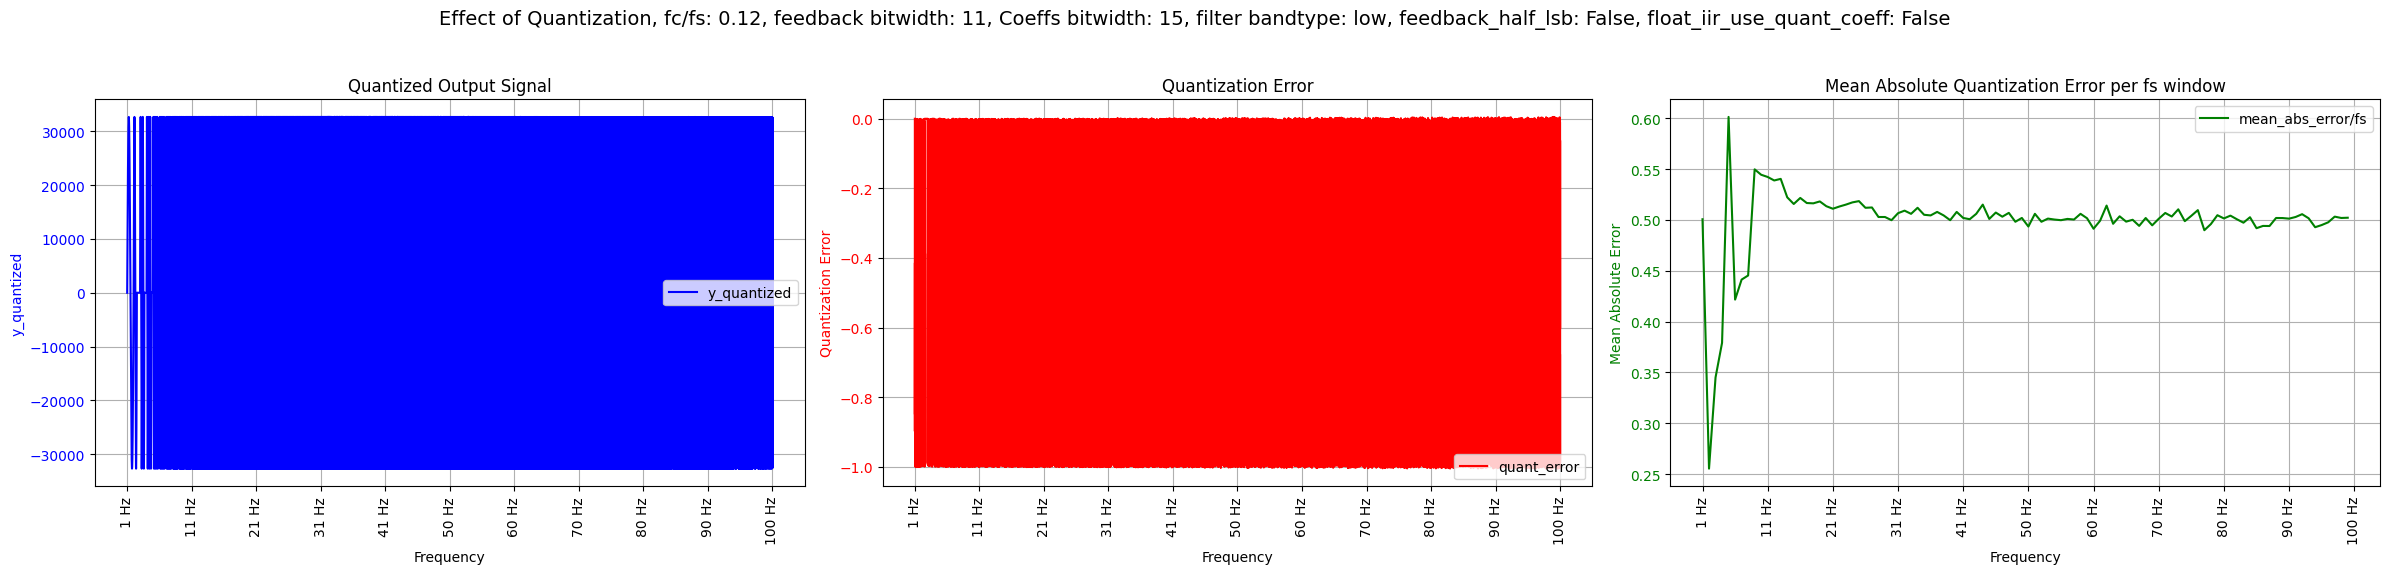

set fc_fs_ratio:  0.14
actually used fc_fs_ratio:  0.145802
C模型加载成功!


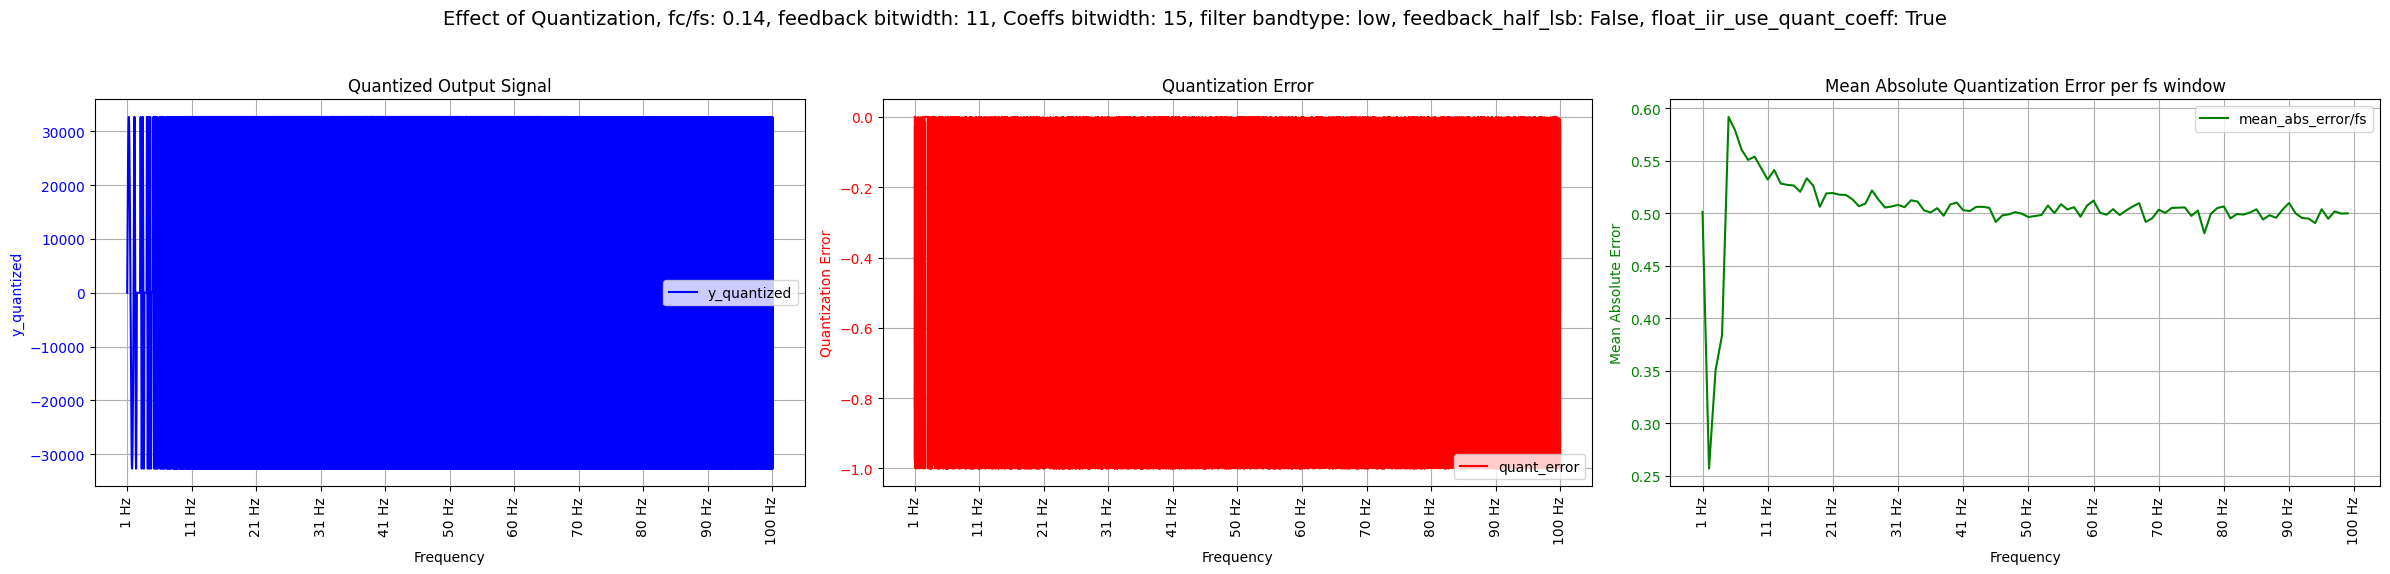

set fc_fs_ratio:  0.14
actually used fc_fs_ratio:  0.145802
C模型加载成功!


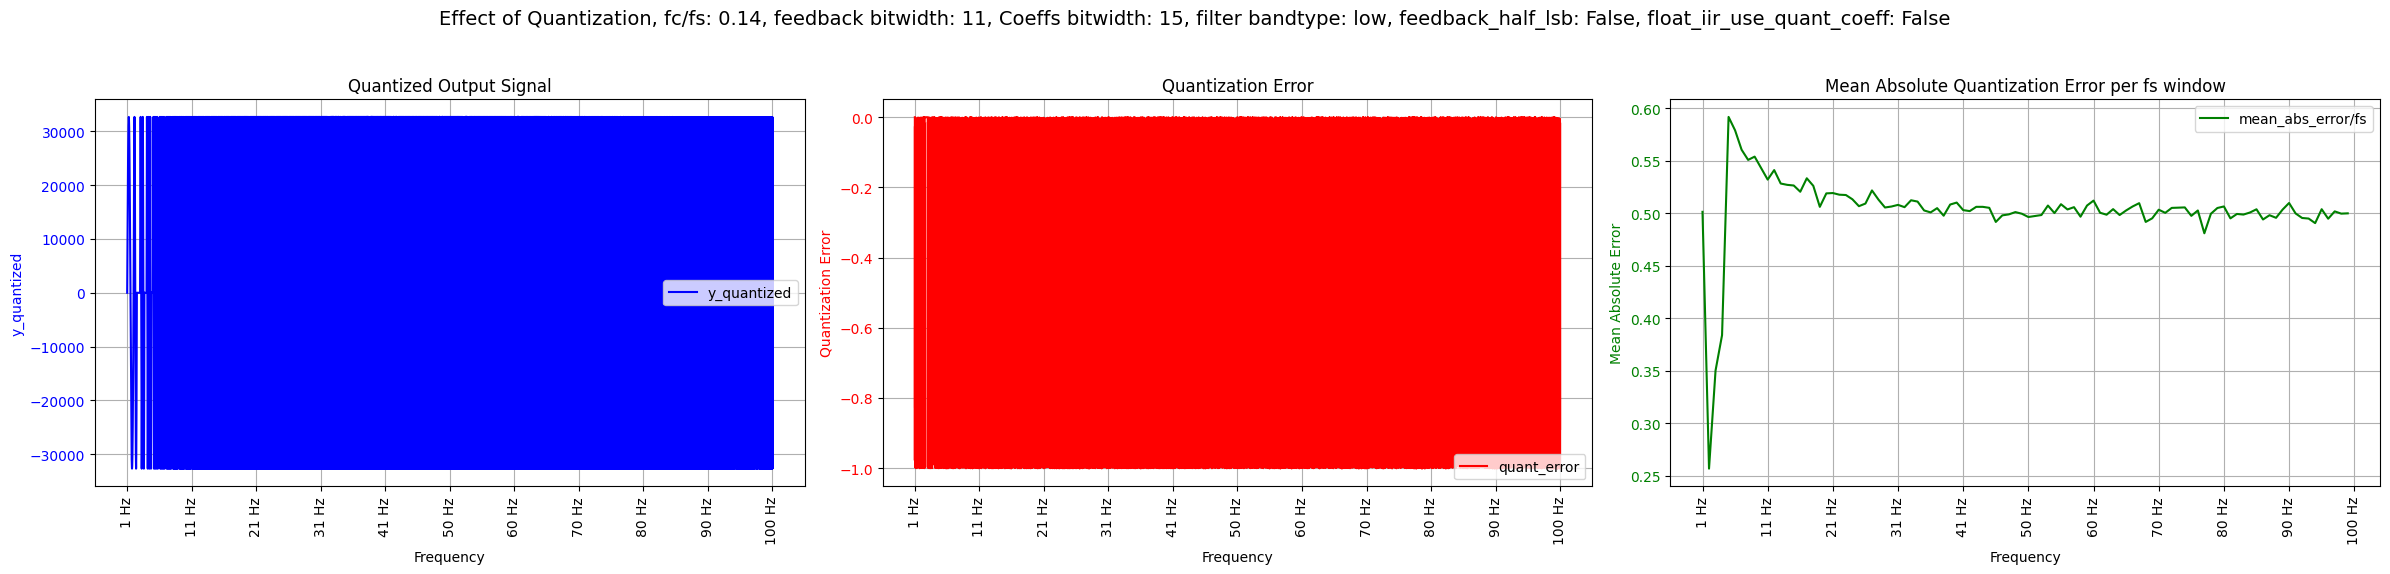

set fc_fs_ratio:  0.16
actually used fc_fs_ratio:  0.160676
C模型加载成功!


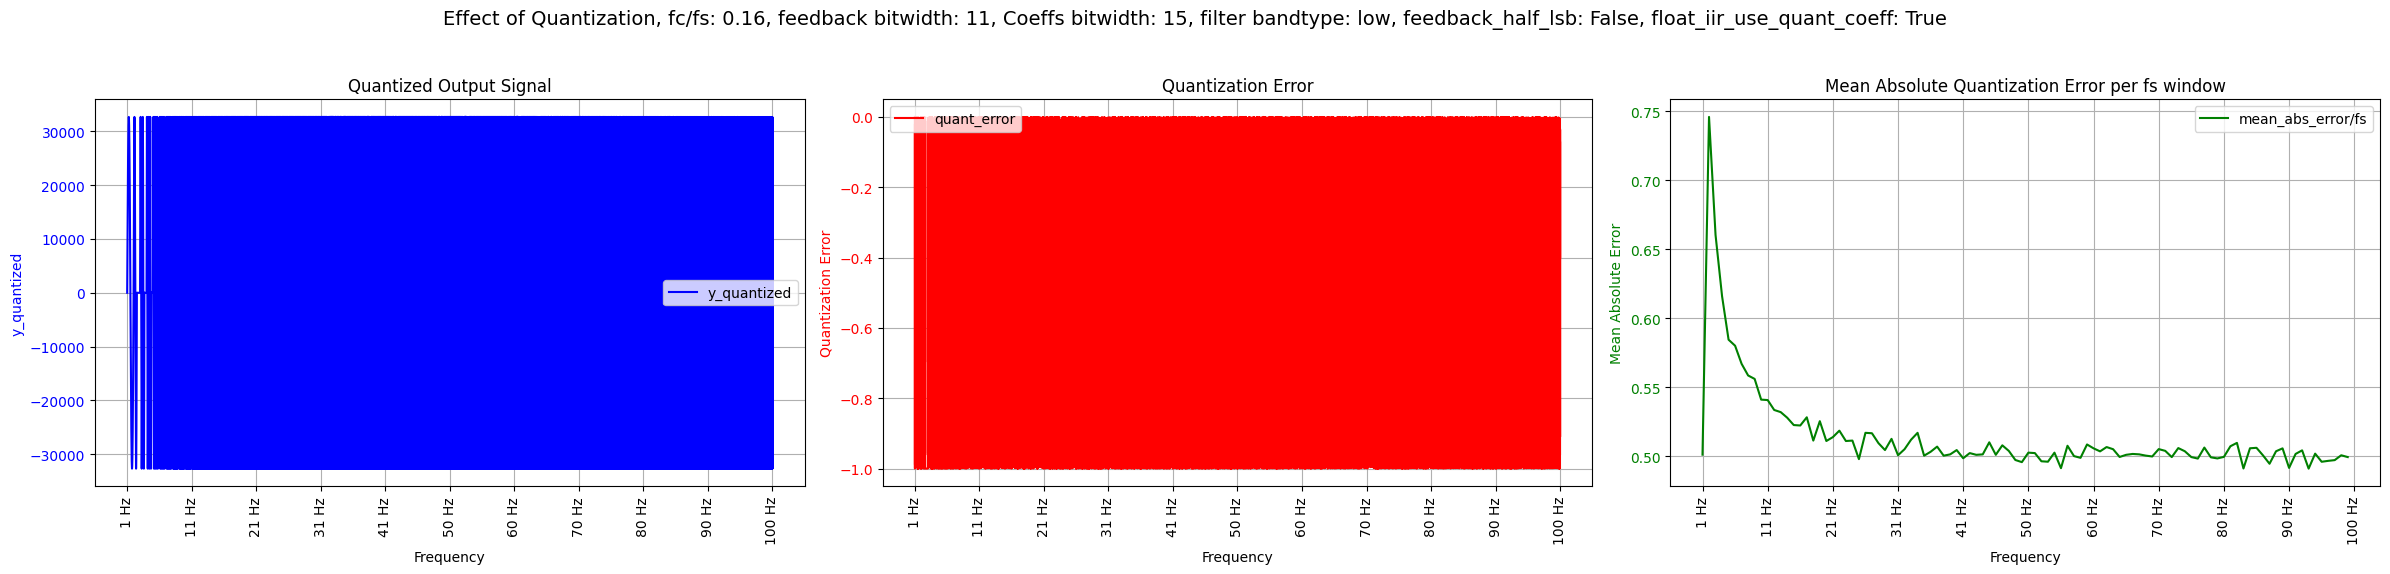

set fc_fs_ratio:  0.16
actually used fc_fs_ratio:  0.160676
C模型加载成功!


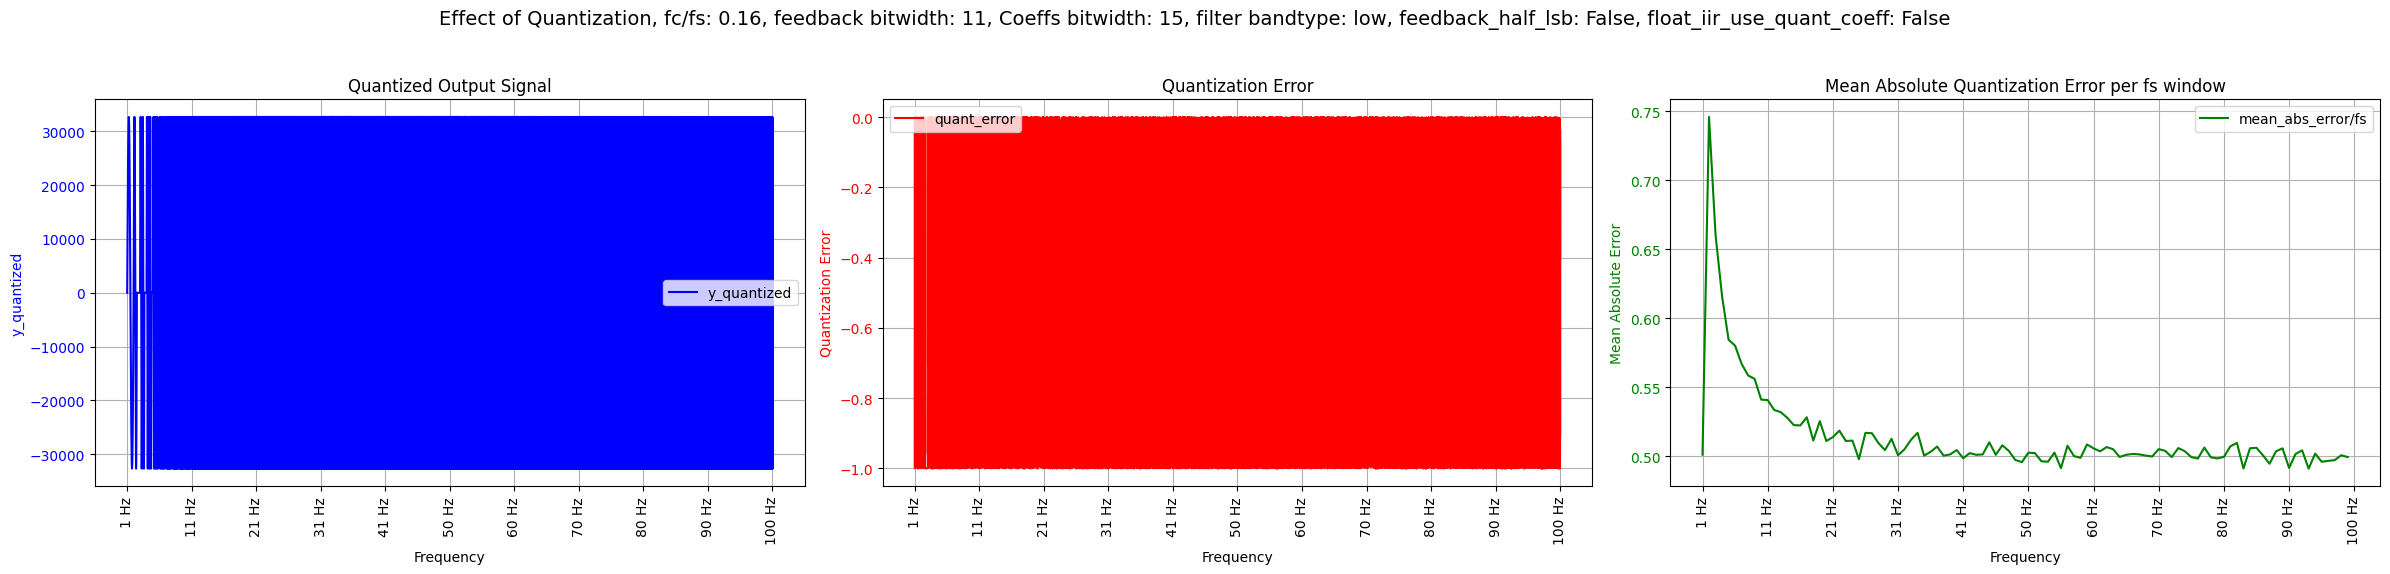

set fc_fs_ratio:  0.18
actually used fc_fs_ratio:  0.187254
C模型加载成功!


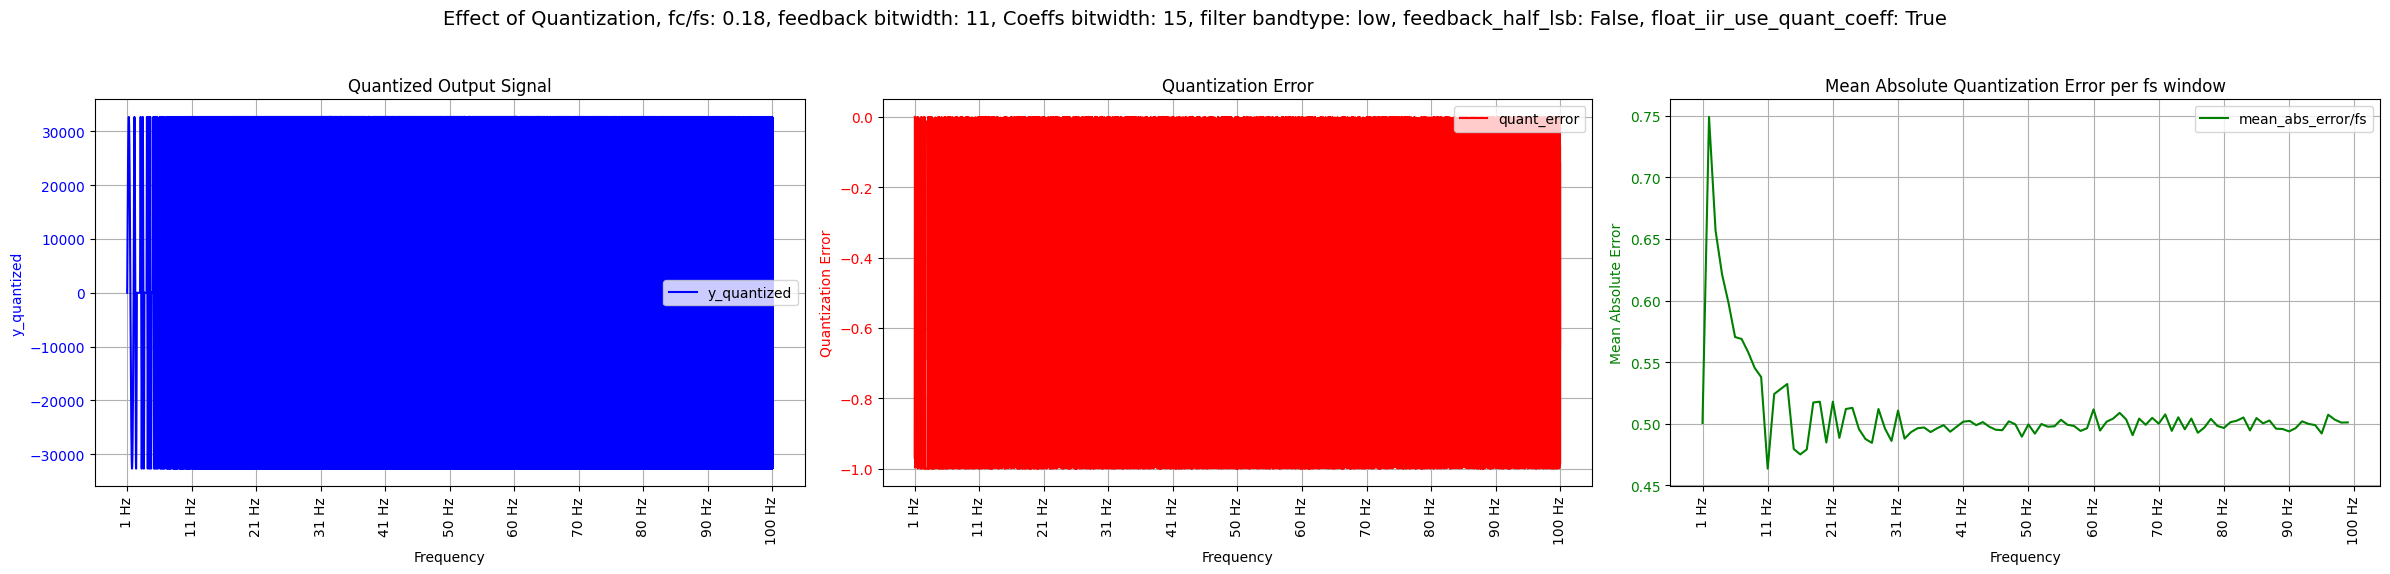

set fc_fs_ratio:  0.18
actually used fc_fs_ratio:  0.187254
C模型加载成功!


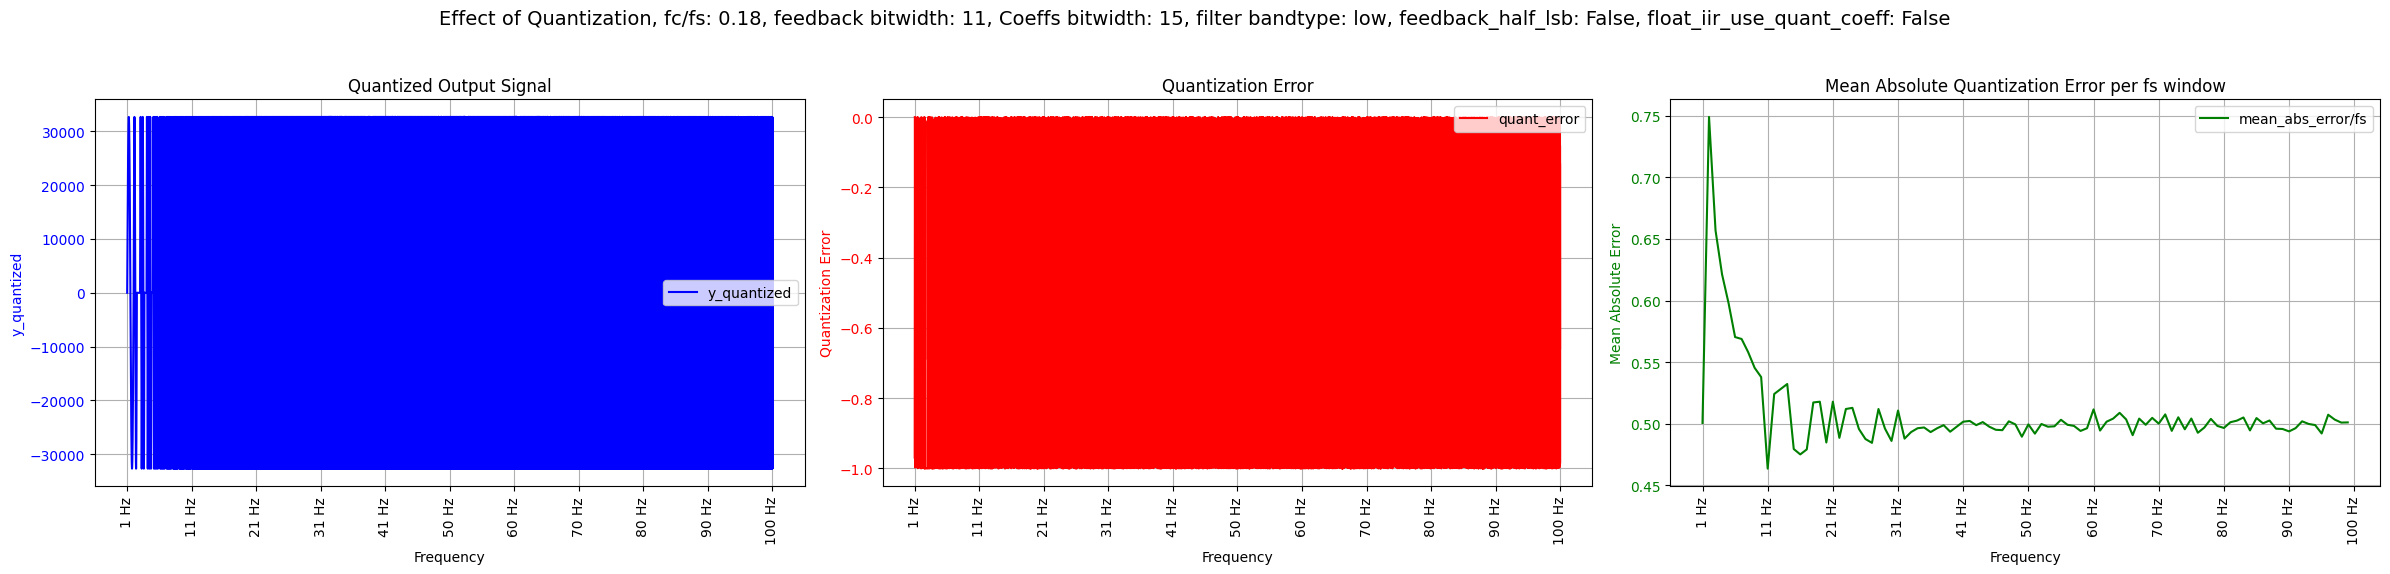

set fc_fs_ratio:  0.2
actually used fc_fs_ratio:  0.191989
C模型加载成功!


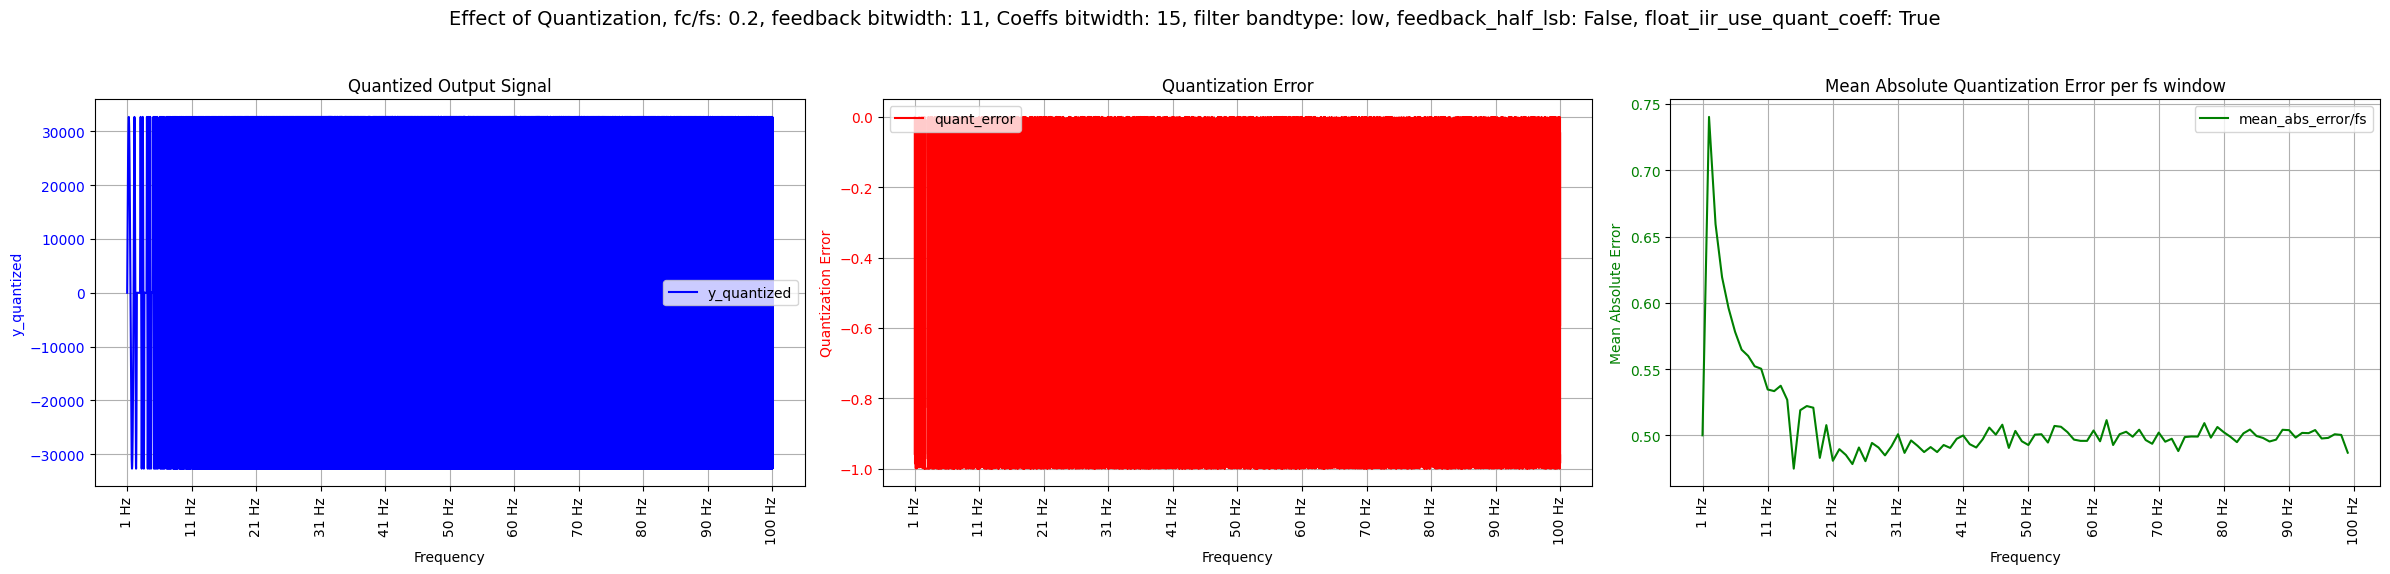

set fc_fs_ratio:  0.2
actually used fc_fs_ratio:  0.191989
C模型加载成功!


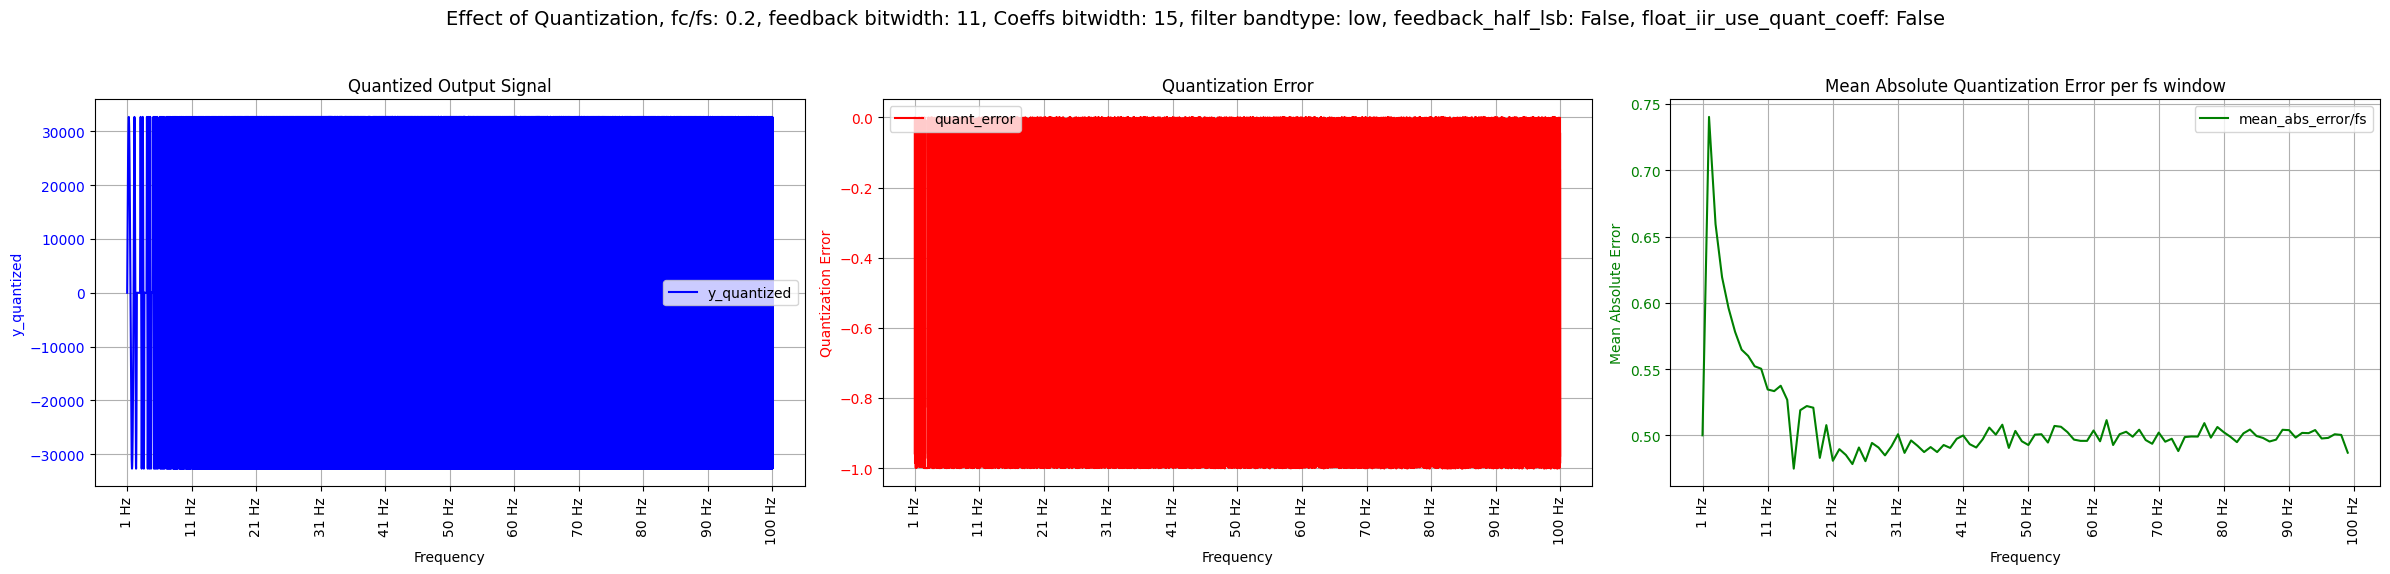

set fc_fs_ratio:  0.22
actually used fc_fs_ratio:  0.220738
C模型加载成功!


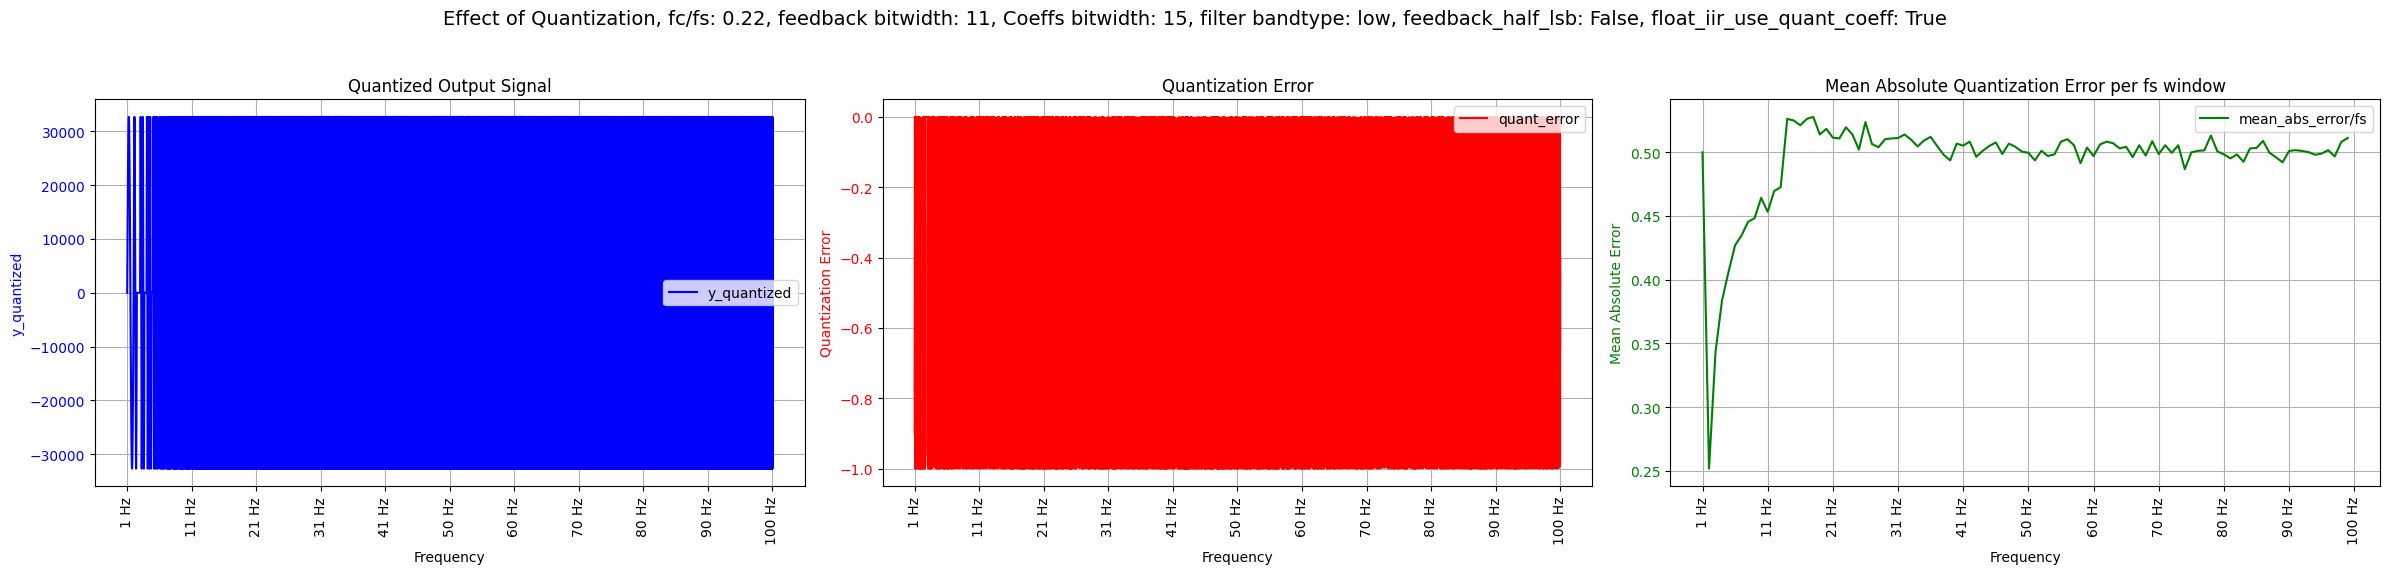

set fc_fs_ratio:  0.22
actually used fc_fs_ratio:  0.220738
C模型加载成功!


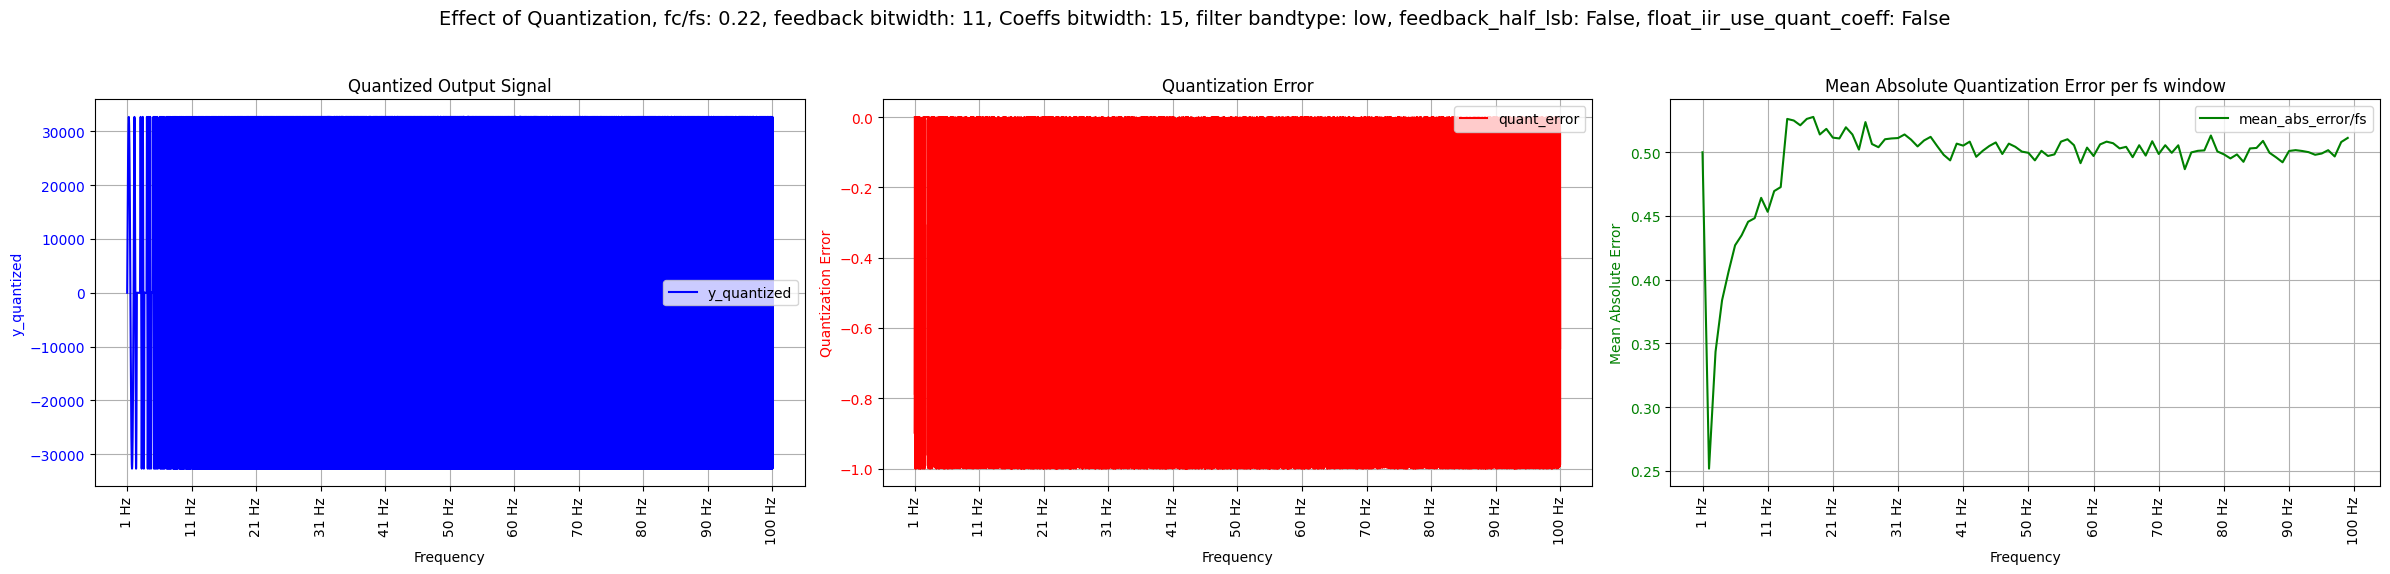

set fc_fs_ratio:  0.24
actually used fc_fs_ratio:  0.239161
C模型加载成功!


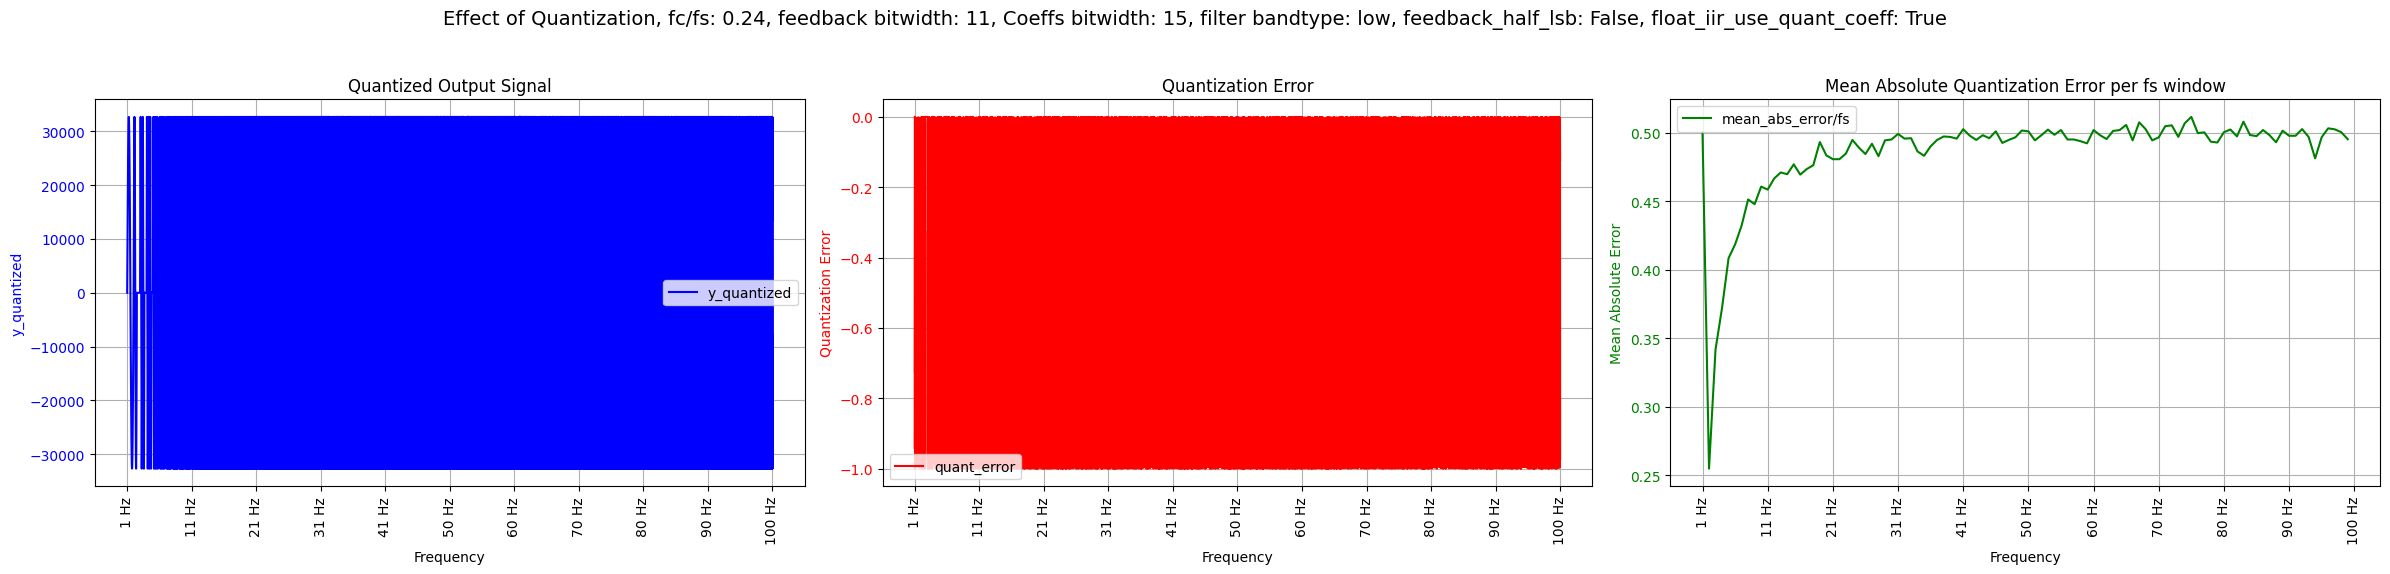

set fc_fs_ratio:  0.24
actually used fc_fs_ratio:  0.239161
C模型加载成功!


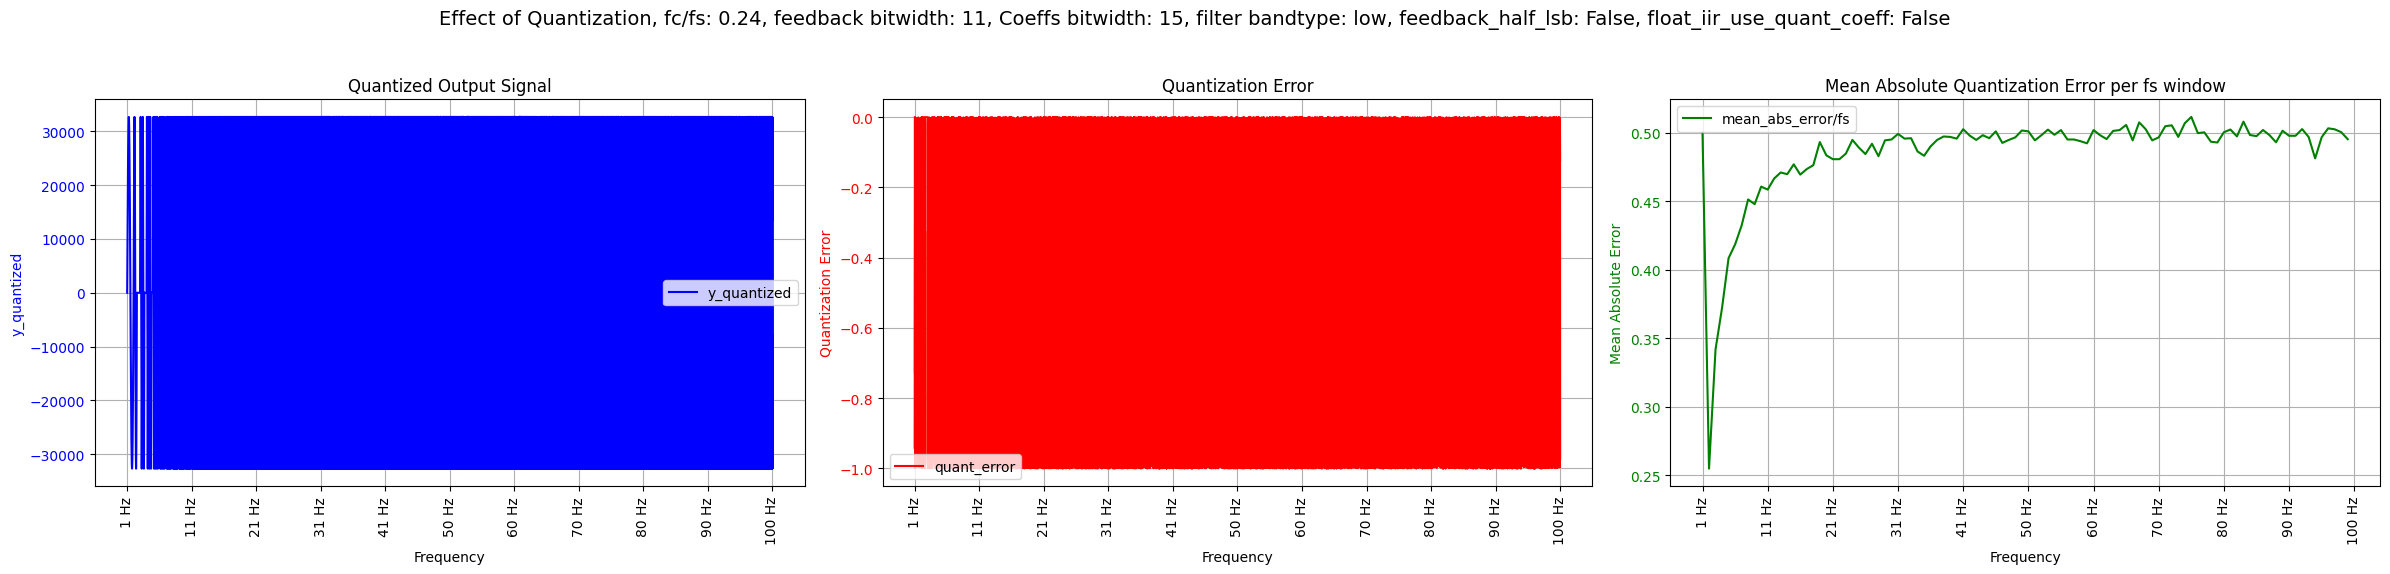

In [ ]:
# # 扫频测试（正弦波扫频测试）:
btype_lists = ['low'] # ['low', 'high'] # lowpass or highpass filter
fc_fs_ratio_lists = [0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24] 
iir_coeff_bit_lists = [15]
output_dec_bits_list = [11]
signal_range_list = [32700]
feedback_half_lsb_list = [False] # [False, True]  # 是否在反馈路径添加0.5 LSB的偏移量以避免负反馈, 实际测试下来影响不大
float_iir_use_quant_coeff_list = [True, False] # [True, False]  # 是否使用量化系数来初始化浮点IIR
noise_range = 0
signal_offset = 0
# signal generator params
# 生成一个从1Hz到2500Hz的正弦波信号，1s一个频率段
start_freq = 1      # 起始频率
end_freq = 100     # 终止频率
fs = 3200  # 每秒采样点数
time = 100  # 仿真时间

for btype in btype_lists:
    for signal_range in signal_range_list:
        generated_signal = signal_generator(fs, time, signal_range, noise_range, signal_offset, start_freq, end_freq)
        for fc_fs_ratio in fc_fs_ratio_lists:
            for iir_coeff_bit in iir_coeff_bit_lists:
                for output_dec_bits in output_dec_bits_list:
                    for feedback_half_lsb in feedback_half_lsb_list:
                        for float_iir_use_quant_coeff in float_iir_use_quant_coeff_list:
                            print("set fc_fs_ratio: ", fc_fs_ratio)
                            # if (float_iir_use_quant_coeff):
                            print("actually used fc_fs_ratio: ", fcfs_bq_aq_dict[fc_fs_ratio][1])
                            analyze_quantization_error(generated_signal, fc_fs_ratio, fcfs_bq_aq_dict, fs=fs, start_freq = start_freq, end_freq = end_freq, signal_range=signal_range, btype=btype, feedback_half_lsb=feedback_half_lsb, float_iir_use_quant_coeff=float_iir_use_quant_coeff)
